In [1]:
import numpy as np
import operator
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

## Support Code

In [2]:
transitions = [ "Receiving Request", "First Assessment", "Fraud Check",  "Invisible 2", "Invisible 1",
"Accept", "Decline", "Create Offer", "Contact Customer", 
"Offer Refused", "Draw Contract", "Send Contract", ]
names_to_transition = dict(zip(transitions, range(len(transitions))))

PLACES = 12
TRANSITIONS = 12

# helper conversion list to numpy array
def list_to_array(sol): return np.array(sol).reshape((PLACES, TRANSITIONS))

# fitness evaluation
def fitness(sol, w=0.9):
	sol = list_to_array(sol)	
	result = 0
	for trace in dataset:
		fit, _ = evaluate_sequence(sol, trace) 
		result += fit
	return w*result-(1-w)*np.count_nonzero(sol),

	
# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
	res = []
	with open(path) as fi:
		for line in fi:
			res.append(line.strip().split(", "))
	return res

# evaluates a sequence of actions from the dataset, 
# using the Petri net encoded in the matrix
def evaluate_sequence(matrix, sequence): 
	code_sequence = [names_to_transition[x] for x in sequence]
	pos = 0 # start from place 0
	total = 0 
	properly = True
	places, n_trans = matrix.shape
	for code in code_sequence:
		if matrix[pos][code]==-1:
			total +=1
			for i in range(places):
				if matrix[i][code]==1:
					pos=i
					break
		else:
			properly = False
			continue
	return total, properly

# plot the Petri net
def matrix_to_graphviz(matrix, output_file="output.pdf"):
	from pm4py.objects.petri_net.obj import PetriNet, Marking
	from pm4py.visualization.petri_net import visualizer as pn_visualizer
	from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to

	matrix = list_to_array(matrix)

	net = PetriNet("PETRINAS")
	places, n_trans = matrix.shape

	for d in range(places):
		np = PetriNet.Place("p%d" % (d + 1))
		net.places.add(np)

	for d in range(n_trans):
		nt = PetriNet.Transition(transitions[d], transitions[d])
		net.transitions.add(nt)

	for nt, transition in enumerate(matrix.T):
		for np, place in enumerate(transition):

			# ingoing
			if place == 1:

				from_node1 = to_node1 = None

				for from_tran in list(net.transitions):
					if str(from_tran).split(", ")[0][1:] != transitions[nt]: continue
					from_node1 = from_tran

				for to_place in net.places:
					if str(to_place) != 'p%d' % (np + 1): continue
					to_node1 = to_place

				add_arc_from_to(from_node1, to_node1, net)

			elif place == -1:

				from_node2 = to_node2 = None

				for from_place in net.places:
					if str(from_place) != 'p%d' % (np + 1): continue
					from_node2 = from_place

				for to_tran in list(net.transitions):
					if str(to_tran).split(", ")[0][1:] != transitions[nt]: continue
					to_node2 = to_tran

				add_arc_from_to(from_node2, to_node2, net)

	parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
	gviz = pn_visualizer.apply(net, parameters=parameters)
	pn_visualizer.save(gviz, output_file)


dataset = load_dataset("dataset_a1.txt")


### General Setup

In [3]:
#Create fitness value with maximization objective and define each candidate solution as a list
creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

#Using the in-built function Toolbox()
toolbox = base.Toolbox()

#Each genome consists of a sequence of -1,0,1 arranged randomly
toolbox.register("attr_item", random.randint, -1, 1)

#The length of a genome is 144 (12 squared)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_item, 144) 

#Create a population of collection of genomes
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



### 1. Implement the GA using deap.algorithms.eaSimple method in DEAP

In [83]:
# Evaluate a genome by a 'fitness' function 
toolbox.register("evaluate",fitness)

# Twopoint crossover is used (as mentioned)
toolbox.register("mate", tools.cxTwoPoint)

# Multi-Flip Bit mutation is carried out. Probability of flipping a attribute in a genome is 0.05
toolbox.register("mutate", tools.mutFlipBit,indpb=0.05)

# Tournament selection with tournament of size 4
toolbox.register("select",tools.selTournament,tournsize=4 ) 

In [7]:
NGEN = 30       #Number of generations
MU = 300         #The number of individuals in first generation (initial population)
CXPB = 0.9      #Cross-over probability
MUTPB = 0.05     #Mutation probability

pop = toolbox.population(n=MU)

# Hall of Fame
hof = tools.ParetoFront()

# Statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0) 
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# easimple algorithm is implemented. Population and logbook of statistic results are stored 
pop,log=algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats,halloffame=hof)

gen	nevals	avg      	std         	min   	max    
0  	300   	[138.192]	[79.6785994]	[-9.6]	[381.6]
1  	268   	[214.08366667]	[67.81426128]	[10.3]	[399.9]
2  	264   	[265.341]     	[60.02660537]	[96.4]	[455.1]
3  	270   	[300.32133333]	[65.00433482]	[97.4]	[457.4]
4  	257   	[334.86933333]	[61.4526256] 	[119.8]	[493.9]
5  	278   	[352.73566667]	[64.27557308]	[124.] 	[495.1]
6  	279   	[380.772]     	[63.75516671]	[135.3]	[533.1]
7  	271   	[420.767]     	[59.39947091]	[155.8]	[533.5]
8  	279   	[450.322]     	[58.0355246] 	[165.9]	[533.6]
9  	268   	[483.10433333]	[40.84374633]	[211.9]	[534.] 
10 	278   	[507.80866667]	[42.98624576]	[158.5]	[534.] 
11 	269   	[526.50033333]	[31.71081046]	[158.3]	[534.2]
12 	273   	[528.90933333]	[28.75241751]	[234.5]	[534.4]
13 	274   	[531.93133333]	[15.9133744] 	[325.2]	[534.6]
14 	277   	[530.67933333]	[17.44006994]	[328.7]	[534.8]
15 	271   	[526.94966667]	[33.530677]  	[253.1]	[534.9]
16 	267   	[528.54566667]	[33.52254586]	[220.8]	[535.1]
17 	266  

### Line plot: Generation vs Fitness values

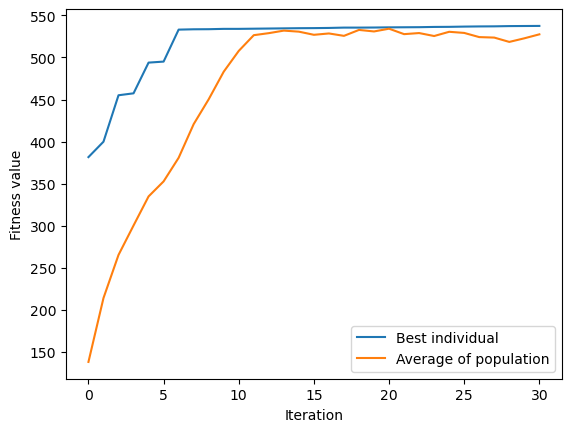

In [8]:

plt.xlabel("Iteration") 
plt.ylabel("Fitness value")

#Average fitness value and the highest fitness value of each generation is plotted
plt.plot(log.select('max'), label="Best individual")
plt.plot(log.select('avg'), label="Average of population")
plt.legend() 
plt.show()

### 2. Performance of GA based on Crossover, mutation and selection operators

In [9]:

# A function for generating -1,0,1 for attribute item
def random_value():
    return random.choice([-1, 0, 1])

#Initializing a dataframe to store the average abf values

#Total number of combinations to test for
combination = ['comb1' , 'comb2', 'comb3', 'comb4', 'comb5', 'comb6' , 'comb7', 'comb8']

NGEN = 30
MU = 300 #The number of individuals to select for the next generation
CXPB = 0.9
MUTPB = 0.05

abf_avg_summarized = pd.DataFrame()

abf_best = {}

# iterating through the elements of list to create a dictionary
for i in combination:
    abf_best[i] = []


#Initializing a array to store the time taken for every combination
time_taken = []

hofs = []

#Running a loop for every different combination
for combo in combination:

    # get the start time
    st = time.time()

    #Intializing a temporary array to store the preliminary average ABF values
    current_computed = []

    #Initializing a array to store all the max values of each generation for every iteration
    best_fitness = []

    #An if statement to check which combination is in progress and runs the following combo

    if combo == 'comb1':
        for i in range(0,30):
            toolbox.register("mate", tools.cxTwoPoint)
            toolbox.register("mutate", tools.mutFlipBit, indpb = 0.2)
            toolbox.register("select", tools.selTournament, tournsize = 4)


            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            hofs.append(hof[-1])

            best_fitness.append(logbook.select('max'))
    
    elif combo == 'comb2':
        for i in range(0,30):

            toolbox.register("mate", tools.cxTwoPoint)
            toolbox.register("mutate", tools.mutFlipBit, indpb = 0.2)
            toolbox.register("select", tools.selRoulette)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))

    elif combo == 'comb3':
        for i in range(0,30):

            toolbox.register("mate", tools.cxTwoPoint)
            toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 0.2)
            toolbox.register("select", tools.selTournament, tournsize = 4)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))

    elif combo == 'comb4':
        for i in range(0,30):

            toolbox.register("mate", tools.cxTwoPoint)
            toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 0.2)
            toolbox.register("select", tools.selRoulette)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))

    elif combo == 'comb5':
        for i in range(0,30):

            toolbox.register("mate", tools.cxOrdered)
            toolbox.register("mutate", tools.mutFlipBit, indpb = 0.2)
            toolbox.register("select", tools.selTournament, tournsize = 4)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))
    
    elif combo == 'comb6':
        for i in range(0,30):

            toolbox.register("mate", tools.cxOrdered)
            toolbox.register("mutate", tools.mutFlipBit, indpb = 0.2)
            toolbox.register("select", tools.selRoulette)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))

    elif combo == 'comb7':
        for i in range(0,30):

            toolbox.register("mate", tools.cxOrdered)
            toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 0.2)
            toolbox.register("select", tools.selTournament, tournsize = 4)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))

    elif combo == 'comb8':
        for i in range(0,30):

            toolbox.register("mate", tools.cxOrdered)
            toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 0.2)
            toolbox.register("select", tools.selRoulette)

            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()

            # The hall of fame contains the best individual that ever lived in the population during the evolution
            # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
            # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

            stats = tools.Statistics(lambda ind: ind.fitness.values)
            # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
            # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and is calculated as the square root of the variance.
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)

            pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats, hof)

            best_fitness.append(logbook.select('max'))

    # get the end time
    et = time.time()

    #Get the execution time for each combination over 30 iterations
    elapsed_time = et - st

    #Appending the time taken
    time_taken.append(elapsed_time)
    
    
    #Calculating the average best fitness value for the current combination
    for i in range(0,30):
        sum1 = 0
        for j in range(0,30):
            sum1 += best_fitness[j][i]
            abf_best[f'{combo}'].append(best_fitness[j][i][0])
        sum1 = sum1 / 30
        current_computed.append(sum1)

    #Appending to the dataframe for plotting
    abf_avg_summarized[f'{combo}'] = current_computed

  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg           	std          	min   	max    
0  	300   	[142.08666667]	[77.56941895]	[-9.7]	[381.9]
1  	278   	[220.40966667]	[67.16945293]	[72.7]	[382.] 
2  	276   	[273.39833333]	[62.19005143]	[27.9]	[399.5]
3  	263   	[304.75033333]	[64.69868237]	[-8.7]	[439.4]
4  	264   	[330.45666667]	[61.96056156]	[11.7]	[439.4]
5  	271   	[357.27]      	[51.29095924]	[119.9]	[439.6]
6  	277   	[364.88066667]	[67.28641388]	[48.2] 	[456.7]
7  	277   	[380.902]     	[65.33792974]	[135.9]	[458.2]
8  	272   	[402.445]     	[57.15457586]	[117.6]	[458.2]
9  	280   	[418.112]     	[46.12084333]	[156.1]	[476.1]
10 	265   	[424.20733333]	[50.85661687]	[119.3]	[493.9]
11 	279   	[429.71866667]	[43.60647259]	[131.1]	[493.9]
12 	279   	[424.227]     	[63.45300233]	[81.]  	[494.5]
13 	273   	[441.35833333]	[56.44815938]	[29.7] 	[494.8]
14 	271   	[454.33733333]	[54.85326371]	[66.7] 	[495.1]
15 	274   	[469.08733333]	[59.84266794]	[73.7] 	[495.1]
16 	269   	[485.49933333]	[39.53429565]	[131.1]	[495.3

  3%|▎         | 1/30 [00:05<02:52,  5.95s/it]

30 	282   	[478.64066667]	[69.06507038]	[88.5] 	[496.7]
gen	nevals	avg           	std          	min    	max    
0  	300   	[139.47633333]	[78.02040763]	[-10.1]	[324.7]
1  	276   	[218.87666667]	[61.54068618]	[48.9] 	[380.7]
2  	280   	[256.93466667]	[59.09406004]	[67.2] 	[400.1]
3  	279   	[284.917]     	[61.86333172]	[95.8] 	[456.5]
4  	272   	[316.01866667]	[65.60917556]	[67.]  	[456.5]
5  	288   	[342.90866667]	[62.41537197]	[51.3] 	[457.3]
6  	263   	[363.009]     	[69.34405251]	[113.9]	[473.8]
7  	276   	[373.69266667]	[85.08736498]	[-8.3] 	[476.9]
8  	272   	[415.54266667]	[63.4303338] 	[137.8]	[473.9]
9  	262   	[425.93166667]	[68.1491269] 	[118.] 	[473.9]
10 	275   	[434.37933333]	[57.45143955]	[101.1]	[473.9]
11 	260   	[434.72766667]	[56.1354879] 	[80.7] 	[475.4]
12 	275   	[430.70733333]	[64.73790141]	[82.3] 	[475.4]
13 	268   	[434.84233333]	[61.54299831]	[87.4] 	[475.6]
14 	277   	[429.405]     	[65.02331896]	[120.9]	[475.8]
15 	281   	[430.479]     	[64.00667459]	[101.2]	

  7%|▋         | 2/30 [00:11<02:45,  5.93s/it]

29 	262   	[462.574]     	[69.77551331]	[11.7] 	[478.6]
30 	268   	[465.44466667]	[61.12228621]	[30.6] 	[478.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[140.57966667]	[80.19160775]	[-10.]	[359.6]
1  	278   	[218.87766667]	[70.39990721]	[9.5] 	[439.7]
2  	283   	[272.63533333]	[68.56492022]	[71.] 	[440.3]
3  	279   	[308.994]     	[69.11593519]	[13.] 	[440.3]
4  	276   	[349.94333333]	[57.5412286] 	[139.]	[455.6]
5  	269   	[369.412]     	[59.9501125] 	[151.1]	[477.2]
6  	263   	[385.60366667]	[72.84876906]	[50.]  	[477.6]
7  	273   	[417.02233333]	[59.17027521]	[80.3] 	[495.5]
8  	267   	[422.72366667]	[71.35000869]	[47.3] 	[495.5]
9  	270   	[439.00533333]	[72.6703491] 	[80.1] 	[515.4]
10 	262   	[449.37133333]	[73.15676668]	[29.1] 	[515.8]
11 	259   	[451.112]     	[73.91914044]	[96.7] 	[515.8]
12 	272   	[459.51]      	[72.82046988]	[101.9]	[516.1]
13 	276   	[468.42433333]	[67.89281288]	[101.9]	[534.3]
14 	266   	[468.10066667]	[76.87687385]	[66.4] 	[534.6

 10%|█         | 3/30 [00:19<02:58,  6.62s/it]

30 	274   	[517.37233333]	[78.98129315]	[79.1] 	[535.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[142.83666667]	[83.64839781]	[-10.1]	[399.8]
1  	274   	[220.609]     	[60.87504321]	[68.1] 	[398.3]
2  	268   	[256.009]     	[59.35047896]	[10.3] 	[381.8]
3  	263   	[290.64866667]	[61.96093042]	[31.]  	[400.1]
4  	262   	[322.00833333]	[59.46130644]	[11.2] 	[457.8]
5  	280   	[334.15233333]	[64.64065976]	[119.8]	[438.7]
6  	268   	[358.012]     	[58.95862438]	[80.1] 	[437.6]
7  	279   	[372.85633333]	[61.56774854]	[50.]  	[439.7]
8  	267   	[379.559]     	[62.26379702]	[48.7] 	[457.6]
9  	276   	[391.11733333]	[56.64092366]	[80.8] 	[458.2]
10 	276   	[399.846]     	[61.97625688]	[100.9]	[475.6]
11 	278   	[415.517]     	[55.67229243]	[121.5]	[475.9]
12 	264   	[423.14666667]	[54.49566792]	[168.1]	[513.4]
13 	267   	[429.43]      	[60.86996441]	[68.]  	[476.] 
14 	270   	[442.02066667]	[44.42260955]	[72.7] 	[495.5]
15 	274   	[440.07133333]	[51.31011185]	[149.6]	

 13%|█▎        | 4/30 [00:25<02:42,  6.26s/it]

29 	271   	[523.665]     	[53.81190025]	[107.7]	[535.] 
30 	268   	[523.49666667]	[58.43588899]	[74.]  	[535.1]
gen	nevals	avg           	std          	min    	max   
0  	300   	[151.73366667]	[81.83909029]	[-10.7]	[362.]
1  	277   	[222.29966667]	[66.60633528]	[11.5] 	[400.9]
2  	263   	[265.13866667]	[63.30507382]	[67.5] 	[401.5]
3  	272   	[301.97033333]	[66.79835592]	[-9.2] 	[438.9]
4  	267   	[330.924]     	[69.58835696]	[49.1] 	[439.2]
5  	270   	[365.715]     	[60.06371846]	[11.2] 	[439.6]
6  	270   	[381.072]     	[52.34617798]	[11.6] 	[439.9]
7  	283   	[375.92533333]	[59.58383191]	[67.8] 	[439.9]
8  	271   	[386.96966667]	[55.11598117]	[105.8]	[440.6]
9  	261   	[394.179]     	[60.73450523]	[87.3] 	[440.5]
10 	271   	[397.409]     	[60.55861419]	[124.9]	[440.9]
11 	272   	[408.66433333]	[59.13079706]	[29.4] 	[441.1]
12 	273   	[411.92066667]	[52.92012257]	[149.9]	[441.1]
13 	290   	[404.68066667]	[68.72441313]	[49.8] 	[456.2]
14 	271   	[408.14866667]	[68.52917553]	[91.4] 	[4

 17%|█▋        | 5/30 [00:29<02:24,  5.79s/it]

29 	275   	[424.315]     	[63.16228048]	[100.1]	[477.9]
30 	274   	[423.017]     	[69.71535755]	[70.]  	[478.1]
gen	nevals	avg      	std          	min    	max    
0  	300   	[146.248]	[83.22988023]	[-10.3]	[381.7]
1  	265   	[221.76566667]	[70.94629416]	[30.6] 	[382.1]
2  	255   	[274.85566667]	[65.13596601]	[-8.3] 	[382.3]
3  	265   	[306.286]     	[60.99561682]	[109.9]	[476.2]
4  	268   	[327.68066667]	[63.72803799]	[98.5] 	[475.4]
5  	274   	[344.75266667]	[62.37817535]	[68.7] 	[475.] 
6  	288   	[356.483]     	[68.11371823]	[31.8] 	[474.9]
7  	266   	[372.63666667]	[65.50801571]	[69.5] 	[475.4]
8  	283   	[380.37433333]	[66.768739]  	[68.9] 	[476.4]
9  	266   	[392.72266667]	[62.67032008]	[81.3] 	[440.3]
10 	265   	[407.75233333]	[51.20580268]	[101.7]	[474.9]
11 	277   	[411.26266667]	[55.459735]  	[73.3] 	[495.8]
12 	279   	[422.94866667]	[47.81246314]	[157.1]	[495.8]
13 	269   	[420.29866667]	[67.26045444]	[81.1] 	[515.7]
14 	262   	[424.86933333]	[62.91231246]	[81.5] 	[515.9]
15

 20%|██        | 6/30 [00:36<02:23,  5.97s/it]

30 	270   	[513.30066667]	[82.76469738] 	[139.5]	[535.4]
gen	nevals	avg      	std          	min    	max    
0  	300   	[149.194]	[79.99548006]	[-10.6]	[399.3]
1  	271   	[224.25466667]	[65.07274758]	[80.8] 	[401.8]
2  	272   	[271.407]     	[66.62729159]	[9.4]  	[399.4]
3  	263   	[315.56]      	[60.03615966]	[28.9] 	[437.2]
4  	283   	[338.794]     	[62.97398006]	[10.9] 	[456.9]
5  	279   	[363.32133333]	[62.35306791]	[80.1] 	[457.7]
6  	272   	[380.088]     	[64.76115237]	[87.2] 	[494.6]
7  	269   	[381.55266667]	[72.97901314]	[99.4] 	[475.2]
8  	261   	[386.902]     	[83.69344456]	[92.5] 	[512.3]
9  	276   	[401.08166667]	[78.99872381]	[81.7] 	[512.8]
10 	264   	[411.008]     	[82.03050369]	[86.4] 	[513.] 
11 	276   	[434.91933333]	[69.46239625]	[106.9]	[513.5]
12 	268   	[456.02233333]	[71.70749148]	[89.3] 	[532.9]
13 	276   	[482.83966667]	[60.59372019]	[144.4]	[514.2]
14 	270   	[496.71533333]	[53.65049703]	[100.3]	[533.8]
15 	268   	[495.805]     	[62.09090332]	[176.6]	[533.8]
1

 23%|██▎       | 7/30 [00:43<02:23,  6.22s/it]

29 	272   	[517.263]     	[69.72571786]	[48.5] 	[536.] 
30 	273   	[514.72533333]	[74.41094381]	[101.4]	[536.1]
gen	nevals	avg      	std          	min    	max   
0  	300   	[147.877]	[84.65689835]	[-10.3]	[420.]
1  	283   	[224.05566667]	[70.64885751]	[27.8] 	[457.7]
2  	273   	[281.16566667]	[67.75350855]	[45.9] 	[457.9]
3  	277   	[312.616]     	[66.67554582]	[48.]  	[457.9]
4  	266   	[347.84566667]	[62.86195204]	[87.4] 	[532.5]
5  	277   	[374.908]     	[69.35222229]	[49.5] 	[532.5]
6  	265   	[405.13633333]	[62.07007368]	[68.1] 	[532.8]
7  	263   	[424.48433333]	[66.48100471]	[69.6] 	[532.9]
8  	280   	[424.72466667]	[80.22946586]	[69.3] 	[533.] 
9  	271   	[432.89666667]	[67.83635595]	[87.2] 	[533.4]
10 	273   	[424.49733333]	[86.18929628]	[87.8] 	[533.4]
11 	281   	[432.01866667]	[90.51766965]	[81.2] 	[533.4]
12 	255   	[466.172]     	[79.24777441]	[105.8]	[534.1]
13 	269   	[493.77466667]	[90.57692803]	[72.2] 	[534.3]
14 	258   	[507.77]      	[78.25821767]	[81.1] 	[534.2]
15 	

 27%|██▋       | 8/30 [00:49<02:19,  6.32s/it]

30 	266   	[523.16633333]	[62.05349063] 	[93.]  	[535.6]
gen	nevals	avg      	std          	min   	max    
0  	300   	[145.279]	[79.57833327]	[-10.]	[381.9]
1  	262   	[227.47233333]	[65.83164741]	[47.3]	[400.9]
2  	282   	[276.74133333]	[63.73022118]	[80.4]	[400.4]
3  	266   	[317.662]     	[56.72891523]	[99.6]	[420.1]
4  	270   	[336.64533333]	[61.79553715]	[29.6]	[437.7]
5  	281   	[350.34733333]	[63.8676138] 	[76.8]	[457.9]
6  	269   	[362.064]     	[64.32195973]	[81.3]	[457.9]
7  	285   	[365.66633333]	[70.88971599]	[30.7]	[439.6]
8  	265   	[369.983]     	[73.43963152]	[66.] 	[439.6]
9  	275   	[386.79866667]	[65.74740957]	[101.2]	[439.6]
10 	264   	[406.995]     	[56.23699739]	[48.]  	[456.8]
11 	275   	[409.53533333]	[58.90571408]	[9.2]  	[457.] 
12 	269   	[406.48433333]	[60.02121892]	[88.2] 	[457.7]
13 	272   	[410.33533333]	[58.141598]  	[-7.7] 	[457.7]
14 	276   	[415.697]     	[51.60308606]	[105.7]	[458.3]
15 	258   	[418.714]     	[62.22925253]	[49.1] 	[458.2]
16 	255   	

 30%|███       | 9/30 [00:55<02:10,  6.22s/it]

30 	280   	[486.665]     	[56.33614714]	[73.9] 	[498.1]
gen	nevals	avg      	std          	min    	max    
0  	300   	[138.997]	[77.88597493]	[-10.2]	[379.6]
1  	274   	[206.83] 	[64.77749944]	[9.5]  	[379.6]
2  	272   	[256.97566667]	[52.42771253]	[95.5] 	[400.3]
3  	278   	[279.854]     	[62.00576815]	[29.7] 	[437.] 
4  	267   	[299.27133333]	[71.29856692]	[11.6] 	[438.2]
5  	277   	[322.36533333]	[79.55131885]	[29.2] 	[477.5]
6  	269   	[336.50833333]	[76.89590213]	[-7.7] 	[477.3]
7  	266   	[363.17033333]	[67.33765182]	[101.3]	[477.1]
8  	274   	[382.19333333]	[69.2508158] 	[68.4] 	[493.5]
9  	267   	[388.09466667]	[88.28047333]	[-9.]  	[534.] 
10 	270   	[410.528]     	[72.18871252]	[136.4]	[533.7]
11 	272   	[416.61666667]	[77.99206064]	[138.2]	[533.7]
12 	266   	[435.442]     	[79.28961073]	[-7.9] 	[532.9]
13 	269   	[456.31166667]	[74.55819582]	[66.8] 	[534.4]
14 	284   	[477.39866667]	[65.34659337]	[119.8]	[534.5]
15 	259   	[493.65133333]	[66.39261428]	[100.7]	[534.5]
16 	276

 33%|███▎      | 10/30 [01:02<02:07,  6.36s/it]

29 	259   	[523.48633333]	[66.67951394]	[31.1] 	[536.4]
30 	274   	[514.03566667]	[87.184836]  	[30.8] 	[536.4]
gen	nevals	avg           	std          	min  	max    
0  	300   	[147.12033333]	[80.03537022]	[-9.]	[359.4]
1  	260   	[219.48333333]	[67.6100756] 	[8.5]	[382.1]
2  	274   	[268.09633333]	[65.76341399]	[67.4]	[419.9]
3  	264   	[306.32133333]	[56.30263059]	[101.1]	[419.9]
4  	268   	[321.47966667]	[67.65271726]	[100.4]	[475.3]
5  	270   	[346.79766667]	[65.51609544]	[98.1] 	[475.3]
6  	276   	[366.29266667]	[58.51684042]	[165.8]	[494.6]
7  	266   	[378.64333333]	[67.46205444]	[11.5] 	[494.6]
8  	276   	[385.691]     	[75.7936353] 	[102.1]	[494.9]
9  	265   	[403.00733333]	[67.92349971]	[139.6]	[495.5]
10 	258   	[411.58666667]	[85.05885231]	[48.6] 	[495.5]
11 	267   	[444.202]     	[78.41452456]	[9.5]  	[496.2]
12 	273   	[470.43833333]	[77.54591348]	[28.9] 	[514.1]
13 	264   	[486.72766667]	[41.38994646]	[162.9]	[533.9]
14 	262   	[483.80233333]	[58.52231279]	[11.2] 	[534.2]

 37%|███▋      | 11/30 [01:08<02:01,  6.42s/it]

30 	275   	[518.77166667]	[73.41548359]	[74.]  	[536.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[141.73566667]	[81.92434698]	[-10.2]	[418.5]
1  	272   	[218.991]     	[70.96049196]	[49.6] 	[418.1]
2  	280   	[266.09766667]	[64.16113383]	[81.4] 	[418.7]
3  	259   	[293.34833333]	[66.26395926]	[50.9] 	[418.5]
4  	261   	[315.52933333]	[69.2189045] 	[76.1] 	[438.2]
5  	276   	[344.52266667]	[63.02473075]	[144.9]	[513.2]
6  	274   	[358.75]      	[71.85226904]	[97.]  	[532.8]
7  	273   	[371.955]     	[75.8577406] 	[101.] 	[532.9]
8  	279   	[392.561]     	[73.9540126] 	[90.2] 	[532.9]
9  	279   	[404.914]     	[74.48133147]	[80.8] 	[532.7]
10 	275   	[421.12]      	[75.87083673]	[92.4] 	[533.7]
11 	267   	[438.83566667]	[77.02969835]	[99.7] 	[533.7]
12 	270   	[449.89066667]	[94.7079531] 	[67.7] 	[533.9]
13 	261   	[485.59833333]	[88.59056701]	[72.1] 	[533.9]
14 	281   	[491.25466667]	[106.18331638]	[80.7] 	[534.] 
15 	273   	[494.61533333]	[102.54447343]	[66.8]

 40%|████      | 12/30 [01:15<01:58,  6.58s/it]

29 	278   	[517.37633333]	[79.77267247] 	[83.1] 	[536.3]
30 	262   	[512.12633333]	[91.73192832] 	[75.4] 	[536.3]
gen	nevals	avg      	std          	min    	max    
0  	300   	[142.445]	[77.98171244]	[-10.4]	[377.5]
1  	267   	[202.74733333]	[58.60843079]	[-9.]  	[377.5]
2  	279   	[245.56566667]	[63.28318777]	[-7.4] 	[400.] 
3  	274   	[289.56633333]	[59.90126125]	[69.3] 	[400.8]
4  	245   	[317.51833333]	[65.20549796]	[29.9] 	[438.3]
5  	280   	[344.53733333]	[69.76385841]	[48.2] 	[475.3]
6  	270   	[362.81766667]	[67.75059351]	[81.7] 	[457.4]
7  	270   	[373.35966667]	[69.81250513]	[100.9]	[458.1]
8  	277   	[383.89933333]	[74.23097691]	[100.2]	[495.1]
9  	256   	[391.674]     	[78.57090762]	[100.5]	[458.2]
10 	275   	[403.50066667]	[85.76488442]	[31.9] 	[513.7]
11 	270   	[413.66233333]	[81.98260637]	[87.]  	[533.8]
12 	271   	[424.70833333]	[79.38625509]	[67.8] 	[533.8]
13 	265   	[434.855]     	[79.94886079]	[77.]  	[533.8]
14 	268   	[448.995]     	[83.99186632]	[49.5] 	[533.9]


 43%|████▎     | 13/30 [01:22<01:50,  6.52s/it]

29 	276   	[523.083]     	[61.10122485]	[78.2] 	[536.1]
30 	269   	[519.134]     	[72.96094236]	[87.7] 	[536.2]
gen	nevals	avg           	std          	min   	max    
0  	300   	[138.40666667]	[76.31494364]	[-9.9]	[361.1]
1  	273   	[203.11533333]	[67.58752818]	[28.5]	[363.9]
2  	273   	[252.29266667]	[62.62623582]	[28.8]	[363.9]
3  	282   	[286.47266667]	[59.7619588] 	[80.8]	[401.6]
4  	269   	[313.52333333]	[58.30135666]	[49.7]	[417.] 
5  	274   	[324.88933333]	[65.59441099]	[80.3]	[439.7]
6  	266   	[347.86866667]	[60.3735236] 	[82.2]	[475.1]
7  	274   	[359.86833333]	[58.72561704]	[157.1]	[475.1]
8  	258   	[373.95533333]	[66.28208761]	[50.]  	[457.6]
9  	267   	[387.119]     	[60.67386812]	[87.]  	[458.] 
10 	276   	[392.813]     	[71.14093757]	[80.9] 	[494.9]
11 	270   	[402.65266667]	[73.7148327] 	[50.8] 	[495.7]
12 	276   	[416.48166667]	[69.38768068]	[51.]  	[515.2]
13 	274   	[417.20233333]	[83.2059663] 	[11.9] 	[515.3]
14 	260   	[442.87666667]	[72.82184372]	[47.8] 	[515.5]


 47%|████▋     | 14/30 [01:28<01:45,  6.58s/it]

30 	267   	[495.62]      	[78.16031133]	[11.7] 	[518.3]
gen	nevals	avg      	std          	min   	max    
0  	300   	[151.052]	[78.22980312]	[-9.9]	[389.8]
1  	260   	[228.631]	[66.38828967]	[80.8]	[400.2]
2  	284   	[279.70633333]	[70.65999995]	[11.3]	[475.] 
3  	255   	[323.29633333]	[62.19460336]	[79.5]	[475.] 
4  	268   	[337.97533333]	[68.26317986]	[80.7]	[439.6]
5  	274   	[360.189]     	[63.652452]  	[80.4]	[439.8]
6  	265   	[377.388]     	[63.61682211]	[81.2]	[495.1]
7  	271   	[393.05533333]	[61.04132375]	[28.8]	[495.1]
8  	280   	[399.61566667]	[59.92465537]	[85.8]	[494.] 
9  	264   	[401.38833333]	[68.36795909]	[66.7]	[494.] 
10 	281   	[394.77733333]	[73.72943116]	[100.6]	[494.] 
11 	284   	[400.84466667]	[73.33738477]	[68.8] 	[515.1]
12 	274   	[413.51866667]	[64.76299395]	[101.1]	[515.1]
13 	277   	[426.75433333]	[70.08784166]	[101.1]	[514.3]
14 	290   	[442.58833333]	[71.23457094]	[82.6] 	[515.5]
15 	273   	[461.91766667]	[67.43929953]	[69.1] 	[516.1]
16 	261   	[474.96

 50%|█████     | 15/30 [01:35<01:39,  6.61s/it]

30 	270   	[502.31033333]	[63.7809067] 	[78.5] 	[517.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[153.53666667]	[80.28741198]	[-10.2]	[419.3]
1  	273   	[216.204]     	[66.41527373]	[29.4] 	[418.7]
2  	265   	[269.107]     	[54.97810338]	[106.6]	[440.4]
3  	266   	[300.98166667]	[59.86574338]	[-8.]  	[440.4]
4  	273   	[320.45933333]	[66.45421993]	[11.6] 	[440.5]
5  	266   	[337.42233333]	[69.99239864]	[80.9] 	[440.5]
6  	281   	[360.191]     	[71.49291726]	[67.3] 	[456.5]
7  	263   	[378.713]     	[75.47042112]	[49.9] 	[457.7]
8  	264   	[390.192]     	[69.2368717] 	[12.2] 	[458.2]
9  	259   	[379.50866667]	[84.72750159]	[80.8] 	[494.8]
10 	283   	[390.30533333]	[80.20547262]	[31.5] 	[533.3]
11 	280   	[419.61333333]	[61.90765237]	[158.] 	[533.4]
12 	262   	[416.87333333]	[79.95700609]	[120.7]	[533.8]
13 	270   	[442.52966667]	[67.91160642]	[110.9]	[533.8]
14 	274   	[471.68333333]	[64.8965612] 	[157.1]	[533.8]
15 	279   	[491.40933333]	[64.48857868]	[87.5] 	

 53%|█████▎    | 16/30 [01:42<01:32,  6.62s/it]

30 	273   	[524.16833333]	[57.4872116] 	[32.3] 	[535.4]
gen	nevals	avg           	std          	min    	max    
0  	300   	[143.13366667]	[79.53718522]	[-10.6]	[362.2]
1  	275   	[209.32233333]	[67.03681328]	[11.2] 	[380.3]
2  	272   	[258.33333333]	[62.79492354]	[11.]  	[438.1]
3  	273   	[287.81833333]	[64.42788188]	[96.9] 	[438.2]
4  	282   	[312.302]     	[62.14377842]	[80.1] 	[439.5]
5  	262   	[323.505]     	[74.76137243]	[65.7] 	[439.5]
6  	275   	[355.405]     	[71.84283315]	[79.7] 	[475.1]
7  	275   	[361.18066667]	[87.4419813] 	[29.6] 	[475.2]
8  	270   	[389.15033333]	[70.44877595]	[119.1]	[475.3]
9  	275   	[414.01866667]	[61.34868364]	[91.7] 	[495.4]
10 	252   	[420.822]     	[73.6130662] 	[80.5] 	[514.6]
11 	270   	[451.08166667]	[47.94888074]	[205.3]	[514.8]
12 	271   	[450.28166667]	[72.11582141]	[68.4] 	[515.2]
13 	281   	[460.26966667]	[67.97331717]	[71.9] 	[516.1]
14 	268   	[473.494]     	[74.87702071]	[29.8] 	[532.8]
15 	276   	[490.69133333]	[71.71087731]	[51.2] 	

 57%|█████▋    | 17/30 [01:48<01:25,  6.57s/it]

29 	275   	[522.96633333]	[59.05469809]	[69.8] 	[535.1]
30 	272   	[528.69833333]	[41.45468084]	[180.7]	[535.1]
gen	nevals	avg           	std          	min    	max    
0  	300   	[148.68966667]	[80.06448064]	[-10.3]	[362.2]
1  	276   	[220.155]     	[67.63272636]	[47.1] 	[401.2]
2  	261   	[271.547]     	[66.79754605]	[29.9] 	[437.8]
3  	270   	[304.29733333]	[72.06723245]	[-7.9] 	[438.] 
4  	279   	[338.29233333]	[65.91638017]	[11.1] 	[438.2]
5  	277   	[351.80666667]	[71.06447042]	[49.3] 	[438.4]
6  	272   	[376.94466667]	[58.43127192]	[50.2] 	[438.4]
7  	266   	[388.216]     	[68.06658562]	[-8.1] 	[455.3]
8  	270   	[408.18133333]	[72.70977824]	[-9.]  	[473.4]
9  	270   	[419.26]      	[55.15981569]	[47.6] 	[473.4]
10 	281   	[420.62466667]	[60.02769687]	[10.]  	[473.5]
11 	284   	[418.05566667]	[60.97258292]	[-8.2] 	[473.8]
12 	279   	[425.82133333]	[49.61295877]	[66.5] 	[473.8]
13 	272   	[426.083]     	[51.97148011]	[50.1] 	[474.3]
14 	277   	[408.268]     	[80.86424494]	[-7.9] 	

 60%|██████    | 18/30 [01:54<01:17,  6.50s/it]

30 	278   	[478.34133333]	[74.06816787]	[-7.7] 	[495.9]
gen	nevals	avg      	std          	min    	max    
0  	300   	[142.582]	[81.91542799]	[-10.7]	[363.8]
1  	276   	[221.26166667]	[64.44747032]	[65.6] 	[399.8]
2  	272   	[264.502]     	[65.36723029]	[10.4] 	[398.9]
3  	279   	[300.45333333]	[58.22846574]	[100.2]	[400.2]
4  	272   	[326.44733333]	[62.0199728] 	[69.2] 	[437.4]
5  	262   	[336.66133333]	[65.96873127]	[28.9] 	[437.4]
6  	281   	[355.78966667]	[62.85020705]	[72.6] 	[438.4]
7  	268   	[373.05133333]	[60.52841783]	[101.8]	[456.8]
8  	275   	[388.92333333]	[56.54397099]	[92.5] 	[457.4]
9  	273   	[399.028]     	[58.04156456]	[-7.8] 	[457.7]
10 	275   	[411.927]     	[55.13156662]	[97.2] 	[457.7]
11 	275   	[424.026]     	[60.62976819]	[109.8]	[458.1]
12 	276   	[436.74366667]	[53.7380752] 	[176.6]	[458.1]
13 	275   	[440.999]     	[52.47939118]	[87.]  	[458.3]
14 	267   	[437.117]     	[62.72049488]	[67.3] 	[458.5]
15 	272   	[430.345]     	[72.44214663]	[11.4] 	[458.7]
16

 63%|██████▎   | 19/30 [02:00<01:06,  6.07s/it]

29 	276   	[435.24266667]	[67.96409478]	[139.4]	[460.9]
30 	280   	[437.715]     	[65.98276953]	[50.7] 	[461.] 
gen	nevals	avg      	std          	min   	max    
0  	300   	[138.968]	[82.05800942]	[-10.]	[363.7]
1  	281   	[220.30233333]	[67.62525338]	[76.1]	[399.8]
2  	256   	[269.65566667]	[65.15279325]	[94.1]	[400.9]
3  	276   	[300.53433333]	[72.30272416]	[28.9]	[419.9]
4  	272   	[325.60833333]	[62.64000769]	[101.1]	[419.9]
5  	265   	[340.58933333]	[65.53803898]	[69.1] 	[438.9]
6  	269   	[358.324]     	[63.51066858]	[29.3] 	[439.5]
7  	274   	[377.53333333]	[56.67646151]	[80.3] 	[455.9]
8  	269   	[393.02533333]	[54.04258406]	[130.] 	[455.9]
9  	275   	[406.15366667]	[54.69138281]	[72.6] 	[456.] 
10 	272   	[414.15133333]	[59.98893647]	[98.3] 	[456.] 
11 	261   	[423.968]     	[47.29412976]	[87.3] 	[456.4]
12 	272   	[420.624]     	[55.02783257]	[101.3]	[456.4]
13 	262   	[416.72766667]	[57.08913558]	[106.8]	[456.5]
14 	262   	[417.84966667]	[60.45586021]	[49.4] 	[457.] 
15 	280

 67%|██████▋   | 20/30 [02:05<00:59,  5.94s/it]

gen	nevals	avg           	std          	min    	max    
0  	300   	[145.13366667]	[78.87596867]	[-10.4]	[400.4]
1  	273   	[222.377]     	[64.55962596]	[29.5] 	[400.4]
2  	265   	[268.69466667]	[59.50028772]	[65.5] 	[400.6]
3  	275   	[297.114]     	[61.55638394]	[80.9] 	[419.6]
4  	274   	[318.00466667]	[71.28395129]	[81.1] 	[438.4]
5  	263   	[360.19066667]	[58.03388188]	[101.2]	[438.7]
6  	272   	[393.55466667]	[43.01593362]	[96.]  	[439.7]
7  	271   	[407.767]     	[41.36543095]	[88.6] 	[457.7]
8  	279   	[410.60766667]	[50.27111272]	[80.7] 	[458.4]
9  	279   	[414.95833333]	[50.09210614]	[122.] 	[458.5]
10 	273   	[424.74866667]	[58.53769297]	[111.9]	[459.] 
11 	265   	[439.61866667]	[42.54863082]	[90.4] 	[459.2]
12 	284   	[445.49233333]	[45.74275653]	[139.8]	[459.4]
13 	274   	[441.80666667]	[55.45143781]	[105.2]	[459.6]
14 	278   	[444.75733333]	[57.14242072]	[108.3]	[460.] 
15 	277   	[449.60966667]	[50.30564985]	[82.1] 	[460.1]
16 	274   	[449.964]     	[47.79850525]	[121.4]	

 70%|███████   | 21/30 [02:10<00:50,  5.63s/it]

30 	280   	[446.75733333]	[66.03807825]	[75.]  	[462.1]
gen	nevals	avg           	std          	min    	max   
0  	300   	[146.13666667]	[75.31992779]	[-10.3]	[344.]
1  	269   	[213.60666667]	[67.85933359]	[8.6]  	[398.8]
2  	278   	[261.38966667]	[70.50620724]	[68.6] 	[418.2]
3  	274   	[298.70033333]	[65.72785127]	[67.3] 	[457.8]
4  	267   	[324.552]     	[67.13691505]	[31.6] 	[457.8]
5  	269   	[349.189]     	[67.07618091]	[11.5] 	[457.9]
6  	275   	[354.71766667]	[79.27636757]	[80.1] 	[458.] 
7  	278   	[364.31966667]	[73.86219723]	[50.4] 	[458.4]
8  	269   	[373.653]     	[73.62448251]	[120.] 	[458.9]
9  	274   	[378.24333333]	[81.83896865]	[87.5] 	[515.2]
10 	275   	[400.34466667]	[69.51676156]	[157.3]	[533.2]
11 	273   	[407.79433333]	[81.36714489]	[81.1] 	[533.5]
12 	271   	[426.91333333]	[66.38118425]	[166.7]	[533.5]
13 	269   	[425.08733333]	[79.667134]  	[107.8]	[534.5]
14 	275   	[419.43866667]	[86.97977641]	[120.5]	[534.4]
15 	277   	[432.948]     	[91.56170395]	[29.5] 	[5

 73%|███████▎  | 22/30 [02:16<00:46,  5.82s/it]

30 	279   	[522.42566667]	[63.18241402]	[117.8]	[536.1]
gen	nevals	avg           	std          	min    	max    
0  	300   	[139.32233333]	[81.57269356]	[-10.1]	[420.5]
1  	286   	[211.75533333]	[69.3893657] 	[8.8]  	[420.5]
2  	279   	[260.22866667]	[64.37244269]	[68.4] 	[420.5]
3  	268   	[301.74433333]	[72.52569706]	[-8.7] 	[439.4]
4  	285   	[344.18]      	[76.77142784]	[-8.]  	[440.] 
5  	261   	[380.52333333]	[66.61129325]	[98.1] 	[456.7]
6  	258   	[404.54]      	[52.06914697]	[11.3] 	[458.1]
7  	288   	[406.52366667]	[51.23881543]	[100.4]	[476.5]
8  	263   	[414.32566667]	[56.08481233]	[11.]  	[476.6]
9  	273   	[421.369]     	[59.22657516]	[11.8] 	[476.7]
10 	272   	[434.50366667]	[55.70598849]	[11.3] 	[476.7]
11 	276   	[435.106]     	[65.05896529]	[11.9] 	[476.8]
12 	276   	[437.30533333]	[58.28840112]	[12.2] 	[477.] 
13 	283   	[437.224]     	[73.08437925]	[-8.6] 	[477.] 
14 	271   	[459.005]     	[50.79283619]	[99.9] 	[477.3]
15 	271   	[458.62133333]	[64.61837467]	[-7.7] 	

 77%|███████▋  | 23/30 [02:23<00:42,  6.00s/it]

30 	282   	[455.902]     	[81.04745891]	[-6.5] 	[479.] 
gen	nevals	avg           	std          	min   	max    
0  	300   	[146.74366667]	[80.35687272]	[-9.8]	[380.5]
1  	279   	[222.41766667]	[69.85026644]	[11.2]	[438.4]
2  	276   	[275.36433333]	[64.25553383]	[81.2]	[417.1]
3  	275   	[303.14533333]	[70.72732955]	[-9.1]	[419.2]
4  	279   	[339.69833333]	[59.62574134]	[10.4]	[435.9]
5  	262   	[357.446]     	[59.38463396]	[80.3]	[456.8]
6  	276   	[362.94433333]	[66.60393082]	[82.2]	[456.2]
7  	272   	[380.669]     	[63.00910415]	[31.2]	[456.9]
8  	275   	[398.71233333]	[53.12312693]	[120.6]	[474.9]
9  	273   	[408.57533333]	[61.72273858]	[30.3] 	[472.8]
10 	259   	[415.61766667]	[59.35503282]	[66.4] 	[457.2]
11 	268   	[421.87066667]	[50.27657446]	[79.9] 	[472.9]
12 	282   	[424.66766667]	[63.39827117]	[30.5] 	[474.8]
13 	272   	[442.91666667]	[36.82839017]	[138.5]	[474.8]
14 	275   	[441.64933333]	[52.23543273]	[72.4] 	[492.7]
15 	270   	[437.496]     	[62.58868628]	[67.2] 	[492.8]
1

 80%|████████  | 24/30 [02:29<00:35,  5.96s/it]

29 	267   	[483.17066667]	[57.92833221]	[29.7] 	[496.] 
30 	266   	[481.11766667]	[61.84175225]	[131.3]	[496.] 
gen	nevals	avg      	std          	min   	max    
0  	300   	[148.942]	[82.25300543]	[-9.9]	[356.9]
1  	269   	[226.84] 	[65.80739472]	[48.8]	[401.3]
2  	266   	[261.172]	[72.21310418]	[47.8]	[401.6]
3  	271   	[311.33933333]	[65.88913355]	[99.1]	[455.9]
4  	271   	[340.929]     	[70.38950532]	[-8.6]	[456.6]
5  	270   	[362.43266667]	[59.96538557]	[79.5]	[457.8]
6  	259   	[372.702]     	[66.7227662] 	[29.7]	[457.8]
7  	281   	[389.437]     	[63.60031759]	[67.6]	[494.9]
8  	252   	[407.794]     	[64.87139815]	[66.5]	[495.4]
9  	278   	[424.423]     	[56.73110526]	[104.3]	[495.4]
10 	265   	[429.19533333]	[58.40694232]	[137.2]	[495.2]
11 	271   	[429.18666667]	[60.6681357] 	[99.3] 	[495.4]
12 	275   	[430.346]     	[67.71774817]	[139.4]	[495.4]
13 	273   	[436.652]     	[60.18703096]	[124.3]	[495.6]
14 	277   	[428.259]     	[74.72625433]	[73.]  	[495.7]
15 	265   	[431.758333

 83%|████████▎ | 25/30 [02:35<00:29,  5.94s/it]

29 	273   	[517.39733333]	[71.03616023]	[122.7]	[535.4]
30 	270   	[521.58833333]	[60.98845872]	[73.3] 	[535.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[149.30933333]	[78.14529531]	[-9.6]	[420.3]
1  	266   	[218.24066667]	[67.44220696]	[10.9]	[420.3]
2  	276   	[261.48966667]	[64.69686231]	[86.1]	[476.4]
3  	286   	[307.835]     	[65.11959005]	[98.9]	[476.4]
4  	277   	[339.38933333]	[76.46698429]	[80.1]	[476.3]
5  	279   	[373.46]      	[63.05515998]	[138.]	[477.2]
6  	276   	[392.09333333]	[61.84958223]	[86.9]	[515.] 
7  	274   	[404.43433333]	[63.21219124]	[129.5]	[515.] 
8  	264   	[424.072]     	[72.92049197]	[80.4] 	[515.] 
9  	266   	[451.331]     	[62.28787848]	[118.7]	[515.] 
10 	273   	[466.45033333]	[52.30421621]	[106.4]	[515.] 
11 	263   	[473.395]     	[37.3805521] 	[205.3]	[515.2]
12 	284   	[479.75466667]	[48.36006009]	[158.5]	[515.6]
13 	263   	[492.67366667]	[61.0262425] 	[120.1]	[515.9]
14 	267   	[492.172]     	[72.65174338]	[120.6]	[516.2]


 87%|████████▋ | 26/30 [02:41<00:24,  6.11s/it]

30 	260   	[505.886]     	[63.0847758] 	[82.7] 	[518.5]
gen	nevals	avg           	std          	min    	max    
0  	300   	[149.43566667]	[83.86052048]	[-10.3]	[399.3]
1  	269   	[232.05233333]	[71.37376288]	[29.]  	[438.2]
2  	282   	[278.89666667]	[75.04389952]	[80.9] 	[457.9]
3  	260   	[334.14033333]	[67.94641619]	[138.1]	[457.9]
4  	271   	[377.92266667]	[68.14476076]	[106.6]	[457.9]
5  	268   	[410.273]     	[53.81307435]	[157.] 	[458.2]
6  	272   	[419.39166667]	[67.14880612]	[50.1] 	[458.2]
7  	270   	[425.947]     	[67.61865441]	[106.2]	[458.3]
8  	276   	[428.31366667]	[71.67312918]	[84.4] 	[458.4]
9  	256   	[430.439]     	[70.90197538]	[119.9]	[458.5]
10 	275   	[436.74366667]	[63.98803893]	[126.] 	[458.7]
11 	255   	[437.26833333]	[66.34472923]	[86.7] 	[458.9]
12 	272   	[441.35866667]	[58.4684179] 	[166.7]	[459.] 
13 	263   	[435.47566667]	[73.3493811] 	[69.9] 	[459.2]
14 	271   	[439.882]     	[66.80433626]	[135.7]	[459.4]
15 	269   	[440.18533333]	[67.84041754]	[85.5] 	

 90%|█████████ | 27/30 [02:46<00:17,  5.85s/it]

30 	275   	[446.32433333]	[60.82410411]	[84.1] 	[461.5]
gen	nevals	avg      	std          	min   	max    
0  	300   	[146.536]	[82.52383315]	[-9.1]	[380.3]
1  	270   	[224.41033333]	[70.83919955]	[47.7]	[457.8]
2  	280   	[265.52]      	[71.87564724]	[31.5]	[458.2]
3  	268   	[308.57433333]	[64.88692812]	[65.7]	[514.] 
4  	280   	[323.90766667]	[67.38825101]	[47.6]	[457.1]
5  	271   	[337.055]     	[68.58213039]	[82.2]	[477.7]
6  	270   	[354.62566667]	[66.39745006]	[116.]	[477.7]
7  	273   	[359.41466667]	[78.35060935]	[80.9]	[477.7]
8  	268   	[379.45633333]	[76.11620454]	[32.8]	[478.] 
9  	281   	[387.133]     	[85.20493419]	[72.8]	[495.6]
10 	275   	[402.49733333]	[85.70332428]	[28.3]	[495.9]
11 	266   	[411.93]      	[89.83777917]	[28.3]	[514.9]
12 	276   	[452.60533333]	[73.44459071]	[72.1]	[515.2]
13 	271   	[477.70766667]	[55.49760212]	[72.8]	[516.] 
14 	255   	[491.002]     	[49.9313061] 	[72.8]	[516.2]
15 	279   	[492.14266667]	[68.71941681]	[98.9]	[516.2]
16 	270   	[496.72]

 93%|█████████▎| 28/30 [02:53<00:12,  6.09s/it]

30 	277   	[503.76866667]	[63.4552211] 	[82.8] 	[518.2]
gen	nevals	avg      	std          	min   	max    
0  	300   	[144.425]	[78.36951496]	[-10.]	[399.9]
1  	272   	[214.703]	[60.57280763]	[30.7]	[362.5]
2  	268   	[265.13733333]	[62.96139563]	[-9.4]	[400.5]
3  	259   	[311.18233333]	[59.59650595]	[80.8]	[420.3]
4  	266   	[328.928]     	[64.29306662]	[72.1]	[456.7]
5  	272   	[345.319]     	[69.57019145]	[90.7]	[457.4]
6  	266   	[354.036]     	[78.16910112]	[-9.1]	[457.4]
7  	274   	[379.692]     	[62.33174849]	[89.5]	[477.4]
8  	278   	[397.64733333]	[53.71069564]	[185.8]	[496.1]
9  	280   	[408.17133333]	[61.88667044]	[129.] 	[514.3]
10 	275   	[421.89833333]	[76.57066647]	[81.2] 	[516.3]
11 	271   	[439.71066667]	[74.78926451]	[31.7] 	[516.3]
12 	272   	[463.15233333]	[66.98266712]	[72.4] 	[516.3]
13 	279   	[482.38066667]	[49.24527077]	[167.8]	[516.3]
14 	270   	[472.37933333]	[75.96417339]	[110.8]	[516.2]
15 	288   	[479.24266667]	[76.60335793]	[67.2] 	[533.6]
16 	261   	[482.

 97%|█████████▋| 29/30 [03:00<00:06,  6.28s/it]

30 	276   	[524.62366667]	[58.36408262]	[140.5]	[536.5]
gen	nevals	avg      	std          	min   	max    
0  	300   	[144.894]	[80.18348103]	[-10.]	[379.9]
1  	268   	[217.702]	[67.37029362]	[46.8]	[438.] 
2  	273   	[282.436]	[64.59385139]	[51.1]	[478.2]
3  	260   	[330.969]	[58.94127308]	[48.] 	[478.2]
4  	269   	[358.57666667]	[56.82980136]	[49.7]	[478.2]
5  	276   	[370.79633333]	[67.56041805]	[11.9]	[475.5]
6  	275   	[393.22133333]	[63.63832764]	[-7.7]	[494.4]
7  	280   	[402.427]     	[66.44078996]	[-9.2]	[494.4]
8  	264   	[417.188]     	[57.00818294]	[100.1]	[495.2]
9  	275   	[417.24533333]	[80.46869792]	[81.5] 	[495.3]
10 	284   	[434.51466667]	[80.35232408]	[82.6] 	[516.3]
11 	272   	[464.58233333]	[57.11395557]	[82.3] 	[516.3]
12 	274   	[465.519]     	[73.18364757]	[28.7] 	[534.6]
13 	277   	[476.78266667]	[59.20026548]	[120.9]	[534.6]
14 	279   	[487.52466667]	[54.31529304]	[81.7] 	[534.6]
15 	282   	[488.942]     	[70.13611696]	[100.3]	[534.8]
16 	277   	[494.07333333]	

100%|██████████| 30/30 [03:07<00:00,  6.24s/it]


29 	274   	[517.81533333]	[76.88609691]	[83.7] 	[536.4]
30 	267   	[522.44866667]	[62.20234426]	[90.6] 	[536.5]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg      	std          	min   	max    
0  	300   	[147.842]	[78.50152123]	[-9.9]	[360.2]
1  	276   	[183.372]	[71.64183752]	[9.3] 	[361.1]
2  	281   	[197.18233333]	[71.02408879]	[-9.1]	[362.] 
3  	268   	[210.563]     	[73.264523]  	[65.9]	[416.6]
4  	274   	[226.509]     	[69.86295408]	[31.4]	[417.2]
5  	280   	[228.48166667]	[70.30982551]	[29.2]	[419.3]
6  	276   	[243.57666667]	[71.25785563]	[82.4]	[418.9]
7  	263   	[251.85866667]	[77.41283889]	[-7.7]	[417.4]
8  	267   	[272.441]     	[75.8743256] 	[72.5]	[417.8]
9  	277   	[267.34866667]	[81.88139531]	[81.1]	[417.6]
10 	274   	[279.779]     	[85.78816853]	[32.] 	[418.1]
11 	274   	[280.80166667]	[84.30164785]	[31.9]	[418.3]
12 	267   	[288.727]     	[86.47671577]	[-7.4]	[419.2]
13 	271   	[305.24033333]	[77.83457976]	[81.3]	[435.5]
14 	273   	[310.457]     	[75.40943167]	[68.9]	[420.5]
15 	270   	[315.99366667]	[72.69150152]	[-8.7]	[420.4]
16 	272   	[317.772]     	[74.13439608]	[80.2]	[420.] 
17 	276   	[325.33333333]

  3%|▎         | 1/30 [00:04<02:14,  4.63s/it]

gen	nevals	avg      	std          	min    	max    
0  	300   	[148.622]	[78.36347097]	[-10.5]	[380.1]
1  	277   	[180.00166667]	[72.5226615] 	[-8.6] 	[381.7]
2  	256   	[214.818]     	[74.7077288] 	[-8.6] 	[409.6]
3  	281   	[230.876]     	[77.28593851]	[28.7] 	[409.5]
4  	273   	[250.54566667]	[75.27428034]	[-9.3] 	[409.5]
5  	260   	[258.77733333]	[70.86777043]	[31.6] 	[404.9]
6  	269   	[272.35]      	[71.03856159]	[31.7] 	[439.1]
7  	267   	[273.92733333]	[79.57485482]	[66.6] 	[439.8]
8  	265   	[283.94366667]	[78.52966357]	[66.7] 	[456.4]
9  	267   	[294.69366667]	[72.21100004]	[82.8] 	[439.8]
10 	270   	[302.49666667]	[70.41911522]	[-8.5] 	[439.7]
11 	270   	[300.31466667]	[70.02756875]	[96.]  	[439.7]
12 	263   	[306.58466667]	[71.63952097]	[29.7] 	[439.6]
13 	273   	[311.40066667]	[72.26270822]	[65.8] 	[439.6]
14 	272   	[318.56533333]	[73.95748011]	[29.5] 	[440.1]
15 	267   	[314.20366667]	[77.63698745]	[82.2] 	[478.] 
16 	277   	[320.965]     	[72.83477472]	[86.9] 	[476.2]
17

  7%|▋         | 2/30 [00:09<02:11,  4.68s/it]

29 	276   	[350.197]     	[71.91921272]	[69.5] 	[515.9]
30 	268   	[356.00966667]	[69.4698026] 	[28.5] 	[477.4]
gen	nevals	avg           	std          	min    	max   
0  	300   	[144.61566667]	[78.08775398]	[-10.4]	[397.]
1  	272   	[179.14366667]	[67.08033587]	[-9.1] 	[397.3]
2  	264   	[202.12966667]	[71.1734006] 	[28.3] 	[416.8]
3  	282   	[216.967]     	[69.48364372]	[65.6] 	[398.2]
4  	264   	[223.41133333]	[76.30140762]	[28.1] 	[398.9]
5  	277   	[237.962]     	[73.00065266]	[-9.1] 	[456.8]
6  	276   	[244.333]     	[75.10902128]	[67.]  	[437.9]
7  	279   	[251.07]      	[71.35960786]	[11.4] 	[418.] 
8  	269   	[261.70766667]	[77.47455136]	[9.9]  	[457.9]
9  	275   	[268.29566667]	[71.22387157]	[29.6] 	[457.2]
10 	263   	[278.28666667]	[71.88207766]	[66.5] 	[457.4]
11 	275   	[284.84566667]	[70.75326999]	[9.4]  	[457.4]
12 	260   	[283.645]     	[66.83821867]	[12.5] 	[419.8]
13 	270   	[287.28233333]	[71.58510125]	[30.1] 	[419.3]
14 	285   	[293.32166667]	[74.28987749]	[79.8] 	[4

 10%|█         | 3/30 [00:14<02:06,  4.69s/it]

29 	273   	[365.82366667]	[71.57878647]	[85.3] 	[458.4]
30 	274   	[365.338]     	[75.60136566]	[82.7] 	[458.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[134.23566667]	[76.45430244]	[-9.7]	[360.5]
1  	279   	[175.42733333]	[68.13555009]	[-9.9]	[360.3]
2  	274   	[193.73266667]	[70.35554515]	[28.6]	[361.8]
3  	253   	[210.10733333]	[69.57029117]	[30.] 	[419.3]
4  	277   	[222.78633333]	[66.4876388] 	[-8.1]	[419.9]
5  	263   	[234.385]     	[66.99408139]	[48.3]	[419.9]
6  	268   	[234.88666667]	[65.68662235]	[8.8] 	[438.6]
7  	274   	[248.98633333]	[69.46320882]	[11.1]	[438.5]
8  	277   	[260.44933333]	[71.07161247]	[8.7] 	[457.] 
9  	270   	[268.65466667]	[72.17603442]	[79.7]	[457.] 
10 	268   	[275.17966667]	[72.9792867] 	[72.6]	[457.1]
11 	287   	[280.839]     	[72.26093767]	[80.8]	[439.2]
12 	271   	[290.61833333]	[74.56182422]	[-8.8]	[421.] 
13 	264   	[288.92433333]	[68.19539506]	[80.2]	[419.9]
14 	270   	[291.87366667]	[70.37925741]	[68.2]	[457.7]
15 	261 

 13%|█▎        | 4/30 [00:18<02:01,  4.66s/it]

29 	276   	[324.12433333]	[59.71602444]	[80.7] 	[439.] 
30 	282   	[324.18366667]	[61.77503946]	[81.3] 	[438.9]
gen	nevals	avg           	std          	min    	max    
0  	300   	[139.68133333]	[77.22410495]	[-10.1]	[322.9]
1  	263   	[168.68966667]	[68.54865809]	[9.8]  	[340.1]
2  	277   	[190.53633333]	[63.28745041]	[48.1] 	[362.4]
3  	273   	[201.61233333]	[66.52691546]	[8.2]  	[397.3]
4  	283   	[209.22933333]	[64.80507907]	[10.8] 	[382.1]
5  	262   	[216.58933333]	[68.14886171]	[28.4] 	[381.7]
6  	279   	[224.77833333]	[67.93217081]	[11.4] 	[382.1]
7  	266   	[226.58766667]	[68.4877669] 	[49.3] 	[381.8]
8  	263   	[241.70533333]	[67.75912611]	[10.]  	[382.2]
9  	270   	[250.75233333]	[68.28799964]	[29.]  	[401.7]
10 	272   	[257.48866667]	[69.20144414]	[50.1] 	[401.6]
11 	274   	[264.739]     	[69.28200858]	[50.1] 	[417.6]
12 	281   	[274.29033333]	[66.64094292]	[80.8] 	[419.] 
13 	270   	[282.81966667]	[64.97063372]	[85.6] 	[419.9]
14 	274   	[288.49166667]	[62.83207379]	[69.8] 	

 17%|█▋        | 5/30 [00:23<01:54,  4.57s/it]

28 	278   	[317.631]     	[81.82634543]	[-8.4] 	[456.7]
29 	273   	[320.04366667]	[81.5665556] 	[49.5] 	[457.2]
30 	276   	[327.151]     	[80.72647211]	[67.]  	[456.7]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.48933333]	[79.58933148]	[-10.1]	[360.3]
1  	282   	[182.98733333]	[76.89162486]	[-8.1] 	[362.4]
2  	283   	[198.00466667]	[68.9252879] 	[11.8] 	[420.4]
3  	265   	[215.23766667]	[62.74272347]	[66.]  	[420.4]
4  	283   	[222.393]     	[64.84120489]	[75.8] 	[420.5]
5  	263   	[222.93266667]	[66.33801172]	[68.6] 	[420.3]
6  	264   	[233.87666667]	[61.05489979]	[80.7] 	[457.4]
7  	276   	[242.407]     	[65.38438793]	[50.5] 	[420.] 
8  	275   	[244.13366667]	[70.04430717]	[-8.3] 	[419.1]
9  	273   	[254.18933333]	[60.38454399]	[48.4] 	[438.1]
10 	260   	[261.12966667]	[69.1995512] 	[-8.7] 	[437.8]
11 	280   	[269.36066667]	[62.19626451]	[49.]  	[437.8]
12 	272   	[264.57433333]	[66.92304965]	[29.1] 	[420.8]
13 	267   	[270.11966667]	[70.91619735]	[69.6] 	

 20%|██        | 6/30 [00:27<01:50,  4.62s/it]

30 	265   	[312.507]     	[71.07320863]	[47.7] 	[440.1]
gen	nevals	avg           	std          	min   	max   
0  	300   	[139.73433333]	[77.99319407]	[-9.9]	[364.]
1  	270   	[179.79366667]	[67.65492241]	[27.8]	[363.8]
2  	267   	[191.531]     	[71.07249683]	[-8.4]	[363.9]
3  	271   	[210.75833333]	[71.77099761]	[29.7]	[400.9]
4  	270   	[225.516]     	[72.10739405]	[-7.7]	[399.5]
5  	259   	[239.43066667]	[72.90954391]	[49.3]	[399.6]
6  	274   	[244.83033333]	[75.03368519]	[32.1]	[438.6]
7  	273   	[257.584]     	[71.16136834]	[31.3]	[436.9]
8  	284   	[261.84133333]	[67.93941879]	[76.1]	[400.9]
9  	276   	[262.92366667]	[68.54282656]	[76.4]	[416.5]
10 	276   	[268.594]     	[63.65791151]	[49.3]	[416.5]
11 	279   	[277.088]     	[64.48949157]	[66.7]	[437.9]
12 	272   	[283.21266667]	[64.96356137]	[82.2]	[437.9]
13 	270   	[282.98033333]	[61.90470025]	[85.3]	[437.9]
14 	280   	[281.41166667]	[67.53349611]	[67.5]	[438.7]
15 	276   	[286.353]     	[69.33179711]	[46.9]	[476.6]
16 	279   	

 23%|██▎       | 7/30 [00:32<01:45,  4.60s/it]

30 	269   	[325.36066667]	[57.74590825]	[87.]  	[416.9]
gen	nevals	avg      	std          	min    	max   
0  	300   	[153.262]	[78.23439582]	[-10.2]	[400.]
1  	282   	[182.39833333]	[75.39216956]	[28.5] 	[435.8]
2  	268   	[206.59466667]	[76.87166473]	[28.8] 	[437.2]
3  	262   	[223.407]     	[79.02901609]	[27.]  	[420.3]
4  	264   	[245.91333333]	[78.50587338]	[48.7] 	[420.4]
5  	279   	[252.87066667]	[75.89331288]	[80.5] 	[457.2]
6  	264   	[258.971]     	[81.70867881]	[28.5] 	[457.5]
7  	273   	[266.65766667]	[80.5899926] 	[69.1] 	[457.7]
8  	267   	[275.998]     	[78.82200029]	[89.1] 	[457.7]
9  	274   	[282.20233333]	[78.35569897]	[-8.3] 	[458.1]
10 	277   	[283.18866667]	[76.25893918]	[81.]  	[457.9]
11 	270   	[292.21]      	[79.88014751]	[50.6] 	[457.6]
12 	274   	[308.75333333]	[78.30748212]	[82.2] 	[457.9]
13 	281   	[302.044]     	[81.93643307]	[28.7] 	[457.9]
14 	273   	[310.96466667]	[78.452183]  	[47.]  	[458.4]
15 	283   	[319.51766667]	[73.7402725] 	[47.7] 	[458.6]
16 	

 27%|██▋       | 8/30 [00:37<01:43,  4.70s/it]

30 	276   	[364.65666667]	[65.66249758]	[120.6]	[458.1]
gen	nevals	avg           	std          	min    	max    
0  	300   	[138.13133333]	[82.98081516]	[-10.3]	[420.8]
1  	289   	[175.856]     	[75.69264868]	[12.5] 	[418.9]
2  	277   	[199.50666667]	[74.40897676]	[28.3] 	[418.9]
3  	265   	[213.51466667]	[70.38721654]	[-8.2] 	[420.3]
4  	278   	[223.96433333]	[74.89790091]	[29.3] 	[420.3]
5  	269   	[234.10233333]	[69.73141875]	[28.8] 	[419.] 
6  	286   	[237.86866667]	[73.74660457]	[30.9] 	[475.5]
7  	287   	[243.144]     	[71.12667196]	[49.8] 	[473.5]
8  	268   	[253.252]     	[71.20492841]	[46.3] 	[473.6]
9  	267   	[263.27233333]	[69.83869654]	[81.]  	[473.2]
10 	266   	[262.743]     	[70.31396057]	[30.5] 	[495.3]
11 	269   	[274.23233333]	[70.64841297]	[49.3] 	[495.7]
12 	280   	[283.60966667]	[70.04462487]	[81.3] 	[438.7]
13 	276   	[284.68033333]	[68.65298425]	[49.6] 	[438.3]
14 	277   	[294.51866667]	[69.23703333]	[67.3] 	[476.4]
15 	282   	[297.132]     	[68.63412836]	[80.3] 	

 30%|███       | 9/30 [00:41<01:38,  4.69s/it]

29 	262   	[328.94733333]	[64.83900904]	[28.7] 	[458.2]
30 	270   	[331.228]     	[60.8650525] 	[101.7]	[458.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[147.75033333]	[79.56969377]	[-10.6]	[361.9]
1  	287   	[181.31333333]	[78.56605897]	[-9.2] 	[438.3]
2  	264   	[211.14533333]	[74.38633888]	[29.6] 	[438.3]
3  	268   	[224.43633333]	[76.82869026]	[47.4] 	[438.2]
4  	282   	[238.247]     	[74.24258453]	[32.9] 	[417.4]
5  	270   	[247.689]     	[71.06564744]	[33.1] 	[439.2]
6  	272   	[265.361]     	[72.30478577]	[47.7] 	[476.7]
7  	269   	[276.152]     	[78.66742716]	[30.9] 	[495.2]
8  	262   	[282.73366667]	[78.06519348]	[-9.1] 	[476.8]
9  	272   	[291.15833333]	[79.63308837]	[81.1] 	[476.8]
10 	260   	[294.95966667]	[81.07033288]	[50.1] 	[439.] 
11 	281   	[313.77766667]	[71.50480731]	[80.2] 	[457.5]
12 	275   	[323.542]     	[68.75031372]	[31.]  	[457.6]
13 	282   	[329.176]     	[69.87130759]	[98.7] 	[458.2]
14 	278   	[327.95966667]	[74.48102984]	[88.6] 	

 33%|███▎      | 10/30 [00:46<01:33,  4.66s/it]

30 	268   	[364.867]     	[62.025023]  	[111.1]	[458.3]
gen	nevals	avg           	std          	min   	max    
0  	300   	[142.76566667]	[74.40784762]	[-9.8]	[344.8]
1  	279   	[172.36866667]	[70.74276607]	[9.8] 	[420.1]
2  	263   	[192.1]       	[77.4604682] 	[-8.3]	[439.6]
3  	281   	[204.00833333]	[76.77035559]	[47.] 	[439.6]
4  	274   	[220.064]     	[80.34563152]	[31.6]	[439.6]
5  	268   	[237.64766667]	[82.00934923]	[65.2]	[458.1]
6  	287   	[254.185]     	[83.45952637]	[47.6]	[458.2]
7  	271   	[265.64466667]	[88.55274966]	[-9.1]	[458.4]
8  	276   	[287.69333333]	[84.41498142]	[29.2]	[458.4]
9  	275   	[286.238]     	[88.41691668]	[12.4]	[458.2]
10 	270   	[290.62666667]	[81.55850143]	[80.8]	[457.2]
11 	271   	[298.68933333]	[84.18767142]	[51.4]	[457.2]
12 	270   	[296.448]     	[89.38314548]	[30.] 	[457.2]
13 	279   	[310.37266667]	[86.41973146]	[28.4]	[457.] 
14 	277   	[316.71266667]	[81.46617605]	[79.7]	[457.1]
15 	269   	[313.78866667]	[85.44406438]	[66.8]	[457.5]
16 	274  

 37%|███▋      | 11/30 [00:51<01:28,  4.64s/it]

30 	266   	[359.70166667]	[73.62644247]	[49.] 	[458.3]
gen	nevals	avg      	std          	min    	max    
0  	300   	[144.449]	[79.23494031]	[-10.4]	[361.8]
1  	269   	[177.87833333]	[71.6301582] 	[9.3]  	[361.6]
2  	274   	[198.275]     	[67.18473345]	[8.4]  	[401.2]
3  	278   	[201.06033333]	[60.32933001]	[65.8] 	[379.5]
4  	279   	[217.55466667]	[64.19829083]	[-8.7] 	[400.9]
5  	277   	[237.35633333]	[67.80209431]	[80.8] 	[401.3]
6  	274   	[238.665]     	[68.22515573]	[47.3] 	[401.3]
7  	260   	[245.579]     	[71.75644635]	[66.8] 	[456.1]
8  	278   	[258.05666667]	[70.4787745] 	[28.8] 	[419.8]
9  	280   	[269.535]     	[66.02275624]	[29.2] 	[420.3]
10 	267   	[266.04133333]	[65.39221226]	[76.1] 	[419.5]
11 	267   	[272.11866667]	[69.66143877]	[76.7] 	[457.6]
12 	278   	[271.20066667]	[70.31632432]	[29.]  	[458.1]
13 	267   	[278.357]     	[69.75923536]	[29.7] 	[457.] 
14 	277   	[284.57033333]	[66.67657825]	[76.5] 	[477.2]
15 	284   	[288.65033333]	[73.04580275]	[30.9] 	[477.3]
16 

 40%|████      | 12/30 [00:55<01:24,  4.67s/it]

29 	279   	[322.36066667]	[73.7781272] 	[-7.1] 	[496.] 
30 	276   	[327.923]     	[69.51613125]	[69.1] 	[495.7]
gen	nevals	avg           	std          	min    	max    
0  	300   	[135.80366667]	[78.69335436]	[-10.1]	[366.5]
1  	273   	[173.80533333]	[70.02091429]	[10.]  	[362.4]
2  	270   	[184.20133333]	[68.3789836] 	[11.]  	[381.2]
3  	267   	[196.82466667]	[67.54613281]	[28.4] 	[408.] 
4  	269   	[210.27666667]	[68.1628241] 	[10.3] 	[420.4]
5  	265   	[222.08233333]	[65.49708432]	[28.9] 	[420.4]
6  	277   	[230.24133333]	[64.75593377]	[68.3] 	[420.4]
7  	270   	[236.03766667]	[63.89516686]	[49.4] 	[420.4]
8  	279   	[233.25466667]	[64.7778955] 	[48.8] 	[454.] 
9  	263   	[238.45233333]	[66.90932791]	[11.4] 	[418.2]
10 	259   	[248.19866667]	[70.80822597]	[-8.6] 	[418.2]
11 	272   	[259.84733333]	[73.95104525]	[50.3] 	[420.1]
12 	277   	[265.75266667]	[71.42190159]	[48.8] 	[438.8]
13 	262   	[266.51266667]	[67.82611227]	[68.7] 	[438.5]
14 	279   	[272.94266667]	[64.68024979]	[76.5] 	

 43%|████▎     | 13/30 [01:00<01:19,  4.65s/it]

30 	281   	[344.988]     	[59.58403245]	[100.9]	[453.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[149.57566667]	[83.68748876]	[-10.7]	[397.6]
1  	268   	[192.018]     	[76.37544594]	[10.8] 	[399.] 
2  	267   	[209.16966667]	[76.72788441]	[-9.2] 	[401.4]
3  	278   	[218.35633333]	[74.44847431]	[28.1] 	[401.3]
4  	271   	[229.49066667]	[70.32472524]	[66.2] 	[400.6]
5  	275   	[245.61066667]	[70.97036484]	[29.1] 	[399.1]
6  	255   	[249.61566667]	[73.72111087]	[-8.5] 	[435.9]
7  	259   	[259.519]     	[68.08432227]	[87.]  	[402.1]
8  	280   	[267.32633333]	[69.07737888]	[11.3] 	[401.8]
9  	278   	[270.29266667]	[72.09143324]	[9.5]  	[417.5]
10 	281   	[277.237]     	[72.46513965]	[-7.9] 	[420.1]
11 	260   	[287.16033333]	[68.88742841]	[73.3] 	[420.1]
12 	274   	[289.098]     	[69.75118921]	[30.8] 	[418.8]
13 	273   	[282.03433333]	[75.09173005]	[29.1] 	[419.8]
14 	274   	[286.49133333]	[78.88318447]	[76.8] 	[438.8]
15 	260   	[287.81066667]	[75.99614564]	[72.7] 	

 47%|████▋     | 14/30 [01:05<01:14,  4.66s/it]

29 	276   	[325.12166667]	[78.39025894]	[31.2] 	[458.3]
30 	268   	[328.89533333]	[75.06071706]	[82.4] 	[458.3]
gen	nevals	avg           	std         	min    	max    
0  	300   	[152.03433333]	[83.0101989]	[-10.2]	[456.2]
1  	275   	[182.39633333]	[76.22162392]	[28.4] 	[456.6]
2  	272   	[200.16866667]	[73.44087521]	[-8.9] 	[456.3]
3  	267   	[219.13066667]	[72.80783653]	[-8.5] 	[439.7]
4  	275   	[241.87]      	[74.0254391] 	[46.9] 	[439.6]
5  	259   	[246.19733333]	[77.54848457]	[80.7] 	[417.] 
6  	279   	[255.60166667]	[81.753531]  	[29.8] 	[439.6]
7  	261   	[268.09433333]	[81.32750909]	[46.5] 	[418.3]
8  	256   	[273.80466667]	[78.98612734]	[75.9] 	[419.3]
9  	279   	[268.37833333]	[76.62126835]	[9.5]  	[418.3]
10 	270   	[273.40066667]	[79.29825387]	[29.2] 	[437.8]
11 	274   	[279.728]     	[78.37113382]	[-8.9] 	[437.8]
12 	281   	[287.44633333]	[72.781986]  	[49.]  	[440.1]
13 	276   	[292.432]     	[70.79081892]	[48.6] 	[437.1]
14 	277   	[297.20333333]	[62.75344072]	[11.]  	[4

 50%|█████     | 15/30 [01:09<01:09,  4.65s/it]

29 	285   	[324.90633333]	[73.73289763]	[11.1] 	[457.] 
30 	256   	[332.95266667]	[62.86477148]	[99.7] 	[457.7]
gen	nevals	avg           	std          	min    	max    
0  	300   	[139.01333333]	[74.06045519]	[-10.2]	[363.3]
1  	280   	[172.84333333]	[72.4858482] 	[27.7] 	[363.3]
2  	273   	[195.34433333]	[70.87318017]	[-7.3] 	[363.6]
3  	260   	[215.484]     	[71.43258461]	[66.4] 	[398.9]
4  	266   	[231.65533333]	[71.5236791] 	[68.5] 	[402.8]
5  	265   	[244.938]     	[73.47178521]	[10.2] 	[420.2]
6  	275   	[240.891]     	[74.58024595]	[77.]  	[419.] 
7  	278   	[249.609]     	[72.33885645]	[29.1] 	[419.5]
8  	274   	[257.13266667]	[76.06717163]	[10.8] 	[420.4]
9  	257   	[253.537]     	[73.83988713]	[-8.1] 	[419.3]
10 	266   	[263.54666667]	[70.72252038]	[81.2] 	[419.6]
11 	271   	[280.071]     	[71.9983578] 	[68.5] 	[419.2]
12 	278   	[284.666]     	[71.13966482]	[9.8]  	[437.4]
13 	260   	[287.852]     	[71.61458112]	[30.6] 	[438.2]
14 	286   	[292.40966667]	[72.667893]  	[80.8] 	

 53%|█████▎    | 16/30 [01:14<01:05,  4.65s/it]

30 	263   	[333.23866667]	[68.23274169]	[70.4] 	[476.] 
gen	nevals	avg           	std          	min   	max    
0  	300   	[154.86866667]	[82.43766019]	[-10.]	[379.9]
1  	282   	[187.82533333]	[80.59113738]	[8.3] 	[475.2]
2  	269   	[199.852]     	[81.61594225]	[-7.] 	[475.2]
3  	258   	[223.91333333]	[81.30820554]	[28.6]	[475.2]
4  	262   	[244.78166667]	[77.45375414]	[48.6]	[475.2]
5  	271   	[252.56833333]	[78.41657667]	[29.9]	[438.] 
6  	281   	[259.92]      	[77.98295968]	[-8.4]	[438.] 
7  	271   	[261.65133333]	[77.30134862]	[29.1]	[435.4]
8  	275   	[255.46833333]	[76.89303239]	[9.3] 	[435.4]
9  	277   	[269.34866667]	[75.54412992]	[9.6] 	[438.3]
10 	275   	[280.93533333]	[74.69655515]	[67.6]	[437.4]
11 	266   	[279.24833333]	[76.76052087]	[-6.9]	[437.3]
12 	273   	[293.08833333]	[74.8752992] 	[67.7]	[475.3]
13 	282   	[296.195]     	[71.35371568]	[30.] 	[435.7]
14 	274   	[302.69066667]	[72.4155272] 	[47.6]	[436.2]
15 	271   	[309.50766667]	[76.01979989]	[-8.3]	[475.7]
16 	275  

 57%|█████▋    | 17/30 [01:19<01:01,  4.71s/it]

29 	275   	[324.345]     	[72.39528351]	[100.7]	[514.] 
30 	277   	[321.479]     	[71.93193444]	[110.4]	[495.5]
gen	nevals	avg           	std         	min    	max    
0  	300   	[138.77933333]	[79.0898618]	[-10.3]	[382.1]
1  	260   	[177.327]     	[77.28283318]	[10.4] 	[417.7]
2  	276   	[198.83733333]	[74.39944]   	[48.8] 	[401.2]
3  	265   	[215.391]     	[76.92188561]	[29.7] 	[401.2]
4  	274   	[229.53]      	[73.99578389]	[12.]  	[419.7]
5  	271   	[244.13766667]	[74.93466675]	[-8.8] 	[419.7]
6  	267   	[250.25266667]	[74.93417796]	[28.7] 	[420.6]
7  	274   	[258.07333333]	[70.81128504]	[11.1] 	[439.3]
8  	267   	[259.64333333]	[71.05281877]	[10.8] 	[439.] 
9  	275   	[267.514]     	[68.25383851]	[29.2] 	[419.7]
10 	264   	[265.686]     	[68.83608698]	[69.1] 	[439.5]
11 	280   	[274.48433333]	[63.54143835]	[90.1] 	[457.6]
12 	273   	[275.077]     	[69.06980168]	[81.1] 	[457.6]
13 	260   	[277.739]     	[73.22287606]	[-7.9] 	[437.] 
14 	269   	[285.14333333]	[72.16353966]	[81.1] 	[4

 60%|██████    | 18/30 [01:23<00:55,  4.61s/it]

29 	272   	[330.85033333]	[76.57437757]	[101.] 	[458.2]
30 	266   	[339.27766667]	[71.961612]  	[81.4] 	[458.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[146.89166667]	[76.22999386]	[-10.8]	[378.7]
1  	279   	[176.94366667]	[74.22220912]	[10.8] 	[400.5]
2  	270   	[202.544]     	[71.23749947]	[27.7] 	[400.5]
3  	280   	[207.23233333]	[76.21121869]	[-9.2] 	[437.8]
4  	270   	[216.07433333]	[76.45432868]	[72.]  	[402.3]
5  	271   	[227.01533333]	[82.50559556]	[-9.7] 	[439.2]
6  	280   	[251.01933333]	[78.5386658] 	[71.2] 	[439.6]
7  	274   	[267.63966667]	[73.96377307]	[75.9] 	[457.6]
8  	273   	[271.50733333]	[76.65402237]	[81.5] 	[457.7]
9  	264   	[278.738]     	[77.06106079]	[-9.1] 	[457.7]
10 	273   	[280.448]     	[78.84279187]	[31.7] 	[457.6]
11 	266   	[286.676]     	[76.21723312]	[29.2] 	[457.5]
12 	274   	[287.404]     	[76.69038869]	[29.3] 	[457.5]
13 	261   	[296.73566667]	[78.04274957]	[30.2] 	[457.8]
14 	274   	[306.54266667]	[72.34625754]	[81.3] 	

 63%|██████▎   | 19/30 [01:28<00:50,  4.62s/it]

29 	262   	[333.132]     	[71.70947759]	[92.1] 	[495.2]
30 	279   	[337.659]     	[66.65530101]	[46.9] 	[493.1]
gen	nevals	avg           	std          	min    	max   
0  	300   	[146.96533333]	[79.42231675]	[-10.1]	[381.]
1  	280   	[181.055]     	[73.80071098]	[-7.6] 	[353.5]
2  	263   	[204.356]     	[73.50778551]	[8.9]  	[381.9]
3  	262   	[213.95333333]	[75.21266575]	[48.9] 	[382.5]
4  	276   	[228.89133333]	[69.32069622]	[66.3] 	[418.5]
5  	268   	[240.226]     	[71.73342822]	[28.1] 	[436.] 
6  	271   	[250.80866667]	[68.76844037]	[9.8]  	[435.6]
7  	281   	[249.008]     	[72.50149609]	[29.2] 	[435.6]
8  	268   	[255.63166667]	[72.53251246]	[47.3] 	[435.6]
9  	286   	[263.94233333]	[71.07367896]	[9.8]  	[415.3]
10 	278   	[270.42366667]	[69.62503386]	[30.7] 	[419.1]
11 	269   	[274.454]     	[69.07703828]	[75.7] 	[419.1]
12 	272   	[284.816]     	[69.78225904]	[69.2] 	[420.4]
13 	275   	[285.671]     	[69.16060048]	[68.3] 	[437.9]
14 	265   	[292.904]     	[70.71287047]	[76.1] 	[4

 67%|██████▋   | 20/30 [01:32<00:46,  4.61s/it]

30 	277   	[325.01433333]	[59.32756606]	[67.6] 	[474.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.28366667]	[77.87029793]	[-9.1]	[379.9]
1  	278   	[174.853]     	[69.98522099]	[28.7]	[380.] 
2  	273   	[192.96133333]	[66.53625356]	[48.6]	[382.] 
3  	269   	[203.265]     	[72.80434105]	[47.9]	[398.2]
4  	273   	[222.12133333]	[74.89178423]	[29.7]	[399.4]
5  	264   	[233.81666667]	[74.71817531]	[30.2]	[457.9]
6  	269   	[250.077]     	[73.31353516]	[72.2]	[457.3]
7  	277   	[262.44333333]	[80.12129797]	[80.2]	[493.6]
8  	277   	[271.69633333]	[81.17616288]	[29.3]	[457.2]
9  	287   	[273.76366667]	[82.66317346]	[29.3]	[457.1]
10 	283   	[277.242]     	[78.08989672]	[29.2]	[495.3]
11 	270   	[287.927]     	[75.97758291]	[68.4]	[439.] 
12 	274   	[294.22]      	[79.06607448]	[48.6]	[493.1]
13 	285   	[293.27933333]	[74.88525872]	[49.2]	[493.2]
14 	274   	[304.23933333]	[73.71929318]	[30.2]	[493.4]
15 	264   	[310.23333333]	[69.58479975]	[81.6]	[493.3]
16 	273  

 70%|███████   | 21/30 [01:37<00:42,  4.67s/it]

gen	nevals	avg      	std          	min    	max    
0  	300   	[137.339]	[74.25312774]	[-10.6]	[399.4]
1  	274   	[170.16266667]	[81.70478733]	[9.2]  	[399.4]
2  	272   	[203.51566667]	[80.46756233]	[10.7] 	[399.1]
3  	270   	[226.96133333]	[78.52342392]	[71.4] 	[401.7]
4  	265   	[241.25366667]	[77.65779733]	[28.2] 	[400.6]
5  	269   	[253.20566667]	[73.86386668]	[47.9] 	[400.6]
6  	272   	[258.24566667]	[75.89344514]	[-9.5] 	[418.4]
7  	272   	[270.287]     	[68.89894627]	[80.9] 	[400.5]
8  	280   	[274.931]     	[69.06920109]	[30.9] 	[401.2]
9  	273   	[272.021]     	[72.49883442]	[48.6] 	[418.6]
10 	259   	[284.70366667]	[75.61070087]	[66.1] 	[438.6]
11 	264   	[288.69266667]	[73.23888275]	[77.2] 	[438.4]
12 	279   	[291.816]     	[77.1116062] 	[30.]  	[438.7]
13 	272   	[290.62266667]	[74.7833062] 	[11.3] 	[438.7]
14 	276   	[299.52366667]	[72.66576181]	[-8.3] 	[438.7]
15 	278   	[304.98633333]	[68.44033202]	[98.9] 	[438.7]
16 	277   	[308.05033333]	[69.38229001]	[47.8] 	[436.] 
17

 73%|███████▎  | 22/30 [01:42<00:36,  4.62s/it]

29 	276   	[332.005]     	[58.94829267]	[100.2]	[438.4]
30 	272   	[330.56866667]	[61.7930688] 	[100.7]	[438.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.42866667]	[83.27148198]	[-9.9]	[380.3]
1  	281   	[186.56033333]	[72.43736692]	[28.] 	[378.6]
2  	265   	[208.10833333]	[73.79518749]	[47.7]	[400.9]
3  	272   	[216.56]      	[71.09836941]	[47.5]	[400.1]
4  	267   	[226.29333333]	[70.01215006]	[48.6]	[400.2]
5  	259   	[233.379]     	[67.40111368]	[12.] 	[400.7]
6  	274   	[236.885]     	[69.96812852]	[12.] 	[417.4]
7  	277   	[239.86766667]	[71.34861962]	[67.4]	[436.4]
8  	266   	[244.74566667]	[76.94878999]	[-7.5]	[383.] 
9  	268   	[257.88633333]	[74.13985779]	[48.2]	[417.4]
10 	266   	[265.161]     	[73.31562302]	[29.3]	[418.8]
11 	266   	[274.41633333]	[73.6370036] 	[-8.7]	[458.7]
12 	268   	[285.20166667]	[76.29049196]	[29.7]	[458.5]
13 	277   	[286.018]     	[72.21595813]	[80.9]	[436.5]
14 	271   	[281.43266667]	[73.38086126]	[49.4]	[437.2]
15 	276 

 77%|███████▋  | 23/30 [01:46<00:32,  4.65s/it]

29 	286   	[323.73066667]	[68.53492827]	[48.3] 	[475.6]
30 	274   	[327.64766667]	[72.9077803] 	[-9.1] 	[476.2]
gen	nevals	avg     	std          	min   	max    
0  	300   	[151.18]	[80.66834282]	[-9.2]	[382.6]
1  	260   	[187.23866667]	[77.98820961]	[27.8]	[382.7]
2  	280   	[207.006]     	[76.41286256]	[11.9]	[419.8]
3  	264   	[226.71233333]	[75.72487844]	[29.9]	[400.1]
4  	281   	[230.39633333]	[75.24637768]	[30.2]	[399.5]
5  	273   	[235.54366667]	[71.63062236]	[68.2]	[399.8]
6  	258   	[241.22233333]	[75.27635442]	[10.2]	[417.7]
7  	280   	[244.02366667]	[74.0296288] 	[28.4]	[455.7]
8  	273   	[243.47766667]	[77.61964658]	[30.9]	[455.7]
9  	275   	[254.677]     	[71.51361109]	[50.8]	[456.2]
10 	272   	[262.20433333]	[72.32211797]	[50.8]	[418.8]
11 	265   	[275.078]     	[71.38395886]	[80.6]	[418.8]
12 	274   	[276.78766667]	[72.65187734]	[98.5]	[418.9]
13 	267   	[277.94533333]	[70.66292624]	[32.2]	[400.7]
14 	274   	[279.13066667]	[69.56386269]	[67.8]	[439.5]
15 	275   	[286.74] 

 80%|████████  | 24/30 [01:51<00:27,  4.62s/it]

30 	283   	[317.65066667]	[63.81626464]	[80.8] 	[457.4]
gen	nevals	avg           	std          	min    	max   
0  	300   	[142.11966667]	[79.08696509]	[-10.2]	[379.]
1  	279   	[180.76366667]	[74.1093596] 	[8.5]  	[382.2]
2  	271   	[200.85933333]	[66.39459676]	[10.9] 	[399.3]
3  	277   	[214.958]     	[67.76765184]	[76.8] 	[401.2]
4  	268   	[225.919]     	[68.20430391]	[81.2] 	[381.6]
5  	270   	[233.209]     	[72.4234282] 	[-8.9] 	[381.7]
6  	277   	[246.99133333]	[71.87485322]	[68.6] 	[397.5]
7  	265   	[249.99766667]	[70.34926459]	[69.3] 	[420.1]
8  	265   	[256.079]     	[70.10080926]	[67.6] 	[417.6]
9  	277   	[264.13066667]	[71.19708041]	[9.]   	[420.1]
10 	273   	[262.30466667]	[73.88131188]	[29.9] 	[418.1]
11 	267   	[273.26233333]	[74.63116517]	[80.6] 	[455.2]
12 	280   	[272.16566667]	[71.68039519]	[49.1] 	[455.2]
13 	289   	[274.669]     	[72.46826574]	[29.5] 	[437.5]
14 	278   	[285.071]     	[72.14566186]	[-8.6] 	[457.9]
15 	278   	[292.15733333]	[78.67249612]	[-7.8] 	[4

 83%|████████▎ | 25/30 [01:56<00:23,  4.60s/it]

30 	276   	[324.98166667]	[67.20849275]	[46.9] 	[456.6]
gen	nevals	avg           	std          	min    	max    
0  	300   	[145.30466667]	[77.31686477]	[-10.3]	[381.9]
1  	270   	[187.55866667]	[77.16301203]	[28.5] 	[419.6]
2  	276   	[203.88833333]	[75.47996311]	[28.8] 	[419.5]
3  	268   	[225.79633333]	[77.79207556]	[48.4] 	[382.6]
4  	276   	[237.20333333]	[73.15446481]	[27.2] 	[382.] 
5  	265   	[245.83833333]	[74.86854188]	[27.7] 	[400.1]
6  	260   	[248.46333333]	[74.89919218]	[28.6] 	[418.4]
7  	278   	[268.681]     	[68.17521303]	[80.]  	[418.5]
8  	271   	[271.797]     	[67.77948183]	[9.8]  	[401.9]
9  	269   	[279.225]     	[68.20478435]	[29.4] 	[402.1]
10 	257   	[280.17033333]	[70.52625577]	[66.3] 	[419.4]
11 	265   	[282.72766667]	[72.10253071]	[28.4] 	[439.6]
12 	259   	[286.538]     	[73.24965635]	[31.3] 	[440.1]
13 	272   	[290.72666667]	[72.99031275]	[-7.8] 	[438.3]
14 	282   	[292.74733333]	[70.11877418]	[-7.1] 	[437.8]
15 	281   	[293.73166667]	[73.93756215]	[79.9] 	

 87%|████████▋ | 26/30 [02:00<00:18,  4.62s/it]

30 	273   	[323.351]     	[71.89135715]	[49.7] 	[477.3]
gen	nevals	avg      	std          	min    	max    
0  	300   	[142.201]	[83.83817328]	[-10.4]	[362.5]
1  	274   	[188.20966667]	[75.9094619] 	[28.1] 	[380.1]
2  	269   	[204.015]     	[75.3802216] 	[-9.6] 	[398.5]
3  	281   	[213.661]     	[77.58264268]	[-9.2] 	[420.2]
4  	270   	[231.86466667]	[75.26295249]	[49.2] 	[398.3]
5  	280   	[234.29666667]	[76.73354626]	[47.9] 	[418.6]
6  	263   	[245.463]     	[73.00061277]	[74.2] 	[401.] 
7  	269   	[257.04]      	[73.52589703]	[12.4] 	[401.] 
8  	259   	[270.35866667]	[67.52771351]	[81.3] 	[419.9]
9  	269   	[276.711]     	[72.10118524]	[46.8] 	[435.7]
10 	286   	[282.166]     	[74.23035797]	[49.6] 	[473.5]
11 	268   	[284.901]     	[75.2464225] 	[29.9] 	[494.8]
12 	270   	[290.89333333]	[70.48559017]	[30.8] 	[457.8]
13 	276   	[294.09666667]	[72.19933048]	[29.7] 	[495.] 
14 	277   	[298.71733333]	[67.42621226]	[81.6] 	[473.3]
15 	277   	[307.50666667]	[62.60409642]	[67.4] 	[473.6]
16

 90%|█████████ | 27/30 [02:05<00:13,  4.59s/it]

29 	273   	[334.37366667]	[61.87620819]	[81.3] 	[457.9]
30 	264   	[332.689]     	[62.56963251]	[118.6]	[458.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[143.51533333]	[85.05497535]	[-10.5]	[398.3]
1  	269   	[182.20266667]	[74.67799225]	[-9.5] 	[398.4]
2  	251   	[200.996]     	[79.8830828] 	[-8.1] 	[417.8]
3  	274   	[229.9]       	[72.99796892]	[28.4] 	[400.2]
4  	276   	[242.32833333]	[76.08115205]	[71.7] 	[421.1]
5  	281   	[261.21266667]	[78.19071667]	[48.7] 	[456.4]
6  	275   	[269.073]     	[80.90833973]	[10.8] 	[456.5]
7  	275   	[280.88366667]	[72.58994581]	[-7.8] 	[418.1]
8  	252   	[287.025]     	[75.48897453]	[81.2] 	[473.5]
9  	267   	[292.18066667]	[75.77331782]	[30.]  	[492.5]
10 	272   	[301.433]     	[71.83359807]	[29.2] 	[474.3]
11 	267   	[305.62733333]	[74.15366424]	[66.9] 	[438.7]
12 	274   	[313.061]     	[74.46843657]	[80.5] 	[439.6]
13 	271   	[315.]        	[65.54865928]	[137.1]	[439.6]
14 	266   	[317.34933333]	[69.31858409]	[91.9] 	

 93%|█████████▎| 28/30 [02:09<00:09,  4.61s/it]

29 	267   	[349.18033333]	[65.09899984]	[28.7] 	[513.1]
30 	268   	[346.00366667]	[71.26274309]	[48.9] 	[513.2]
gen	nevals	avg      	std          	min    	max    
0  	300   	[143.296]	[81.74281325]	[-10.1]	[380.8]
1  	264   	[179.33733333]	[66.50401446]	[29.8] 	[361.5]
2  	271   	[193.908]     	[72.33462336]	[9.4]  	[382.4]
3  	266   	[203.83533333]	[72.49381779]	[-8.6] 	[382.8]
4  	274   	[219.22]      	[73.44393735]	[28.3] 	[401.1]
5  	270   	[228.67666667]	[74.22493464]	[67.1] 	[437.4]
6  	267   	[242.25166667]	[70.81699253]	[-8.1] 	[400.3]
7  	284   	[248.91466667]	[69.20917414]	[29.7] 	[396.7]
8  	277   	[260.58133333]	[75.84379991]	[11.1] 	[437.] 
9  	276   	[274.90166667]	[70.98862935]	[98.1] 	[437.1]
10 	281   	[277.97166667]	[73.64909344]	[80.]  	[456.8]
11 	269   	[279.93233333]	[76.13334347]	[81.2] 	[457.5]
12 	272   	[282.109]     	[75.2729076] 	[80.]  	[440.] 
13 	272   	[293.32266667]	[78.11796093]	[46.3] 	[419.6]
14 	275   	[288.525]     	[75.94203672]	[81.1] 	[419.6]
15

 97%|█████████▋| 29/30 [02:14<00:04,  4.60s/it]

29 	282   	[341.08466667]	[78.78664205]	[81.]  	[457.7]
30 	271   	[346.29566667]	[76.18716393]	[72.7] 	[458.] 
gen	nevals	avg           	std          	min   	max   
0  	300   	[137.55533333]	[79.60410168]	[-9.5]	[362.]
1  	256   	[176.258]     	[77.7623896] 	[10.1]	[380.8]
2  	270   	[193.498]     	[76.59152649]	[-8.7]	[399.7]
3  	270   	[216.97266667]	[73.08572719]	[28.5]	[400.5]
4  	256   	[233.55533333]	[75.34555509]	[48.9]	[419.4]
5  	276   	[240.27033333]	[78.79694338]	[-7.8]	[419.5]
6  	273   	[254.35866667]	[77.76716761]	[80.8]	[419.5]
7  	269   	[263.77]      	[74.05282371]	[12.4]	[419.2]
8  	274   	[262.986]     	[76.57497505]	[72.4]	[419.2]
9  	272   	[269.11566667]	[77.7233216] 	[72.4]	[477.2]
10 	269   	[271.261]     	[75.90582573]	[32.1]	[477.2]
11 	274   	[273.12933333]	[77.75971197]	[80.2]	[515.6]
12 	269   	[275.646]     	[77.39467176]	[28.7]	[419.3]
13 	278   	[287.91333333]	[77.15718689]	[12.4]	[514.7]
14 	270   	[299.42733333]	[69.00182258]	[48.8]	[438.7]
15 	268   

100%|██████████| 30/30 [02:19<00:00,  4.63s/it]


30 	273   	[331.489]     	[62.25989597]	[100.1]	[514.9]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg           	std          	min    	max    
0  	300   	[143.56233333]	[79.87057874]	[-10.5]	[340.9]
1  	269   	[212.23466667]	[60.47045613]	[46.9] 	[382.3]
2  	271   	[258.13433333]	[51.92910348]	[91.2] 	[399.9]
3  	272   	[290.79633333]	[57.95931234]	[46.9] 	[438.1]
4  	278   	[321.548]     	[54.55661062]	[94.2] 	[438.1]
5  	267   	[334.20633333]	[68.03471903]	[48.4] 	[457.6]
6  	276   	[365.854]     	[68.65081415]	[10.1] 	[457.6]
7  	264   	[390.43933333]	[64.75198571]	[110.7]	[457.7]
8  	266   	[410.45533333]	[60.56391669]	[117.2]	[512.8]
9  	279   	[415.75333333]	[64.25149406]	[123.5]	[513.2]
10 	283   	[420.332]     	[67.81242346]	[79.7] 	[513.4]
11 	266   	[425.80966667]	[64.59894947]	[88.5] 	[513.9]
12 	272   	[426.165]     	[74.97336955]	[48.2] 	[514.] 
13 	272   	[438.52633333]	[71.93158606]	[87.]  	[514.] 
14 	266   	[449.68033333]	[84.46474203]	[28.7] 	[514.3]
15 	272   	[487.47466667]	[47.23001473]	[180.7]	[533.8]
16 	272   	[489.771]     	[65.28492163]	[28.6] 	

  3%|▎         | 1/30 [00:06<03:03,  6.34s/it]

30 	271   	[521.23866667]	[65.34410485]	[10.7] 	[535.6]
gen	nevals	avg      	std          	min   	max    
0  	300   	[142.146]	[86.54002899]	[-9.9]	[385.5]
1  	265   	[229.215]	[72.05431707]	[46.6]	[439.6]
2  	276   	[280.807]	[72.42947133]	[68.8]	[439.6]
3  	271   	[322.49966667]	[63.83702974]	[113.4]	[439.8]
4  	269   	[342.92666667]	[69.99421849]	[28.3] 	[439.6]
5  	273   	[360.44133333]	[73.8481904] 	[67.2] 	[457.5]
6  	266   	[368.71433333]	[78.43686523]	[48.2] 	[457.] 
7  	277   	[376.61866667]	[83.21208958]	[9.2]  	[473.9]
8  	268   	[398.561]     	[67.9372822] 	[100.7]	[474.4]
9  	275   	[410.66866667]	[75.56296548]	[48.3] 	[474.4]
10 	271   	[422.087]     	[62.37358734]	[47.6] 	[457.9]
11 	257   	[426.45333333]	[64.56311503]	[83.7] 	[458.1]
12 	264   	[441.82666667]	[51.60781164]	[29.6] 	[458.3]
13 	281   	[439.239]     	[66.58804782]	[8.]   	[458.3]
14 	267   	[438.10566667]	[66.41360906]	[27.9] 	[458.7]
15 	259   	[440.59866667]	[58.3550369] 	[9.1]  	[459.3]
16 	276   	[446.

  7%|▋         | 2/30 [00:11<02:42,  5.81s/it]

30 	273   	[486.84066667]	[59.248797]   	[31.]  	[498.5]
gen	nevals	avg           	std        	min   	max   
0  	300   	[144.95666667]	[77.364506]	[-10.]	[341.]
1  	275   	[212.36866667]	[62.28557419]	[-8.9]	[435.3]
2  	265   	[256.32833333]	[61.54155748]	[27.2]	[400.7]
3  	269   	[287.23633333]	[52.70362461]	[28.8]	[437.2]
4  	272   	[309.15533333]	[57.59444943]	[100.]	[457.4]
5  	274   	[337.91233333]	[59.53198536]	[120.2]	[439.1]
6  	281   	[362.02166667]	[60.95325338]	[71.1] 	[474.6]
7  	268   	[383.653]     	[66.03520393]	[156.] 	[475.] 
8  	266   	[396.123]     	[66.6612504] 	[66.2] 	[475.2]
9  	280   	[395.89166667]	[72.20808286]	[137.4]	[475.3]
10 	273   	[405.19566667]	[68.22811992]	[65.7] 	[495.5]
11 	281   	[423.91166667]	[64.19792855]	[82.9] 	[514.3]
12 	270   	[428.352]     	[74.32973359]	[135.4]	[514.4]
13 	271   	[452.05133333]	[72.44007752]	[85.8] 	[514.9]
14 	279   	[486.084]     	[47.51873256]	[66.6] 	[533.2]
15 	284   	[503.11833333]	[43.19025543]	[175.3]	[533.3]
16 

 10%|█         | 3/30 [00:18<02:46,  6.17s/it]

30 	280   	[522.88533333]	[58.53450536]	[30.]  	[535.1]
gen	nevals	avg      	std         	min   	max    
0  	300   	[155.121]	[84.4940889]	[-9.9]	[398.8]
1  	252   	[231.266]	[71.84343332]	[48.8]	[400.2]
2  	269   	[284.17933333]	[70.22832695]	[71.5]	[455.8]
3  	272   	[322.061]     	[65.48229414]	[66.4]	[455.8]
4  	280   	[342.93066667]	[69.95726738]	[118.]	[475.6]
5  	264   	[363.46233333]	[63.51793197]	[100.5]	[475.5]
6  	256   	[381.32066667]	[63.48231491]	[113.2]	[475.6]
7  	269   	[394.124]     	[68.1993252] 	[80.4] 	[475.7]
8  	270   	[412.721]     	[68.09295602]	[80.8] 	[475.9]
9  	282   	[426.306]     	[68.84152887]	[100.4]	[476.6]
10 	281   	[435.48866667]	[76.03755172]	[80.5] 	[494.4]
11 	270   	[448.44666667]	[72.7834447] 	[115.8]	[513.] 
12 	262   	[455.913]     	[69.43220337]	[66.9] 	[513.7]
13 	276   	[462.74866667]	[61.42491431]	[66.7] 	[513.9]
14 	268   	[463.746]     	[55.36732626]	[138.7]	[514.4]
15 	258   	[470.565]     	[56.21503306]	[76.8] 	[514.4]
16 	273   	[474

 13%|█▎        | 4/30 [00:24<02:45,  6.35s/it]

29 	271   	[505.56333333]	[53.19543266]	[86.9] 	[516.4]
30 	280   	[504.21866667]	[58.87570963]	[85.]  	[516.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[143.33833333]	[79.47473035]	[-9.7]	[382.8]
1  	284   	[210.061]     	[67.13842451]	[10.6]	[382.] 
2  	264   	[257.29133333]	[62.83043417]	[48.2]	[400.5]
3  	275   	[299.07633333]	[60.88403901]	[27.4]	[400.8]
4  	284   	[326.71333333]	[64.12738434]	[28.] 	[419.2]
5  	275   	[344.75633333]	[66.72595092]	[66.6]	[419.1]
6  	267   	[363.43266667]	[58.74792081]	[48.] 	[438.4]
7  	266   	[375.84966667]	[53.71351071]	[85.1]	[438.4]
8  	280   	[378.06333333]	[58.93419711]	[48.8]	[439.2]
9  	269   	[385.549]     	[53.34419399]	[100.6]	[456.8]
10 	260   	[384.13266667]	[63.08948089]	[98.5] 	[456.8]
11 	278   	[394.29866667]	[56.67250243]	[155.4]	[457.4]
12 	285   	[395.793]     	[63.53839352]	[136.4]	[457.4]
13 	271   	[405.24166667]	[64.05395146]	[47.7] 	[457.7]
14 	277   	[407.62433333]	[66.23467451]	[124.8]	[457.7]
15

 17%|█▋        | 5/30 [00:30<02:34,  6.18s/it]

29 	274   	[523.676]     	[52.62399349]	[69.5] 	[535.2]
30 	266   	[520.53833333]	[62.45625907]	[95.7] 	[535.3]
gen	nevals	avg           	std         	min   	max   
0  	300   	[144.27166667]	[80.8946708]	[-10.]	[398.]
1  	276   	[219.98933333]	[65.16696008]	[48.] 	[399.4]
2  	263   	[268.485]     	[65.11154589]	[10.4]	[418.] 
3  	272   	[305.56566667]	[64.38177424]	[67.7]	[455.1]
4  	270   	[341.98133333]	[58.0001309] 	[105.5]	[455.3]
5  	268   	[366.018]     	[60.1824067] 	[99.9] 	[457.5]
6  	270   	[393.74933333]	[49.82984547]	[90.5] 	[475.2]
7  	268   	[406.77233333]	[54.83230436]	[126.7]	[475.2]
8  	284   	[412.63833333]	[55.92292402]	[136.5]	[477.6]
9  	269   	[417.016]     	[53.68838246]	[111.5]	[478.2]
10 	270   	[415.82866667]	[57.89894223]	[87.3] 	[495.5]
11 	276   	[415.04333333]	[63.03084051]	[100.4]	[496.1]
12 	267   	[428.27066667]	[58.14362109]	[87.3] 	[533.5]
13 	275   	[433.56166667]	[64.71911436]	[149.1]	[534.] 
14 	267   	[455.53233333]	[57.42687339]	[118.3]	[534.7]
1

 20%|██        | 6/30 [00:37<02:31,  6.29s/it]

29 	268   	[513.894]     	[81.03816486]	[108.2]	[536.] 
30 	270   	[520.034]     	[75.96416728]	[83.1] 	[536.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[145.01066667]	[77.34382341]	[-10.1]	[419.6]
1  	270   	[217.49833333]	[59.23831837]	[71.9] 	[419.4]
2  	278   	[259.77]      	[67.64873317]	[8.4]  	[420.2]
3  	283   	[296.57333333]	[74.75091765]	[76.6] 	[420.7]
4  	276   	[348.594]     	[69.0696472] 	[87.1] 	[457.] 
5  	278   	[389.07233333]	[59.47304432]	[115.2]	[475.1]
6  	276   	[414.77966667]	[34.93543406]	[155.6]	[458.] 
7  	268   	[414.69066667]	[45.35854546]	[120.5]	[459.] 
8  	274   	[422.601]     	[49.17362334]	[98.8] 	[458.9]
9  	284   	[435.061]     	[50.96490275]	[175.3]	[459.4]
10 	277   	[439.36633333]	[61.60744517]	[76.9] 	[459.4]
11 	269   	[441.62833333]	[57.21533621]	[120.9]	[459.6]
12 	270   	[448.365]     	[47.88040526]	[81.5] 	[459.6]
13 	277   	[446.85866667]	[53.7176038] 	[120.1]	[460.] 
14 	267   	[444.052]     	[62.86360019]	[82.5] 	

 23%|██▎       | 7/30 [00:42<02:12,  5.76s/it]

29 	266   	[443.28033333]	[69.75029209]	[84.5] 	[461.8]
30 	271   	[449.056]     	[56.40524796]	[75.4] 	[461.9]
gen	nevals	avg    	std          	min   	max    
0  	300   	[149.6]	[78.88207359]	[-10.]	[363.6]
1  	266   	[219.67366667]	[62.73592384]	[46.2]	[417.4]
2  	264   	[267.792]     	[63.67456533]	[30.2]	[417.5]
3  	263   	[317.27466667]	[61.5138859] 	[76.4]	[477.6]
4  	288   	[345.51066667]	[65.18430296]	[66.2]	[477.8]
5  	266   	[359.63233333]	[70.98149938]	[48.3]	[477.6]
6  	281   	[375.406]     	[65.26260668]	[142.9]	[477.8]
7  	273   	[392.71833333]	[66.77425275]	[10.3] 	[477.9]
8  	264   	[418.591]     	[53.89889936]	[155.3]	[477.9]
9  	258   	[425.40333333]	[61.07763411]	[80.]  	[515.2]
10 	266   	[423.718]     	[71.11209936]	[68.3] 	[515.2]
11 	272   	[429.14266667]	[64.92817503]	[10.4] 	[515.6]
12 	271   	[428.924]     	[74.61327869]	[-8.8] 	[515.6]
13 	274   	[443.76933333]	[77.0025761] 	[10.6] 	[515.8]
14 	277   	[476.60566667]	[59.38852808]	[47.7] 	[516.2]
15 	285   	[4

 27%|██▋       | 8/30 [00:48<02:11,  5.99s/it]

30 	264   	[524.95166667]	[48.92635722]	[162.5]	[536.3]
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.30533333]	[76.99617721]	[-10.]	[399.6]
1  	278   	[211.06166667]	[65.79780668]	[-9.7]	[399.8]
2  	270   	[258.16]      	[66.75317121]	[67.5]	[402.2]
3  	272   	[292.47233333]	[69.78074425]	[79.2]	[456.2]
4  	272   	[321.43833333]	[71.48355263]	[46.9]	[456.7]
5  	257   	[352.014]     	[64.94299247]	[99.2]	[477.6]
6  	259   	[381.845]     	[56.4357606] 	[49.7]	[477.3]
7  	270   	[395.44933333]	[49.34271341]	[203.9]	[477.3]
8  	282   	[403.709]     	[68.47441677]	[87.]  	[514.9]
9  	264   	[423.128]     	[65.47180067]	[87.8] 	[515.1]
10 	272   	[439.75033333]	[62.41590102]	[125.3]	[532.7]
11 	267   	[462.666]     	[62.96634003]	[49.8] 	[533.4]
12 	270   	[482.74866667]	[58.72908222]	[103.8]	[533.4]
13 	273   	[499.59633333]	[57.01875674]	[156.7]	[533.5]
14 	272   	[513.74866667]	[57.193015]  	[138.2]	[533.7]
15 	274   	[521.253]     	[54.3235292] 	[87.8] 	[533.9]


 30%|███       | 9/30 [00:55<02:11,  6.26s/it]

30 	275   	[519.511]     	[65.97716761]	[120.4]	[535.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[149.03466667]	[86.61395691]	[-9.8]	[437.1]
1  	267   	[225.66166667]	[70.3208198] 	[71.9]	[437.2]
2  	273   	[276.31533333]	[71.91885913]	[79.4]	[438.] 
3  	277   	[318.794]     	[67.9773337] 	[65.7]	[439.] 
4  	272   	[349.31866667]	[67.33590908]	[100.3]	[438.1]
5  	281   	[375.51533333]	[72.63332177]	[46.3] 	[438.2]
6  	284   	[397.386]     	[69.5522576] 	[85.8] 	[457.] 
7  	272   	[420.69033333]	[49.9161531] 	[68.9] 	[457.8]
8  	257   	[413.79566667]	[60.15103835]	[103.5]	[457.8]
9  	264   	[407.846]     	[69.97525194]	[86.4] 	[458.1]
10 	268   	[417.38766667]	[70.6504528] 	[80.8] 	[458.5]
11 	266   	[430.33066667]	[58.37726207]	[68.4] 	[458.5]
12 	270   	[445.73766667]	[42.25733405]	[76.4] 	[458.7]
13 	283   	[441.8]       	[51.76560055]	[90.2] 	[459.] 
14 	267   	[443.42333333]	[55.80019644]	[49.1] 	[459.2]
15 	266   	[443.21866667]	[57.01375435]	[47.2] 	[459.

 33%|███▎      | 10/30 [01:00<02:00,  6.03s/it]

30 	247   	[515.91866667]	[77.99521087]	[11.8] 	[536.5]
gen	nevals	avg      	std          	min    	max    
0  	300   	[144.332]	[77.30608801]	[-10.2]	[382.5]
1  	265   	[211.391]	[61.18914516]	[-9.6] 	[344.6]
2  	274   	[256.85366667]	[61.49897522]	[28.8] 	[417.1]
3  	270   	[287.85366667]	[62.49202578]	[87.7] 	[419.] 
4  	265   	[322.52866667]	[55.07340234]	[87.7] 	[436.6]
5  	274   	[350.485]     	[54.45299816]	[100.5]	[437.1]
6  	275   	[366.92566667]	[67.63498484]	[80.]  	[438.1]
7  	267   	[389.44633333]	[62.1067985] 	[105.8]	[457.1]
8  	271   	[403.361]     	[58.3356293] 	[68.1] 	[457.5]
9  	277   	[406.324]     	[62.78212981]	[87.2] 	[457.9]
10 	271   	[410.55866667]	[66.21477447]	[-10.3]	[458.] 
11 	262   	[419.24933333]	[57.8533148] 	[85.5] 	[458.1]
12 	269   	[421.32133333]	[58.96343849]	[90.9] 	[458.] 
13 	266   	[429.722]     	[56.16995148]	[86.]  	[458.3]
14 	266   	[439.531]     	[49.96902513]	[166.8]	[458.3]
15 	269   	[448.71066667]	[45.3953032] 	[30.7] 	[458.4]
16 	269

 37%|███▋      | 11/30 [01:05<01:44,  5.51s/it]

30 	268   	[452.35133333]	[48.65983181]	[79.]  	[460.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[145.07633333]	[81.23033263]	[-10.8]	[379.9]
1  	277   	[222.459]     	[73.12701292]	[71.7] 	[381.6]
2  	279   	[272.33366667]	[71.52394308]	[75.8] 	[417.9]
3  	272   	[317.14666667]	[64.96152725]	[85.5] 	[475.] 
4  	274   	[338.32]      	[71.2607489] 	[28.6] 	[472.3]
5  	273   	[358.27633333]	[62.21111053]	[140.4]	[457.3]
6  	268   	[374.86733333]	[69.90399273]	[48.]  	[512.6]
7  	261   	[394.17233333]	[64.22282773]	[155.8]	[515.6]
8  	278   	[410.00566667]	[71.1210255] 	[67.9] 	[515.4]
9  	288   	[436.78966667]	[77.79068577]	[50.1] 	[532.5]
10 	278   	[471.67066667]	[76.67525854]	[28.4] 	[532.6]
11 	264   	[497.855]     	[55.31315222]	[138.4]	[532.9]
12 	265   	[496.63633333]	[72.39755231]	[48.]  	[533.4]
13 	271   	[510.36766667]	[56.99316206]	[157.5]	[533.4]
14 	273   	[511.61366667]	[70.25735487]	[65.8] 	[533.8]
15 	278   	[518.293]     	[66.33208814]	[28.7] 	

 40%|████      | 12/30 [01:11<01:45,  5.88s/it]

30 	277   	[521.367]     	[64.51325815]	[50.7] 	[536.] 
gen	nevals	avg      	std          	min   	max    
0  	300   	[143.124]	[85.34024778]	[-10.]	[439.3]
1  	279   	[210.75933333]	[69.24485839]	[65.5]	[439.9]
2  	277   	[252.05633333]	[68.67861477]	[91.1]	[473.8]
3  	278   	[292.256]     	[68.91771178]	[66.3]	[438.] 
4  	275   	[326.38933333]	[71.02705038]	[28.5]	[474.3]
5  	264   	[355.01566667]	[72.69851159]	[50.6]	[513.5]
6  	270   	[386.794]     	[63.92636517]	[47.4]	[513.6]
7  	269   	[413.491]     	[55.57389752]	[136.9]	[513.9]
8  	280   	[422.353]     	[74.05251846]	[-8.6] 	[514.4]
9  	277   	[443.99]      	[76.37706178]	[87.9] 	[514.8]
10 	278   	[481.53266667]	[69.21811371]	[71.7] 	[514.8]
11 	272   	[496.647]     	[70.44453107]	[81.2] 	[515.1]
12 	270   	[505.604]     	[51.57143057]	[88.9] 	[515.2]
13 	276   	[497.12333333]	[76.20538469]	[69.]  	[515.3]
14 	262   	[503.12866667]	[55.46086649]	[107.1]	[515.6]
15 	260   	[506.085]     	[44.09840747]	[108.] 	[515.8]
16 	263   

 43%|████▎     | 13/30 [01:18<01:43,  6.09s/it]

30 	262   	[505.766]     	[59.79936714]	[109.5]	[517.2]
gen	nevals	avg           	std         	min    	max    
0  	300   	[145.47566667]	[76.5384773]	[-10.3]	[378.9]
1  	264   	[215.69933333]	[62.60120339]	[29.2] 	[379.3]
2  	269   	[254.475]     	[59.23047533]	[76.5] 	[379.2]
3  	267   	[279.98633333]	[58.52689678]	[80.8] 	[419.1]
4  	287   	[302.769]     	[63.19199426]	[82.6] 	[474.8]
5  	270   	[324.668]     	[59.95657686]	[65.5] 	[474.8]
6  	275   	[340.14366667]	[66.36983898]	[80.3] 	[515.2]
7  	267   	[350.008]     	[73.2512512] 	[79.7] 	[515.2]
8  	286   	[359.51066667]	[76.10736946]	[66.]  	[515.1]
9  	266   	[381.29633333]	[73.8364568] 	[10.2] 	[515.5]
10 	269   	[405.497]     	[69.29456369]	[134.4]	[515.5]
11 	272   	[422.99366667]	[79.7213827] 	[71.2] 	[515.5]
12 	283   	[462.418]     	[66.44583465]	[118.1]	[515.5]
13 	278   	[499.3]       	[45.46884208]	[175.4]	[532.9]
14 	287   	[498.448]     	[63.47144473]	[125.2]	[532.9]
15 	274   	[499.90133333]	[63.35461939]	[100.4]	[5

 47%|████▋     | 14/30 [01:25<01:40,  6.28s/it]

30 	276   	[519.44666667]	[71.14949863]	[30.4] 	[535.6]
gen	nevals	avg      	std          	min    	max    
0  	300   	[142.683]	[80.71228249]	[-10.8]	[457.4]
1  	277   	[215.58966667]	[66.45430806]	[-8.6] 	[457.4]
2  	267   	[269.73466667]	[62.23351025]	[65.6] 	[457.7]
3  	263   	[308.951]     	[56.80773039]	[76.9] 	[457.7]
4  	273   	[338.842]     	[53.82060667]	[98.7] 	[477.7]
5  	271   	[360.892]     	[62.52842769]	[97.9] 	[495.5]
6  	265   	[392.86733333]	[59.09813702]	[80.6] 	[477.9]
7  	274   	[421.53533333]	[63.40653346]	[109.4]	[495.5]
8  	275   	[448.315]     	[49.84873995]	[91.7] 	[495.7]
9  	277   	[460.30433333]	[49.21636531]	[89.3] 	[515.4]
10 	264   	[469.76633333]	[44.70552352]	[106.2]	[515.4]
11 	278   	[472.41366667]	[63.93490007]	[70.5] 	[515.9]
12 	266   	[486.80666667]	[43.49828681]	[106.] 	[515.9]
13 	276   	[487.005]     	[43.81023786]	[149.4]	[515.9]
14 	261   	[476.99266667]	[78.5932042] 	[90.7] 	[516.2]
15 	267   	[494.31133333]	[52.78909425]	[30.9] 	[516.3]
16

 50%|█████     | 15/30 [01:31<01:35,  6.35s/it]

30 	264   	[521.58633333]	[64.9648293] 	[73.5] 	[535.5]
gen	nevals	avg      	std         	min   	max    
0  	300   	[151.898]	[80.9453305]	[-9.5]	[380.3]
1  	279   	[228.22566667]	[73.86051973]	[47.3]	[456.7]
2  	284   	[281.81533333]	[74.08908983]	[71.4]	[456.7]
3  	277   	[316.56933333]	[72.63191167]	[76.3]	[456.8]
4  	277   	[349.36733333]	[69.95289605]	[66.3]	[457.5]
5  	264   	[372.874]     	[59.22400294]	[68.5]	[457.3]
6  	278   	[379.55733333]	[65.86321517]	[47.8]	[513.1]
7  	273   	[389.37833333]	[69.32386961]	[117.3]	[513.1]
8  	278   	[394.23866667]	[74.81778112]	[67.2] 	[513.2]
9  	279   	[413.177]     	[64.44034273]	[66.5] 	[513.3]
10 	272   	[412.74933333]	[75.08188086]	[137.5]	[513.5]
11 	273   	[413.17266667]	[83.79906913]	[47.4] 	[513.4]
12 	262   	[435.876]     	[80.60045093]	[98.8] 	[533.6]
13 	270   	[463.21766667]	[75.0499273] 	[80.5] 	[533.6]
14 	279   	[490.20233333]	[62.596146]  	[100.7]	[533.8]
15 	259   	[494.199]     	[74.73032873]	[71.5] 	[533.9]
16 	272   	[

 53%|█████▎    | 16/30 [01:37<01:28,  6.30s/it]

gen	nevals	avg           	std          	min    	max    
0  	300   	[143.38666667]	[81.18738134]	[-10.1]	[381.7]
1  	277   	[220.62766667]	[70.39093929]	[48.3] 	[419.9]
2  	281   	[266.42033333]	[66.95638446]	[75.8] 	[457.5]
3  	268   	[296.254]     	[75.16410946]	[66.1] 	[458.2]
4  	276   	[332.76766667]	[69.64112809]	[47.6] 	[475.7]
5  	281   	[362.02166667]	[62.51477556]	[119.1]	[475.7]
6  	262   	[386.34333333]	[60.2796919] 	[138.9]	[476.1]
7  	266   	[393.524]     	[71.24507672]	[108.8]	[514.7]
8  	260   	[399.17666667]	[74.50575228]	[66.]  	[532.5]
9  	275   	[409.68033333]	[84.07482687]	[31.1] 	[533.5]
10 	267   	[443.23966667]	[72.43688558]	[120.8]	[534.3]
11 	278   	[473.79866667]	[70.07029136]	[91.6] 	[534.3]
12 	267   	[495.48733333]	[63.62190796]	[81.2] 	[533.9]
13 	269   	[507.97733333]	[60.82060467]	[105.6]	[534.1]
14 	273   	[506.556]     	[68.24949619]	[81.4] 	[534.2]
15 	268   	[511.05066667]	[66.33405988]	[111.9]	[534.3]
16 	274   	[511.531]     	[72.45551789]	[88.5] 	

 57%|█████▋    | 17/30 [01:44<01:22,  6.33s/it]

gen	nevals	avg      	std          	min    	max    
0  	300   	[145.495]	[85.80663421]	[-10.1]	[380.1]
1  	285   	[218.158]	[64.13859916]	[68.3] 	[397.2]
2  	270   	[259.098]	[62.46273659]	[69.5] 	[399.7]
3  	255   	[295.78933333]	[59.49536693]	[30.2] 	[400.9]
4  	272   	[320.823]     	[62.84205045]	[8.9]  	[439.3]
5  	265   	[348.68733333]	[56.13664317]	[120.8]	[456.7]
6  	280   	[371.11566667]	[56.84948831]	[125.8]	[457.1]
7  	269   	[393.04433333]	[51.73582448]	[165.5]	[457.5]
8  	272   	[401.733]     	[63.76209018]	[120.7]	[457.6]
9  	276   	[422.25]      	[44.97987217]	[197.8]	[457.8]
10 	271   	[428.10466667]	[50.70806423]	[67.5] 	[458.2]
11 	261   	[434.75666667]	[52.18969492]	[142.9]	[458.6]
12 	275   	[434.36433333]	[61.24846742]	[118.3]	[458.8]
13 	281   	[443.11433333]	[48.6711204] 	[101.2]	[458.8]
14 	264   	[439.295]     	[55.36729788]	[136.2]	[459.1]
15 	275   	[439.097]     	[60.59842207]	[66.9] 	[459.1]
16 	273   	[444.62533333]	[51.29405058]	[88.9] 	[459.3]
17 	279   	[

 60%|██████    | 18/30 [01:49<01:11,  5.98s/it]

30 	286   	[451.36666667]	[45.93551011]	[116.8]	[460.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[145.06333333]	[79.44813605]	[-10.2]	[364.9]
1  	274   	[219.872]     	[70.19222238]	[8.4]  	[419.4]
2  	274   	[272.405]     	[65.41418609]	[29.7] 	[401.1]
3  	277   	[307.58]      	[56.34335867]	[90.1] 	[437.8]
4  	273   	[325.10433333]	[62.23040533]	[80.2] 	[457.5]
5  	277   	[344.33766667]	[61.83615351]	[67.1] 	[458.8]
6  	279   	[370.68933333]	[55.3509821] 	[100.6]	[476.7]
7  	284   	[376.94633333]	[64.12968387]	[80.7] 	[476.9]
8  	279   	[389.90633333]	[69.89613385]	[118.5]	[477.2]
9  	270   	[409.15066667]	[68.70923688]	[97.7] 	[495.4]
10 	272   	[423.774]     	[79.48860499]	[72.8] 	[496.1]
11 	278   	[448.93066667]	[69.04800692]	[90.8] 	[496.6]
12 	268   	[461.49866667]	[63.64533498]	[101.4]	[496.9]
13 	260   	[469.647]     	[62.22559193]	[136.7]	[496.9]
14 	274   	[468.57733333]	[70.32689068]	[184.4]	[532.9]
15 	265   	[470.516]     	[77.35672096]	[120.9]	

 63%|██████▎   | 19/30 [01:56<01:08,  6.20s/it]

30 	274   	[516.82333333]	[74.47619254]	[86.7] 	[535.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[153.86666667]	[83.62545479]	[-9.7]	[397.9]
1  	263   	[226.853]     	[68.35936676]	[29.] 	[420.3]
2  	275   	[275.01533333]	[69.92264367]	[30.2]	[456.] 
3  	280   	[309.21]      	[65.08826904]	[97.5]	[456.7]
4  	256   	[346.992]     	[69.51895858]	[91.7]	[457.2]
5  	271   	[365.458]     	[79.34905105]	[84.7]	[457.6]
6  	266   	[413.30933333]	[61.03865644]	[118.1]	[475.1]
7  	270   	[438.84866667]	[49.13150006]	[177.] 	[475.1]
8  	276   	[442.06666667]	[49.47754058]	[137.9]	[458.5]
9  	272   	[441.35266667]	[49.92702968]	[98.9] 	[458.5]
10 	279   	[441.043]     	[55.61062714]	[106.4]	[458.9]
11 	273   	[438.37966667]	[61.59200451]	[88.3] 	[459.] 
12 	278   	[436.26633333]	[61.42019185]	[67.4] 	[459.3]
13 	282   	[442.34466667]	[58.69902672]	[49.5] 	[459.5]
14 	260   	[445.16566667]	[53.36670174]	[85.7] 	[459.8]
15 	270   	[440.126]     	[64.49128823]	[-7.8] 	[460.] 

 67%|██████▋   | 20/30 [02:00<00:57,  5.74s/it]

29 	272   	[450.61933333]	[55.50751264]	[-5.5] 	[462.1]
30 	273   	[449.01566667]	[62.92472583]	[-5.4] 	[462.1]
gen	nevals	avg      	std          	min    	max    
0  	300   	[146.892]	[80.58002318]	[-10.5]	[400.8]
1  	261   	[214.148]	[69.75462873]	[-9.]  	[418.2]
2  	279   	[261.325]	[67.93209115]	[44.2] 	[419.2]
3  	265   	[304.82933333]	[68.97429622]	[30.6] 	[458.6]
4  	272   	[330.51033333]	[64.42229371]	[100.2]	[475.] 
5  	282   	[350.43533333]	[66.16525789]	[-9.4] 	[495.2]
6  	259   	[376.38433333]	[70.95640343]	[87.7] 	[533.9]
7  	270   	[412.46533333]	[67.31973706]	[165.4]	[534.1]
8  	271   	[439.292]     	[74.18370308]	[29.3] 	[534.1]
9  	278   	[467.187]     	[67.15405471]	[143.6]	[534.5]
10 	267   	[485.76933333]	[60.23680375]	[80.]  	[534.7]
11 	271   	[494.10733333]	[72.80857422]	[27.5] 	[534.7]
12 	276   	[510.343]     	[74.1374749] 	[48.]  	[534.7]
13 	275   	[526.843]     	[43.43231651]	[138.8]	[535.1]
14 	274   	[520.94333333]	[67.34152054]	[31.]  	[535.3]
15 	259   	[

 70%|███████   | 21/30 [02:07<00:53,  5.96s/it]

29 	267   	[533.45833333]	[33.38087822]	[177.8]	[537.2]
30 	281   	[519.695]     	[73.66736642]	[69.9] 	[537.2]
gen	nevals	avg      	std          	min    	max    
0  	300   	[147.007]	[77.89604173]	[-10.5]	[363.8]
1  	269   	[213.232]	[65.21030779]	[11.3] 	[439.6]
2  	266   	[253.489]	[63.48414484]	[46.5] 	[440.2]
3  	274   	[284.80333333]	[67.81920615]	[50.]  	[440.2]
4  	269   	[317.31133333]	[67.20947506]	[50.2] 	[440.3]
5  	270   	[354.15233333]	[57.36726152]	[75.7] 	[457.1]
6  	273   	[367.46766667]	[64.77567487]	[71.]  	[457.8]
7  	258   	[386.16833333]	[58.63127747]	[129.4]	[457.8]
8  	270   	[401.62666667]	[60.7076477] 	[103.5]	[475.2]
9  	278   	[414.865]     	[65.43690708]	[123.7]	[458.3]
10 	267   	[432.047]     	[59.63076296]	[65.7] 	[458.6]
11 	271   	[445.367]     	[40.73913775]	[120.] 	[458.7]
12 	274   	[437.189]     	[60.32205384]	[30.7] 	[459.1]
13 	274   	[439.62766667]	[57.52779156]	[104.6]	[459.2]
14 	274   	[440.40633333]	[61.27830551]	[67.2] 	[459.3]
15 	268   	[

 73%|███████▎  | 22/30 [02:12<00:44,  5.59s/it]

gen	nevals	avg      	std          	min    	max    
0  	300   	[147.425]	[78.10051179]	[-10.4]	[343.9]
1  	272   	[219.66733333]	[66.15694017]	[28.]  	[399.4]
2  	275   	[261.43633333]	[62.56199736]	[76.6] 	[418.6]
3  	282   	[289.495]     	[63.19164139]	[79.9] 	[419.2]
4  	270   	[312.24066667]	[72.25014842]	[96.2] 	[439.2]
5  	271   	[346.092]     	[62.41202344]	[85.8] 	[439.2]
6  	277   	[365.782]     	[64.88958064]	[50.]  	[457.] 
7  	272   	[375.741]     	[69.88635694]	[49.7] 	[457.] 
8  	274   	[397.61133333]	[57.41263048]	[129.4]	[457.9]
9  	276   	[411.57733333]	[61.93455594]	[27.5] 	[458.1]
10 	277   	[416.54266667]	[65.45583941]	[123.8]	[458.5]
11 	267   	[422.04766667]	[64.56800313]	[99.]  	[458.5]
12 	274   	[427.77]      	[65.65275394]	[117.8]	[458.6]
13 	270   	[428.57733333]	[68.31787433]	[117.9]	[458.9]
14 	276   	[434.01533333]	[56.69635701]	[123.9]	[459.4]
15 	277   	[430.63166667]	[65.33919215]	[106.7]	[459.2]
16 	283   	[439.335]     	[55.22890193]	[69.4] 	[459.4]
17

 77%|███████▋  | 23/30 [02:17<00:38,  5.54s/it]

30 	278   	[455.52133333]	[36.02369607]	[169.4]	[461.5]
gen	nevals	avg           	std          	min    	max   
0  	300   	[152.70166667]	[81.12094611]	[-10.1]	[417.]
1  	281   	[221.51]      	[74.39876724]	[10.3] 	[416.8]
2  	278   	[279.823]     	[70.61492834]	[29.7] 	[456.6]
3  	278   	[317.48733333]	[67.94889285]	[46.7] 	[456.9]
4  	261   	[349.30133333]	[59.99668212]	[98.]  	[457.] 
5  	278   	[373.906]     	[65.47547198]	[47.8] 	[457.6]
6  	281   	[402.85033333]	[60.64849462]	[117.2]	[474.8]
7  	269   	[426.046]     	[58.05707896]	[105.5]	[474.8]
8  	275   	[436.71433333]	[53.87675839]	[117.3]	[474.9]
9  	268   	[441.09066667]	[46.65872458]	[138.9]	[475.1]
10 	276   	[437.07066667]	[60.39460246]	[30.1] 	[458.9]
11 	262   	[440.877]     	[57.66966711]	[47.1] 	[459.] 
12 	268   	[442.92466667]	[56.47662341]	[48.8] 	[459.2]
13 	274   	[447.37333333]	[48.87737945]	[87.]  	[459.5]
14 	261   	[447.737]     	[47.9941899] 	[82.]  	[459.8]
15 	273   	[450.17766667]	[46.21575058]	[87.7] 	[4

 80%|████████  | 24/30 [02:22<00:31,  5.27s/it]

30 	263   	[447.31866667]	[65.0026988] 	[32.1] 	[461.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.98266667]	[76.72221212]	[-10.]	[381.3]
1  	265   	[223.60433333]	[61.75938429]	[65.8]	[382.2]
2  	275   	[275.71733333]	[63.03607618]	[28.3]	[423.2]
3  	260   	[313.41966667]	[60.43756321]	[94.9]	[495.2]
4  	283   	[332.389]     	[64.6877823] 	[76.2]	[439.5]
5  	276   	[347.50666667]	[59.84068423]	[48.7]	[455.5]
6  	275   	[359.58833333]	[64.4686929] 	[95.4]	[455.4]
7  	274   	[370.71233333]	[68.06990682]	[75.5]	[457.6]
8  	274   	[396.18866667]	[56.28007052]	[148.1]	[512.7]
9  	260   	[421.89833333]	[53.73407265]	[184.5]	[513.6]
10 	282   	[441.05]      	[66.10266283]	[80.5] 	[513.7]
11 	277   	[476.69266667]	[56.19690216]	[99.5] 	[532.4]
12 	281   	[492.42866667]	[67.00820431]	[71.2] 	[533.2]
13 	269   	[502.99133333]	[50.86285866]	[98.6] 	[533.9]
14 	277   	[506.86833333]	[52.24984112]	[100.4]	[534.2]
15 	278   	[506.22833333]	[69.44342659]	[89.5] 	[534.3]
1

 83%|████████▎ | 25/30 [02:28<00:28,  5.71s/it]

30 	280   	[521.54833333]	[65.8805229] 	[102.7]	[535.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[146.13233333]	[77.86059629]	[-9.7]	[376.8]
1  	276   	[212.58233333]	[61.75926533]	[80.8]	[419.8]
2  	265   	[255.95133333]	[64.13531397]	[10.9]	[437.] 
3  	279   	[287.574]     	[68.76517717]	[49.4]	[438.7]
4  	267   	[322.593]     	[69.64949283]	[79.2]	[438.7]
5  	280   	[356.82433333]	[72.35053081]	[8.6] 	[457.3]
6  	270   	[375.73866667]	[73.61387576]	[86.3]	[457.3]
7  	262   	[399.028]     	[68.99270118]	[80.6]	[458.1]
8  	279   	[408.157]     	[70.99055325]	[79.8]	[458.1]
9  	270   	[420.71833333]	[64.53862381]	[80.2]	[457.9]
10 	271   	[425.708]     	[68.08731994]	[80.6]	[458.] 
11 	273   	[433.51766667]	[63.18859909]	[80.7]	[458.1]
12 	272   	[443.64733333]	[50.44998936]	[80.8]	[458.5]
13 	284   	[436.24933333]	[63.39176786]	[145.7]	[458.7]
14 	266   	[446.87833333]	[46.11538171]	[120.3]	[458.9]
15 	271   	[440.339]     	[65.88575753]	[81.6] 	[459.2]
16 	27

 87%|████████▋ | 26/30 [02:34<00:23,  5.79s/it]

30 	274   	[444.06433333]	[54.99844023]	[83.3] 	[460.8]
gen	nevals	avg      	std          	min   	max    
0  	300   	[147.997]	[79.03838745]	[-9.9]	[344.2]
1  	272   	[217.194]	[60.43912169]	[48.2]	[381.6]
2  	276   	[258.60966667]	[57.99994259]	[10.4]	[400.9]
3  	271   	[294.639]     	[57.19283853]	[75.5]	[401.4]
4  	267   	[327.891]     	[57.85008746]	[68.1]	[456.3]
5  	263   	[349.48566667]	[55.99384574]	[95.9]	[473.9]
6  	261   	[375.07266667]	[54.07331677]	[128.2]	[476.4]
7  	280   	[386.96733333]	[58.12019614]	[114.6]	[474.1]
8  	265   	[400.136]     	[52.89117857]	[144.9]	[476.9]
9  	277   	[413.54566667]	[55.26230796]	[105.3]	[477.2]
10 	274   	[426.223]     	[52.59497223]	[136.] 	[477.2]
11 	278   	[441.694]     	[52.65457907]	[175.1]	[477.3]
12 	279   	[464.65433333]	[40.54970055]	[108.4]	[494.6]
13 	279   	[465.11133333]	[47.97724744]	[68.8] 	[477.6]
14 	272   	[466.65866667]	[50.34399492]	[109.1]	[477.6]
15 	267   	[463.682]     	[57.0082527] 	[128.8]	[477.9]
16 	273   	[46

 90%|█████████ | 27/30 [02:41<00:17,  5.93s/it]

29 	267   	[471.16033333]	[46.88950906]	[82.1] 	[479.1]
30 	278   	[471.01566667]	[46.33005563]	[82.1] 	[479.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[142.55933333]	[78.72354379]	[-10.3]	[361.7]
1  	274   	[211.601]     	[62.85660638]	[66.1] 	[352.3]
2  	268   	[261.35266667]	[62.17487456]	[75.4] 	[400.] 
3  	276   	[305.38466667]	[56.03087689]	[47.4] 	[400.7]
4  	262   	[332.561]     	[50.87967812]	[28.2] 	[420.2]
5  	271   	[338.11833333]	[57.86279315]	[29.9] 	[438.9]
6  	266   	[356.42866667]	[51.04772582]	[10.1] 	[438.8]
7  	260   	[367.31933333]	[64.67483611]	[29.1] 	[474.9]
8  	276   	[387.243]     	[55.01059157]	[65.2] 	[456.9]
9  	270   	[396.19233333]	[60.68021732]	[80.1] 	[457.] 
10 	274   	[403.594]     	[54.63545458]	[131.1]	[472.6]
11 	274   	[410.32533333]	[54.29896032]	[85.5] 	[472.4]
12 	292   	[413.46466667]	[59.87548094]	[146.6]	[457.8]
13 	273   	[409.53966667]	[75.03502955]	[87.1] 	[457.6]
14 	276   	[426.48066667]	[45.2406251] 	[166.5]	

 93%|█████████▎| 28/30 [02:46<00:11,  5.76s/it]

30 	266   	[453.63233333]	[42.18393203]	[30.8] 	[460.7]
gen	nevals	avg      	std         	min    	max    
0  	300   	[139.677]	[81.6132708]	[-10.1]	[397.9]
1  	270   	[209.47866667]	[61.98231746]	[11.2] 	[398.] 
2  	274   	[255.016]     	[59.83512188]	[29.4] 	[398.2]
3  	283   	[287.45233333]	[61.55406914]	[7.8]  	[457.4]
4  	258   	[324.64266667]	[58.80253945]	[80.]  	[457.6]
5  	269   	[345.534]     	[69.58147534]	[98.1] 	[457.7]
6  	278   	[363.18766667]	[74.42194937]	[29.3] 	[514.6]
7  	270   	[378.059]     	[79.70772162]	[79.6] 	[513.1]
8  	277   	[397.09133333]	[83.59388051]	[132.2]	[532.] 
9  	272   	[425.341]     	[85.86241641]	[48.1] 	[532.7]
10 	276   	[454.01666667]	[68.95516071]	[155.4]	[533.] 
11 	261   	[472.14366667]	[68.6905568] 	[120.] 	[533.1]
12 	275   	[482.746]     	[64.94786384]	[156.6]	[533.8]
13 	282   	[483.735]     	[69.30270419]	[80.8] 	[533.9]
14 	276   	[494.81]      	[83.24516983]	[85.5] 	[533.8]
15 	266   	[510.08066667]	[76.48926826]	[66.2] 	[533.8]
16 	

 97%|█████████▋| 29/30 [02:53<00:06,  6.05s/it]

30 	276   	[520.07766667]	[76.78533151] 	[30.5] 	[535.8]
gen	nevals	avg      	std          	min   	max    
0  	300   	[145.874]	[83.42357415]	[-9.8]	[399.8]
1  	270   	[225.159]	[69.65909335]	[8.5] 	[401.2]
2  	259   	[274.14933333]	[62.05024012]	[47.1]	[401.2]
3  	276   	[305.86666667]	[57.8847443] 	[7.8] 	[419.4]
4  	277   	[331.544]     	[56.80385489]	[81.7]	[439.2]
5  	265   	[352.39733333]	[55.79427802]	[116.8]	[457.5]
6  	276   	[363.63366667]	[62.2477697] 	[47.9] 	[457.9]
7  	274   	[380.18733333]	[60.8267839] 	[100.4]	[458.] 
8  	275   	[388.16266667]	[66.56193812]	[81.2] 	[458.] 
9  	277   	[403.61933333]	[70.4112829] 	[67.6] 	[458.3]
10 	273   	[414.413]     	[74.3706138] 	[47.7] 	[458.3]
11 	278   	[423.582]     	[54.04495298]	[185.3]	[458.8]
12 	280   	[418.844]     	[77.56964783]	[68.4] 	[458.7]
13 	278   	[428.47866667]	[69.13029108]	[68.1] 	[459.] 
14 	279   	[437.40066667]	[60.4971845] 	[121.] 	[459.] 
15 	271   	[435.35166667]	[66.86660525]	[108.7]	[459.2]
16 	286   	[

100%|██████████| 30/30 [02:58<00:00,  5.94s/it]


30 	275   	[447.04]      	[61.39732622]	[103.7]	[461.3]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg           	std          	min   	max    
0  	300   	[145.26866667]	[85.41342138]	[-9.8]	[437.8]
1  	282   	[185.652]     	[81.17017697]	[29.2]	[437.8]
2  	266   	[203.174]     	[78.14931813]	[28.7]	[438.1]
3  	267   	[215.98333333]	[76.86426384]	[28.8]	[400.1]
4  	273   	[230.18066667]	[71.5795969] 	[48.8]	[419.] 
5  	273   	[239.96866667]	[72.54958868]	[27.6]	[419.8]
6  	275   	[250.23433333]	[67.79397113]	[48.4]	[440.5]
7  	256   	[257.97766667]	[63.64003458]	[65.7]	[418.] 
8  	275   	[262.74]      	[68.75856892]	[30.4]	[437.] 
9  	273   	[271.677]     	[72.47237385]	[49.6]	[438.1]
10 	272   	[289.66266667]	[67.78086313]	[79.1]	[438.1]
11 	272   	[287.054]     	[71.40721404]	[79.] 	[438.1]
12 	275   	[295.10033333]	[82.47416868]	[10.4]	[437.5]
13 	262   	[307.507]     	[76.44130461]	[79.] 	[438.2]
14 	268   	[317.90233333]	[77.2021163] 	[112.8]	[474.8]
15 	264   	[323.21166667]	[75.94832869]	[81.4] 	[474.9]
16 	261   	[324.51]      	[79.79072565]	[75.3] 	[474.9]
17 	280

  3%|▎         | 1/30 [00:04<02:16,  4.70s/it]

30 	278   	[366.57666667]	[68.07209797]	[118.2]	[457.1]
gen	nevals	avg           	std          	min   	max    
0  	300   	[142.54566667]	[78.44731022]	[-9.8]	[360.2]
1  	272   	[182.707]     	[75.67330034]	[11.4]	[401.7]
2  	274   	[200.42733333]	[67.66602781]	[8.7] 	[399.9]
3  	283   	[213.818]     	[68.37232195]	[9.2] 	[436.] 
4  	254   	[227.94733333]	[66.01236874]	[46.5]	[436.] 
5  	257   	[224.565]     	[64.27532348]	[67.] 	[436.1]
6  	274   	[237.934]     	[70.43349471]	[27.5]	[437.7]
7  	258   	[251.39066667]	[69.84789841]	[75.3]	[437.2]
8  	268   	[263.50133333]	[65.44698973]	[80.6]	[436.2]
9  	271   	[262.96666667]	[71.80522838]	[45.2]	[419.] 
10 	275   	[270.78133333]	[73.58563165]	[86.7]	[418.7]
11 	260   	[275.421]     	[70.6336534] 	[82.9]	[420.] 
12 	280   	[274.962]     	[70.74494297]	[79.9]	[420.] 
13 	285   	[282.309]     	[70.46202253]	[107.2]	[437.6]
14 	259   	[281.94366667]	[68.87660314]	[68.1] 	[438.2]
15 	274   	[284.61466667]	[73.17311563]	[29.6] 	[438.] 
16 	27

  7%|▋         | 2/30 [00:09<02:10,  4.67s/it]

30 	263   	[325.025]     	[75.66729858]	[27.]  	[473.1]
gen	nevals	avg           	std          	min    	max   
0  	300   	[147.89033333]	[84.54679458]	[-10.1]	[382.]
1  	275   	[193.46266667]	[74.94593389]	[-9.6] 	[438.1]
2  	278   	[210.64866667]	[67.58936478]	[28.7] 	[401.4]
3  	268   	[230.242]     	[68.52253086]	[27.7] 	[401.4]
4  	260   	[249.154]     	[70.22687959]	[71.8] 	[401.8]
5  	276   	[252.42333333]	[68.79323941]	[71.1] 	[440.] 
6  	277   	[257.86]      	[74.09135262]	[8.5]  	[440.] 
7  	272   	[263.45266667]	[77.57668911]	[-10.1]	[439.6]
8  	266   	[280.7]       	[66.75003021]	[80.4] 	[438.6]
9  	272   	[289.31266667]	[73.25626917]	[75.8] 	[439.] 
10 	270   	[292.69]      	[71.55360298]	[94.9] 	[439.1]
11 	268   	[297.516]     	[76.07706144]	[-9.4] 	[438.3]
12 	270   	[300.73666667]	[68.45613234]	[65.3] 	[439.2]
13 	280   	[312.69966667]	[67.57639307]	[65.3] 	[438.9]
14 	271   	[315.44966667]	[66.53254517]	[65.3] 	[438.2]
15 	269   	[315.58733333]	[64.72775015]	[47.5] 	[4

 10%|█         | 3/30 [00:13<02:04,  4.62s/it]


30 	260   	[360.88933333]	[65.10037035]	[134.] 	[457.4]
gen	nevals	avg      	std          	min    	max    
0  	300   	[154.964]	[82.85233916]	[-10.5]	[381.2]
1  	283   	[198.002]	[74.85903684]	[27.9] 	[381.1]
2  	281   	[218.553]	[71.45584621]	[10.]  	[416.9]
3  	271   	[232.904]	[67.02857041]	[50.3] 	[400.3]
4  	271   	[242.54333333]	[65.49047607]	[72.]  	[418.6]
5  	280   	[247.49533333]	[66.65554974]	[45.2] 	[418.1]
6  	276   	[243.424]     	[66.9953025] 	[-9.4] 	[420.] 
7  	251   	[261.313]     	[58.93935978]	[81.4] 	[400.1]
8  	284   	[265.28233333]	[63.68210624]	[80.8] 	[439.7]
9  	289   	[270.31066667]	[65.16966794]	[80.3] 	[417.5]
10 	279   	[279.68766667]	[68.12818517]	[79.7] 	[419.9]
11 	271   	[287.73133333]	[68.72124673]	[92.7] 	[473.3]
12 	272   	[288.943]     	[70.60816514]	[97.8] 	[438.2]
13 	274   	[296.564]     	[64.89710551]	[100.2]	[437.] 
14 	268   	[305.04033333]	[71.5603303] 	[47.]  	[456.1]
15 	261   	[304.08233333]	[68.68213927]	[28.1] 	[456.5]
16 	259   	[302.

 13%|█▎        | 4/30 [00:18<02:01,  4.65s/it]

30 	269   	[347.50966667]	[75.03345125]	[49.6] 	[457.1]
gen	nevals	avg      	std          	min   	max    
0  	300   	[151.304]	[80.24511689]	[-9.5]	[436.9]
1  	274   	[183.11833333]	[69.98659322]	[28.] 	[381.4]
2  	268   	[201.661]     	[66.28472759]	[47.9]	[379.8]
3  	267   	[219.35933333]	[63.48909523]	[-9.5]	[379.7]
4  	271   	[230.95233333]	[63.52277881]	[29.4]	[438.1]
5  	264   	[246.05666667]	[63.0800628] 	[65.9]	[400.3]
6  	258   	[249.86233333]	[67.30952841]	[10.6]	[438.7]
7  	268   	[253.99366667]	[68.26306073]	[30.1]	[439.4]
8  	286   	[263.819]     	[66.51560222]	[30.1]	[440.3]
9  	276   	[270.04233333]	[68.8804218] 	[48.] 	[440.4]
10 	270   	[264.88666667]	[73.26778889]	[80.1]	[440.2]
11 	280   	[278.67966667]	[71.74130856]	[79.4]	[440.7]
12 	284   	[285.381]     	[77.36888095]	[79.2]	[440.9]
13 	275   	[296.95166667]	[68.10158513]	[48.] 	[456.6]
14 	275   	[297.12366667]	[66.53945401]	[105.2]	[457.1]
15 	278   	[304.49733333]	[65.64952393]	[112.9]	[456.8]
16 	278   	[305.6

 17%|█▋        | 5/30 [00:23<01:57,  4.69s/it]

30 	268   	[326.904]     	[67.24315071]	[80.4] 	[458.2]
gen	nevals	avg           	std          	min   	max    
0  	300   	[153.03266667]	[79.61311408]	[-9.5]	[362.8]
1  	268   	[186.046]     	[71.94279823]	[9.1] 	[377.3]
2  	270   	[206.50733333]	[76.86110902]	[9.7] 	[381.4]
3  	276   	[223.035]     	[72.82267418]	[8.3] 	[379.6]
4  	276   	[242.20666667]	[75.85617722]	[67.2]	[400.8]
5  	276   	[257.95333333]	[73.29985872]	[65.6]	[419.9]
6  	283   	[264.33966667]	[76.24237225]	[27.9]	[419.3]
7  	267   	[275.60766667]	[69.83125691]	[66.4]	[419.2]
8  	269   	[280.95066667]	[71.81509614]	[66.2]	[435.3]
9  	274   	[287.681]     	[74.69372624]	[68.1]	[419.2]
10 	282   	[300.25766667]	[73.34460881]	[67.] 	[419.2]
11 	270   	[307.44833333]	[67.00766795]	[118.]	[419.2]
12 	273   	[310.59233333]	[69.89046889]	[70.4]	[419.3]
13 	281   	[311.913]     	[68.47084098]	[114.1]	[493.5]
14 	278   	[308.19433333]	[74.3017021] 	[75.2] 	[493.6]
15 	275   	[316.87066667]	[74.23898261]	[28.]  	[493.5]
16 	27

 20%|██        | 6/30 [00:28<01:53,  4.73s/it]

gen	nevals	avg           	std          	min   	max    
0  	300   	[143.06133333]	[80.80395724]	[-9.5]	[381.6]
1  	279   	[186.33066667]	[75.53531487]	[27.2]	[381.1]
2  	271   	[209.57266667]	[73.67552456]	[47.6]	[400.] 
3  	267   	[228.16666667]	[70.30655888]	[28.7]	[402.6]
4  	268   	[234.766]     	[64.84616908]	[-9.4]	[363.8]
5  	269   	[241.65466667]	[66.86900387]	[-9.7]	[400.3]
6  	258   	[249.36566667]	[65.26546295]	[80.3]	[419.5]
7  	272   	[267.22033333]	[65.01276044]	[47.7]	[419.5]
8  	286   	[268.48066667]	[66.996218]  	[91.] 	[419.1]
9  	258   	[277.16966667]	[71.95707873]	[7.4] 	[437.9]
10 	260   	[284.561]     	[68.87536409]	[80.9]	[438.3]
11 	268   	[285.79733333]	[67.64991594]	[46.5]	[437.2]
12 	267   	[291.02333333]	[74.81698597]	[27.9]	[438.9]
13 	279   	[289.99433333]	[74.66407839]	[46.4]	[419.8]
14 	268   	[302.87233333]	[66.53987928]	[80.4]	[419.6]
15 	282   	[305.51166667]	[67.29842864]	[80.8]	[456.5]
16 	271   	[305.212]     	[64.69123116]	[87.] 	[439.] 
17 	272   

 23%|██▎       | 7/30 [00:32<01:47,  4.69s/it]

29 	276   	[336.899]     	[65.26641274]	[135.1]	[456.9]
30 	273   	[340.079]     	[67.92227562]	[115.8]	[457.3]
gen	nevals	avg      	std          	min    	max    
0  	300   	[147.669]	[79.34481335]	[-10.4]	[401.8]
1  	266   	[179.31233333]	[77.08726277]	[27.1] 	[401.8]
2  	272   	[198.737]     	[78.40669273]	[7.9]  	[409.4]
3  	274   	[221.75733333]	[76.45414342]	[-8.9] 	[409.5]
4  	281   	[236.68433333]	[78.95163702]	[47.8] 	[418.] 
5  	256   	[244.67833333]	[75.39858065]	[46.4] 	[437.5]
6  	267   	[255.71933333]	[67.06650848]	[50.4] 	[409.2]
7  	268   	[257.44466667]	[68.40614352]	[48.5] 	[399.4]
8  	272   	[263.621]     	[67.1379023] 	[10.5] 	[418.2]
9  	273   	[257.36966667]	[68.57582358]	[50.3] 	[438.8]
10 	272   	[265.98666667]	[69.93445519]	[46.8] 	[439.] 
11 	260   	[269.52966667]	[63.76849917]	[30.5] 	[401.2]
12 	277   	[272.87566667]	[67.73018511]	[10.]  	[456.7]
13 	271   	[273.93733333]	[70.58773836]	[27.9] 	[457.5]
14 	286   	[285.67966667]	[70.58193267]	[86.9] 	[456.8]
15

 27%|██▋       | 8/30 [00:37<01:42,  4.66s/it]

29 	274   	[332.06966667]	[64.95261026]	[-9.4] 	[495.1]
30 	271   	[338.437]     	[65.34421676]	[48.4] 	[455.9]
gen	nevals	avg           	std          	min    	max    
0  	300   	[149.40833333]	[81.32020186]	[-10.2]	[437.8]
1  	268   	[189.77]      	[80.46798722]	[-9.5] 	[437.8]
2  	273   	[210.05833333]	[75.9931205] 	[48.6] 	[437.8]
3  	271   	[220.69466667]	[77.34723291]	[46.8] 	[457.8]
4  	277   	[239.46766667]	[74.19648905]	[48.]  	[457.8]
5  	272   	[243.71833333]	[76.28723417]	[30.1] 	[476.7]
6  	271   	[257.957]     	[77.23534241]	[47.2] 	[458.2]
7  	274   	[260.64933333]	[79.44940004]	[68.1] 	[476.9]
8  	272   	[270.36633333]	[79.16398192]	[49.7] 	[477.6]
9  	265   	[272.78866667]	[78.307064]  	[29.7] 	[473.7]
10 	275   	[286.02566667]	[75.79585196]	[47.2] 	[457.8]
11 	274   	[295.92333333]	[73.02631436]	[80.2] 	[437.7]
12 	267   	[294.43866667]	[81.39211247]	[27.2] 	[456.8]
13 	269   	[303.566]     	[76.74951234]	[28.3] 	[438.4]
14 	275   	[313.71633333]	[73.0326783] 	[97.9] 	

 30%|███       | 9/30 [00:42<01:39,  4.73s/it]

30 	252   	[350.09433333]	[80.68413599]	[66.5] 	[494.] 
gen	nevals	avg      	std          	min   	max    
0  	300   	[139.909]	[78.89218055]	[-9.7]	[417.8]
1  	286   	[174.811]	[79.34716029]	[-9.3]	[417.8]
2  	282   	[206.79] 	[83.29815304]	[27.1]	[418.2]
3  	275   	[233.80266667]	[84.16011205]	[49.2]	[456.9]
4  	279   	[246.50633333]	[81.28794699]	[8.6] 	[419.4]
5  	281   	[256.464]     	[74.12573757]	[88.7]	[495.5]
6  	280   	[264.621]     	[77.31163857]	[48.4]	[495.5]
7  	279   	[264.20233333]	[76.95886495]	[80.3]	[495.5]
8  	275   	[268.96766667]	[82.68868154]	[46.6]	[495.8]
9  	276   	[284.71333333]	[78.82596752]	[28.1]	[495.8]
10 	260   	[307.83033333]	[70.88619268]	[67.2]	[495.8]
11 	278   	[306.019]     	[73.33717024]	[76.1]	[533.1]
12 	263   	[303.51766667]	[75.25525046]	[75.2]	[457.6]
13 	281   	[313.37633333]	[73.33847335]	[98.] 	[495.7]
14 	278   	[317.213]     	[75.50326305]	[27.9]	[495.7]
15 	270   	[319.92333333]	[76.14730936]	[48.4]	[495.5]
16 	269   	[320.02766667]	[75

 33%|███▎      | 10/30 [00:47<01:35,  4.80s/it]

29 	285   	[353.16066667]	[70.46779917]	[79.9] 	[495.1]
30 	277   	[364.074]     	[61.66123951]	[152.8]	[512.5]
gen	nevals	avg      	std          	min    	max    
0  	300   	[146.895]	[80.35618048]	[-10.6]	[381.6]
1  	273   	[180.17433333]	[73.06175863]	[9.9]  	[362.1]
2  	267   	[208.141]     	[65.62355689]	[46.]  	[363.2]
3  	280   	[215.725]     	[68.68940148]	[7.4]  	[381.9]
4  	258   	[227.32766667]	[65.60403495]	[29.2] 	[361.4]
5  	266   	[226.609]     	[66.92237009]	[28.7] 	[474.] 
6  	272   	[243.215]     	[65.54767381]	[28.4] 	[407.] 
7  	266   	[256.04133333]	[67.52707624]	[76.2] 	[437.7]
8  	266   	[264.77333333]	[69.63878724]	[47.]  	[419.5]
9  	280   	[269.69866667]	[67.5181921] 	[65.3] 	[446.8]
10 	273   	[277.53033333]	[68.93682601]	[67.6] 	[439.4]
11 	269   	[284.274]     	[65.9315144] 	[67.4] 	[439.8]
12 	275   	[282.51533333]	[65.72804499]	[71.2] 	[439.6]
13 	270   	[280.37433333]	[69.06012676]	[27.6] 	[458.2]
14 	276   	[285.574]     	[74.15803659]	[27.7] 	[458.2]
15

 37%|███▋      | 11/30 [00:51<01:30,  4.75s/it]

29 	273   	[331.61366667]	[72.60239009]	[9.7]  	[492.8]
30 	284   	[335.968]     	[72.73011602]	[27.3] 	[475.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[145.15966667]	[77.20531635]	[-9.7]	[380.5]
1  	269   	[183.04433333]	[68.97801535]	[-10.2]	[399.] 
2  	271   	[198.45833333]	[73.06606894]	[27.8] 	[477.4]
3  	270   	[209.77933333]	[79.06007783]	[8.4]  	[477.4]
4  	281   	[232.947]     	[77.60700542]	[27.4] 	[477.5]
5  	264   	[240.596]     	[81.02007807]	[10.3] 	[477.1]
6  	262   	[248.07433333]	[75.39435638]	[67.1] 	[476.5]
7  	261   	[258.30033333]	[70.32113409]	[66.2] 	[477.3]
8  	264   	[266.61366667]	[75.44013817]	[75.4] 	[477.3]
9  	277   	[279.36]      	[72.67713396]	[75.4] 	[477.] 
10 	273   	[278.53366667]	[78.0107875] 	[80.2] 	[477.] 
11 	271   	[289.887]     	[73.39036402]	[92.4] 	[477.] 
12 	259   	[301.264]     	[74.20926697]	[81.8] 	[477.2]
13 	276   	[298.12633333]	[73.30225558]	[67.7] 	[476.9]
14 	267   	[310.45533333]	[67.58564644]	[95.4] 	[4

 40%|████      | 12/30 [00:56<01:25,  4.77s/it]

29 	273   	[324.11466667]	[70.58279619]	[-10.5]	[514.9]
30 	257   	[329.094]     	[63.02389412]	[99.8] 	[512.4]
gen	nevals	avg      	std          	min   	max    
0  	300   	[148.662]	[82.54023396]	[-9.5]	[398.7]
1  	286   	[189.951]	[77.78279051]	[-8.3]	[399.9]
2  	262   	[216.471]	[75.61008658]	[-9.6]	[436.9]
3  	274   	[227.527]	[70.12945057]	[29.2]	[417.8]
4  	262   	[241.07266667]	[70.23605759]	[69.7]	[437.6]
5  	268   	[253.65566667]	[70.23948985]	[49.3]	[437.2]
6  	275   	[253.38933333]	[72.79961735]	[9.4] 	[437.5]
7  	265   	[262.27366667]	[68.33372184]	[69.6]	[438.2]
8  	277   	[269.935]     	[66.34326448]	[76.1]	[437.5]
9  	275   	[264.99333333]	[72.29015854]	[9.4] 	[438.1]
10 	261   	[280.49533333]	[68.26251322]	[28.7]	[437.9]
11 	260   	[284.03]      	[70.58102696]	[47.8]	[439.5]
12 	270   	[294.276]     	[65.10255057]	[97.2]	[439.8]
13 	280   	[293.18066667]	[67.78046641]	[67.3]	[436.7]
14 	271   	[291.45133333]	[74.46048862]	[9.1] 	[438.3]
15 	255   	[300.43166667]	[69.828

 43%|████▎     | 13/30 [01:01<01:19,  4.67s/it]

30 	282   	[319.14633333]	[60.73562672]	[84.8]	[436.5]
gen	nevals	avg      	std          	min   	max    
0  	300   	[137.975]	[80.16915996]	[-9.8]	[418.7]
1  	270   	[171.28633333]	[72.84164912]	[9.7] 	[435.1]
2  	258   	[194.042]     	[68.99417248]	[30.7]	[435.1]
3  	277   	[206.37066667]	[68.78240574]	[-8.8]	[435.1]
4  	280   	[224.60533333]	[72.79548272]	[27.7]	[398.9]
5  	267   	[235.813]     	[77.63611014]	[28.2]	[458.6]
6  	276   	[239.63333333]	[72.56127173]	[48.1]	[437.7]
7  	265   	[256.029]     	[71.48008808]	[94.4]	[438.1]
8  	268   	[259.27]      	[77.37504356]	[-9.4]	[456.7]
9  	269   	[268.43833333]	[73.96719248]	[71.] 	[456.7]
10 	281   	[271.41666667]	[70.81651494]	[76.] 	[456.2]
11 	272   	[274.99533333]	[70.88725305]	[45.4]	[457.4]
12 	262   	[279.46366667]	[73.4387435] 	[50.1]	[473.2]
13 	264   	[285.49966667]	[76.1352124] 	[-9.8]	[473.3]
14 	263   	[292.99766667]	[74.66262627]	[85.3]	[473.1]
15 	276   	[297.623]     	[69.79655749]	[47.4]	[472.7]
16 	272   	[295.6633

 47%|████▋     | 14/30 [01:05<01:14,  4.66s/it]

30 	272   	[339.09966667]	[68.57136501]	[79.2] 	[457.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[146.60766667]	[81.79549687]	[-10.4]	[381.6]
1  	276   	[183.086]     	[75.58249183]	[10.6] 	[399.8]
2  	269   	[201.98833333]	[76.64775685]	[10.9] 	[417.7]
3  	274   	[226.96666667]	[72.71526769]	[48.9] 	[417.7]
4  	275   	[244.54666667]	[72.1113913] 	[11.5] 	[406.] 
5  	276   	[248.78833333]	[70.98816402]	[30.2] 	[406.1]
6  	277   	[255.859]     	[76.57984647]	[-9.2] 	[419.8]
7  	269   	[268.72566667]	[70.25721961]	[72.5] 	[419.4]
8  	262   	[278.00266667]	[69.58747631]	[73.1] 	[436.9]
9  	264   	[285.34166667]	[70.37613301]	[75.9] 	[475.6]
10 	267   	[284.97333333]	[72.58285396]	[49.9] 	[475.5]
11 	270   	[288.252]     	[68.48569312]	[75.5] 	[455.7]
12 	278   	[289.02433333]	[70.04943046]	[115.5]	[494.9]
13 	278   	[296.15233333]	[70.36998575]	[87.8] 	[436.9]
14 	265   	[301.69033333]	[72.55536144]	[47.]  	[438.6]
15 	280   	[307.109]     	[71.58751953]	[81.5] 	

 50%|█████     | 15/30 [01:10<01:09,  4.66s/it]

29 	258   	[347.81966667]	[71.89981164]	[109.2]	[457.3]
30 	280   	[356.19366667]	[68.10306939]	[97.3] 	[458.] 
gen	nevals	avg      	std          	min    	max    
0  	300   	[145.217]	[81.07667448]	[-10.3]	[399.7]
1  	277   	[184.73066667]	[73.63065571]	[28.5] 	[437.8]
2  	279   	[203.60966667]	[77.04611481]	[28.6] 	[437.9]
3  	267   	[217.98066667]	[78.70223055]	[10.7] 	[437.8]
4  	257   	[228.02533333]	[80.26319222]	[10.3] 	[437.7]
5  	276   	[235.32266667]	[78.12706202]	[28.]  	[437.8]
6  	274   	[250.25033333]	[77.47556798]	[66.4] 	[437.8]
7  	271   	[254.82266667]	[79.55884459]	[67.9] 	[437.9]
8  	266   	[259.12733333]	[81.39782298]	[28.5] 	[457.3]
9  	270   	[268.40366667]	[75.61574012]	[99.6] 	[457.2]
10 	269   	[275.08166667]	[73.99462208]	[81.]  	[437.6]
11 	268   	[276.15]      	[72.49606449]	[79.6] 	[457.4]
12 	276   	[284.71766667]	[74.38517496]	[76.2] 	[457.5]
13 	266   	[294.19966667]	[72.29937598]	[8.8]  	[437.3]
14 	280   	[307.53266667]	[60.53996586]	[113.8]	[437.9]
15

 53%|█████▎    | 16/30 [01:14<01:04,  4.64s/it]

30 	278   	[343.504]     	[66.87529128]	[68.3] 	[474.7]
gen	nevals	avg           	std          	min    	max    
0  	300   	[147.47866667]	[77.21169738]	[-10.7]	[345.2]
1  	280   	[170.15666667]	[74.54773944]	[-10.1]	[397.5]
2  	274   	[195.47133333]	[70.18850175]	[47.5] 	[420.4]
3  	275   	[214.703]     	[73.32612284]	[28.2] 	[420.4]
4  	288   	[226.46833333]	[73.53169179]	[-9.]  	[419.5]
5  	275   	[239.337]     	[76.59849953]	[75.9] 	[419.9]
6  	268   	[254.54433333]	[75.65696708]	[46.1] 	[399.6]
7  	267   	[274.495]     	[75.80178411]	[76.6] 	[420.] 
8  	267   	[291.29366667]	[77.01746291]	[47.3] 	[420.2]
9  	280   	[288.135]     	[76.73667186]	[85.3] 	[420.4]
10 	253   	[300.09133333]	[70.68465646]	[103.9]	[420.2]
11 	278   	[295.75733333]	[76.63455952]	[29.6] 	[420.3]
12 	273   	[302.07933333]	[74.07208768]	[29.6] 	[437.5]
13 	270   	[309.85866667]	[67.16794641]	[66.6] 	[438.4]
14 	271   	[317.45566667]	[67.56034193]	[28.5] 	[438.4]
15 	271   	[322.906]     	[67.4624357] 	[8.3]  	

 57%|█████▋    | 17/30 [01:19<01:00,  4.69s/it]

29 	279   	[346.452]     	[58.99072664]	[86.]  	[439.1]
30 	275   	[347.00033333]	[59.52344608]	[50.1] 	[439.2]
gen	nevals	avg           	std          	min   	max    
0  	300   	[146.70666667]	[77.44111239]	[-9.7]	[382.2]
1  	261   	[184.074]     	[72.53467348]	[11.6]	[382.3]
2  	274   	[205.966]     	[69.06623423]	[28.7]	[402.] 
3  	264   	[227.13766667]	[67.60142218]	[47.9]	[402.] 
4  	271   	[231.64533333]	[69.45370313]	[28.1]	[401.9]
5  	273   	[241.906]     	[75.57874722]	[-8.7]	[418.7]
6  	261   	[255.171]     	[76.20234681]	[77.1]	[439.3]
7  	265   	[273.41966667]	[75.33902871]	[47.7]	[438.4]
8  	284   	[275.69233333]	[69.78157523]	[79.6]	[437.4]
9  	282   	[278.33366667]	[67.31066062]	[81.2]	[438.1]
10 	273   	[280.11733333]	[65.16030872]	[30.6]	[419.] 
11 	271   	[281.47033333]	[68.61741679]	[98.5]	[420.] 
12 	276   	[288.85533333]	[66.90218984]	[124.5]	[420.1]
13 	262   	[290.287]     	[70.33655331]	[67.]  	[494.5]
14 	281   	[298.49233333]	[69.86970093]	[117.6]	[514.5]
15 	2

 60%|██████    | 18/30 [01:24<00:56,  4.70s/it]

30 	258   	[342.802]     	[57.45025903]	[129.4]	[457.1]
gen	nevals	avg           	std          	min   	max    
0  	300   	[153.58033333]	[81.09791847]	[-9.5]	[370.9]
1  	262   	[192.187]     	[76.47965523]	[-9.] 	[370.9]
2  	267   	[214.982]     	[70.53659246]	[10.5]	[362.8]
3  	266   	[220.319]     	[73.78583382]	[47.5]	[417.5]
4  	259   	[237.87766667]	[72.20903453]	[68.2]	[418.2]
5  	266   	[251.16366667]	[76.62833318]	[11.4]	[418.2]
6  	272   	[259.46466667]	[76.92017823]	[75.5]	[438.] 
7  	279   	[265.41433333]	[78.36248823]	[65.8]	[438.7]
8  	272   	[261.83433333]	[76.55363384]	[80.4]	[438.7]
9  	263   	[266.14933333]	[81.50406554]	[72.1]	[439.1]
10 	270   	[278.161]     	[79.74162764]	[98.9]	[439.7]
11 	273   	[284.49133333]	[79.67917079]	[48.2]	[437.1]
12 	281   	[292.49466667]	[76.77856323]	[-10.2]	[457.2]
13 	273   	[298.19933333]	[78.60162593]	[80.2] 	[457.6]
14 	283   	[298.80133333]	[73.72507352]	[65.8] 	[456.8]
15 	274   	[296.52466667]	[78.71412363]	[47.]  	[457.3]
16 	2

 63%|██████▎   | 19/30 [01:29<00:51,  4.69s/it]

30 	271   	[367.94933333]	[63.27848581]	[129.] 	[495.1]
gen	nevals	avg           	std          	min   	max    
0  	300   	[149.07366667]	[80.18039623]	[-9.4]	[381.7]
1  	275   	[190.16033333]	[73.28280103]	[7.7] 	[382.] 
2  	276   	[208.01833333]	[73.00862984]	[47.7]	[382.2]
3  	258   	[216.41833333]	[73.96627946]	[66.] 	[382.3]
4  	267   	[234.58833333]	[74.3271711] 	[46.] 	[397.6]
5  	275   	[251.14966667]	[70.90183942]	[80.] 	[400.7]
6  	271   	[258.131]     	[71.41923928]	[47.3]	[420.3]
7  	271   	[264.15333333]	[71.5219744] 	[9.8] 	[420.3]
8  	269   	[269.45233333]	[69.15301797]	[47.1]	[402.] 
9  	274   	[278.36433333]	[71.94064749]	[28.4]	[420.] 
10 	265   	[288.707]     	[66.12076666]	[99.4]	[419.9]
11 	276   	[295.77866667]	[69.25238969]	[100.3]	[420.1]
12 	269   	[301.57733333]	[68.17298111]	[98.1] 	[457.] 
13 	263   	[305.04233333]	[66.62209925]	[91.4] 	[420.5]
14 	278   	[306.05266667]	[70.43410036]	[80.6] 	[514.6]
15 	263   	[314.32533333]	[66.14781849]	[98.3] 	[420.3]
16 	

 67%|██████▋   | 20/30 [01:33<00:46,  4.70s/it]

30 	271   	[357.31833333]	[54.68100978]	[139.5]	[437.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[146.89733333]	[82.65153271]	[-9.7]	[380.6]
1  	282   	[181.63133333]	[75.93318215]	[10.8]	[361.3]
2  	275   	[197.811]     	[71.42133933]	[9.6] 	[436.] 
3  	278   	[220.35933333]	[75.83878128]	[65.3]	[436.3]
4  	274   	[230.721]     	[69.60821977]	[47.4]	[436.3]
5  	266   	[238.28]      	[67.82318679]	[47.6]	[455.1]
6  	274   	[245.178]     	[68.83362247]	[71.4]	[436.4]
7  	275   	[247.67333333]	[74.35027699]	[29.8]	[438.4]
8  	288   	[258.99266667]	[74.41846688]	[28.5]	[513.9]
9  	276   	[267.793]     	[73.992668]  	[48.1]	[473.8]
10 	271   	[275.55866667]	[72.48656812]	[65.4]	[439.9]
11 	283   	[280.09166667]	[74.39633703]	[48.2]	[472.2]
12 	286   	[292.92666667]	[70.52990304]	[67.] 	[438.1]
13 	257   	[295.836]     	[69.07998]   	[97.3]	[438.] 
14 	269   	[304.52633333]	[65.72439278]	[46.] 	[438.3]
15 	281   	[309.49733333]	[70.12277561]	[45.3]	[473.4]
16 	273  

 70%|███████   | 21/30 [01:38<00:42,  4.74s/it]

29 	278   	[329.60133333]	[67.45586852]	[48.2] 	[512.5]
30 	270   	[332.101]     	[61.91992489]	[155.7]	[512.2]
gen	nevals	avg           	std         	min   	max    
0  	300   	[152.56566667]	[78.8679444]	[-9.5]	[379.1]
1  	264   	[191.55366667]	[68.62896682]	[46.6]	[379.] 
2  	258   	[210.078]     	[73.17746909]	[28.7]	[401.3]
3  	266   	[228.76833333]	[68.580304]  	[65.5]	[401.2]
4  	270   	[234.923]     	[71.07654117]	[-9.6]	[401.2]
5  	263   	[236.20466667]	[75.91352171]	[8.3] 	[456.7]
6  	261   	[247.00933333]	[71.05784062]	[45.9]	[456.7]
7  	277   	[259.34233333]	[69.94988902]	[76.6]	[417.9]
8  	273   	[264.76566667]	[72.79734831]	[80.2]	[417.9]
9  	271   	[273.23166667]	[71.5785212] 	[81.3]	[418.6]
10 	266   	[280.52333333]	[69.1458535] 	[80.4]	[419.5]
11 	268   	[293.19666667]	[67.04512005]	[111.1]	[437.5]
12 	266   	[294.32733333]	[70.23446627]	[100.7]	[437.3]
13 	270   	[296.08233333]	[67.60278141]	[-8.2] 	[437.2]
14 	282   	[294.76]      	[70.74760538]	[65.9] 	[438.1]
15 	25

 73%|███████▎  | 22/30 [01:43<00:37,  4.71s/it]

gen	nevals	avg      	std          	min    	max    
0  	300   	[133.442]	[79.74402236]	[-10.2]	[402.1]
1  	267   	[178.25233333]	[84.52973142]	[9.5]  	[419.9]
2  	273   	[213.824]     	[80.42917272]	[28.3] 	[419.6]
3  	271   	[221.02133333]	[79.78546784]	[50.5] 	[419.9]
4  	276   	[235.79066667]	[82.46227731]	[67.6] 	[439.2]
5  	268   	[252.69266667]	[77.59425116]	[68.3] 	[458.2]
6  	265   	[266.88533333]	[77.41034288]	[27.8] 	[436.7]
7  	270   	[277.389]     	[80.88923648]	[46.5] 	[438.1]
8  	269   	[295.289]     	[79.08361174]	[8.6]  	[494.9]
9  	281   	[300.66166667]	[78.34142687]	[28.2] 	[475.1]
10 	273   	[308.929]     	[77.34157738]	[46.9] 	[455.1]
11 	255   	[311.506]     	[82.71726924]	[27.4] 	[457.1]
12 	279   	[322.427]     	[75.84558505]	[99.8] 	[457.1]
13 	273   	[321.70133333]	[75.93403584]	[98.8] 	[438.8]
14 	270   	[323.84766667]	[81.03620648]	[47.6] 	[495.5]
15 	273   	[328.20266667]	[69.79723151]	[47.6] 	[456.3]
16 	281   	[328.023]     	[74.0954774] 	[80.2] 	[515.2]
17

 77%|███████▋  | 23/30 [01:48<00:33,  4.77s/it]

29 	268   	[358.985]     	[67.54542527]	[68.]  	[457.9]
30 	274   	[363.264]     	[63.37882115]	[117.8]	[458.] 
gen	nevals	avg      	std          	min    	max    
0  	300   	[151.936]	[82.37485602]	[-10.3]	[380.3]
1  	266   	[187.78966667]	[76.4033511] 	[27.1] 	[380.8]
2  	274   	[213.43633333]	[74.4864935] 	[29.6] 	[439.6]
3  	277   	[225.71266667]	[68.64315095]	[65.7] 	[439.2]
4  	272   	[231.248]     	[70.00771597]	[29.3] 	[418.6]
5  	281   	[232.07333333]	[72.89906828]	[9.8]  	[401.7]
6  	276   	[249.469]     	[72.61562783]	[67.3] 	[418.5]
7  	273   	[266.29166667]	[67.55653803]	[75.8] 	[418.3]
8  	277   	[275.61866667]	[69.48602966]	[45.5] 	[419.7]
9  	274   	[280.94833333]	[67.14001562]	[98.3] 	[420.4]
10 	271   	[283.13533333]	[68.61300522]	[98.3] 	[456.2]
11 	275   	[283.68366667]	[67.50419024]	[8.3]  	[436.8]
12 	282   	[283.17133333]	[65.16661245]	[118.3]	[438.2]
13 	286   	[281.098]     	[69.79414777]	[48.1] 	[438.2]
14 	284   	[280.778]     	[70.13653909]	[68.2] 	[439.6]
15

 80%|████████  | 24/30 [01:52<00:28,  4.74s/it]

29 	271   	[325.84233333]	[62.95345033]	[118.1]	[456.] 
30 	280   	[321.514]     	[64.71553552]	[98.7] 	[457.4]
gen	nevals	avg           	std          	min    	max    
0  	300   	[140.55666667]	[80.26037164]	[-10.2]	[399.1]
1  	283   	[189.59633333]	[84.92560913]	[9.6]  	[437.9]
2  	280   	[214.184]     	[80.26189763]	[28.6] 	[400.7]
3  	278   	[233.35933333]	[76.87105966]	[65.8] 	[439.] 
4  	274   	[244.827]     	[74.8130517] 	[48.2] 	[439.] 
5  	277   	[257.15433333]	[74.75600365]	[47.7] 	[438.6]
6  	271   	[265.23]      	[73.06647818]	[27.8] 	[420.] 
7  	273   	[273.49366667]	[70.07849118]	[65.8] 	[437.8]
8  	268   	[280.535]     	[69.89159803]	[65.7] 	[437.8]
9  	256   	[291.68466667]	[66.34802307]	[75.2] 	[437.8]
10 	270   	[297.95766667]	[65.41584855]	[85.2] 	[437.7]
11 	266   	[296.69366667]	[65.4013139] 	[76.5] 	[437.7]
12 	273   	[298.84966667]	[64.94386935]	[131.8]	[438.3]
13 	281   	[301.976]     	[66.15663905]	[99.8] 	[437.9]
14 	266   	[300.03266667]	[68.43937463]	[67.1] 	

 83%|████████▎ | 25/30 [01:57<00:23,  4.72s/it]

30 	274   	[367.274]     	[64.15598484]	[114.4]	[439.5]
gen	nevals	avg      	std          	min    	max    
0  	300   	[144.155]	[80.25562457]	[-10.9]	[352.5]
1  	272   	[184.61633333]	[73.16201724]	[9.9]  	[363.5]
2  	272   	[211.79566667]	[71.10277126]	[46.1] 	[401.1]
3  	267   	[221.79566667]	[72.83200085]	[10.5] 	[401.5]
4  	273   	[237.35233333]	[70.24564585]	[-9.1] 	[401.5]
5  	267   	[246.159]     	[73.33339861]	[75.8] 	[419.4]
6  	271   	[249.64433333]	[68.62777524]	[67.4] 	[401.4]
7  	275   	[261.50233333]	[67.04616192]	[79.8] 	[417.5]
8  	280   	[255.821]     	[70.44119197]	[-8.7] 	[400.8]
9  	263   	[267.38066667]	[63.72413326]	[80.9] 	[417.9]
10 	272   	[275.57366667]	[66.20484781]	[46.8] 	[417.6]
11 	277   	[281.476]     	[69.84187348]	[48.]  	[420.] 
12 	274   	[283.24833333]	[69.49222233]	[48.1] 	[437.7]
13 	280   	[285.80466667]	[71.91878738]	[45.2] 	[417.2]
14 	274   	[291.73833333]	[73.36697552]	[47.3] 	[476.] 
15 	265   	[306.48133333]	[68.63026047]	[-9.7] 	[456.7]
16

 87%|████████▋ | 26/30 [02:02<00:18,  4.69s/it]

30 	275   	[355.338]     	[66.99778968]	[65.6] 	[457.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[139.26733333]	[76.89316701]	[-9.6]	[360.2]
1  	276   	[177.36]      	[71.25717601]	[28.] 	[419.9]
2  	274   	[200.919]     	[77.86939154]	[28.1]	[439.5]
3  	273   	[221.34733333]	[71.57787107]	[29.5]	[439.9]
4  	276   	[234.70666667]	[76.14832908]	[45.7]	[439.3]
5  	275   	[257.46766667]	[73.72454129]	[47.7]	[439.5]
6  	282   	[262.13033333]	[70.17627362]	[75.8]	[440.1]
7  	279   	[268.35466667]	[71.26703781]	[80.4]	[440.1]
8  	274   	[276.54833333]	[74.09719224]	[66.5]	[457.2]
9  	273   	[278.20833333]	[75.29339522]	[79.9]	[418.8]
10 	272   	[288.414]     	[76.21104078]	[97.9]	[419.] 
11 	270   	[294.725]     	[73.25593998]	[79.9]	[476.9]
12 	264   	[306.5]       	[74.07423079]	[80.6]	[476.9]
13 	279   	[310.92433333]	[75.81108829]	[80.3]	[476.6]
14 	269   	[315.60666667]	[71.79385087]	[104.5]	[475.9]
15 	260   	[328.273]     	[65.70770049]	[136.3]	[475.4]
16 	273

 90%|█████████ | 27/30 [02:07<00:14,  4.72s/it]

29 	279   	[344.70533333]	[61.7586553] 	[132.9]	[458.] 
30 	268   	[338.22866667]	[68.79988889]	[67.4] 	[456.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[149.43833333]	[80.66984999]	[-9.6]	[379.9]
1  	271   	[183.434]     	[73.80464424]	[27.8]	[379.8]
2  	273   	[208.52566667]	[68.26911191]	[28.2]	[437.6]
3  	260   	[213.87366667]	[67.83153254]	[46.1]	[417.6]
4  	259   	[229.44533333]	[70.05688173]	[27.6]	[417.6]
5  	277   	[241.97466667]	[69.7294459] 	[27.] 	[417.8]
6  	287   	[247.47633333]	[71.24106592]	[72.3]	[417.7]
7  	261   	[256.67733333]	[68.80629297]	[48.] 	[455.9]
8  	273   	[266.948]     	[69.69556774]	[27.7]	[455.9]
9  	270   	[266.9]       	[66.52299101]	[81.6]	[417.6]
10 	279   	[274.434]     	[68.98146981]	[99.7]	[438.1]
11 	271   	[274.20066667]	[68.00516108]	[48.3]	[420.1]
12 	278   	[274.966]     	[68.17339054]	[27.7]	[419.] 
13 	265   	[281.27133333]	[69.44255404]	[80.8]	[457.2]
14 	259   	[284.57266667]	[70.46458959]	[30.4]	[455.4]
15 	267 

 93%|█████████▎| 28/30 [02:11<00:09,  4.70s/it]

30 	268   	[333.54466667]	[74.12165454]	[87.9] 	[494.9]
gen	nevals	avg      	std          	min   	max    
0  	300   	[138.017]	[74.46115505]	[-9.5]	[321.9]
1  	268   	[172.244]	[71.54164566]	[8.7] 	[396.8]
2  	270   	[187.349]	[66.59604167]	[-10.8]	[377.5]
3  	270   	[204.14966667]	[64.44790221]	[46.5] 	[380.8]
4  	278   	[215.46866667]	[68.37390695]	[27.9] 	[399.4]
5  	276   	[217.096]     	[69.27717746]	[47.5] 	[380.3]
6  	266   	[233.52033333]	[68.86105784]	[66.9] 	[400.] 
7  	275   	[247.59233333]	[67.55503614]	[29.5] 	[401.2]
8  	277   	[251.11866667]	[71.52402336]	[47.9] 	[437.2]
9  	277   	[264.38233333]	[66.41606373]	[80.4] 	[417.6]
10 	275   	[270.738]     	[65.97286884]	[80.]  	[436.9]
11 	259   	[270.07366667]	[67.23671224]	[69.1] 	[399.1]
12 	274   	[269.595]     	[72.90579361]	[10.6] 	[402.3]
13 	278   	[286.293]     	[69.88148909]	[28.]  	[456.9]
14 	275   	[292.04066667]	[68.46820147]	[90.8] 	[492.5]
15 	264   	[291.312]     	[68.59760241]	[67.4] 	[457.] 
16 	266   	[292

 97%|█████████▋| 29/30 [02:16<00:04,  4.68s/it]

30 	276   	[347.53433333]	[70.42969725]	[48.3] 	[493.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.23733333]	[82.87006419]	[-11.]	[382.3]
1  	274   	[184.62133333]	[70.33592973]	[28.3]	[382.3]
2  	273   	[207.41166667]	[66.87683927]	[29.8]	[382.5]
3  	267   	[217.878]     	[66.70945697]	[48.1]	[382.6]
4  	277   	[229.728]     	[68.08230717]	[29.] 	[419.6]
5  	286   	[241.90333333]	[69.3609087] 	[65.2]	[418.7]
6  	268   	[260.16233333]	[67.423717]  	[67.8]	[437.3]
7  	277   	[262.86]      	[76.32138058]	[30.] 	[419.6]
8  	261   	[275.89366667]	[73.64985535]	[72.6]	[457.7]
9  	275   	[282.75066667]	[70.22405357]	[65.3]	[437.5]
10 	271   	[293.52833333]	[60.61872343]	[119.7]	[436.2]
11 	278   	[294.179]     	[65.16855217]	[119.3]	[476.3]
12 	275   	[298.60866667]	[60.50792283]	[133.6]	[438.6]
13 	265   	[304.31333333]	[67.09593149]	[80.1] 	[474.2]
14 	264   	[307.3]       	[68.48062548]	[29.]  	[440.1]
15 	262   	[314.232]     	[69.27103273]	[49.]  	[473.3]
16 

100%|██████████| 30/30 [02:20<00:00,  4.70s/it]


30 	277   	[349.405]     	[68.67082744]	[48.7] 	[496.1]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg      	std          	min   	max   
0  	300   	[146.575]	[86.30072233]	[-9.6]	[382.]
1  	268   	[221.45033333]	[72.41750134]	[46.8]	[435.4]
2  	268   	[275.73833333]	[71.19266323]	[-7.9]	[512.6]
3  	277   	[311.69633333]	[67.63326366]	[94.] 	[512.6]
4  	270   	[335.36533333]	[78.32942783]	[28.8]	[512.9]
5  	260   	[378.06166667]	[71.61015406]	[67.7]	[513.] 
6  	271   	[409.50866667]	[76.82013923]	[77.3]	[513.4]
7  	277   	[435.40933333]	[85.18131669]	[67.5]	[513.7]
8  	274   	[460.48366667]	[89.47124398]	[28.8]	[514.2]
9  	279   	[491.08933333]	[66.35807225]	[82.3]	[514.5]
10 	277   	[499.30266667]	[55.05760855]	[112.6]	[514.7]
11 	278   	[500.83633333]	[60.01864638]	[99.5] 	[514.9]
12 	255   	[497.12433333]	[69.26086419]	[82.9] 	[515.1]
13 	273   	[492.05033333]	[80.42793855]	[29.2] 	[515.3]
14 	279   	[489.02766667]	[84.97607036]	[30.2] 	[515.4]
15 	261   	[500.94133333]	[65.6448761] 	[-7.1] 	[515.6]
16 	280   	[501.39]      	[57.94127285]	[102.7]	[515.9]
17 	267   	[496

  3%|▎         | 1/30 [00:07<03:44,  7.73s/it]

29 	279   	[506.149]     	[54.58021832]	[104.6]	[517.1]
30 	265   	[508.413]     	[52.10708139]	[74.9] 	[517.2]
gen	nevals	avg           	std          	min   	max    
0  	300   	[144.17733333]	[77.41575046]	[-9.8]	[362.7]
1  	277   	[215.29233333]	[72.78941435]	[31.4]	[418.3]
2  	279   	[261.89666667]	[72.1118339] 	[29.7]	[418.] 
3  	270   	[301.13166667]	[71.17114933]	[28.9]	[420.6]
4  	264   	[336.453]     	[65.9605495] 	[76.4]	[420.4]
5  	259   	[361.95233333]	[58.47749448]	[68.6]	[477.8]
6  	273   	[374.95466667]	[57.27311654]	[137.3]	[477.8]
7  	273   	[384.27933333]	[64.92965609]	[72.8] 	[458.] 
8  	269   	[399.70733333]	[62.73689887]	[72.9] 	[477.7]
9  	269   	[408.28666667]	[63.40272094]	[50.2] 	[515.2]
10 	280   	[416.238]     	[63.95166682]	[29.2] 	[515.7]
11 	279   	[423.97466667]	[64.590628]  	[101.2]	[478.] 
12 	274   	[422.78833333]	[71.85657217]	[-8.]  	[477.8]
13 	267   	[421.33566667]	[82.89135356]	[50.2] 	[478.9]
14 	273   	[423.99066667]	[75.10153824]	[82.]  	[478.2]

  7%|▋         | 2/30 [00:13<03:09,  6.78s/it]

29 	267   	[504.814]     	[67.74104027]	[69.2] 	[518.9]
30 	271   	[507.93133333]	[61.17363063]	[70.8] 	[518.9]
gen	nevals	avg           	std         	min   	max    
0  	300   	[148.00533333]	[79.0565804]	[-9.5]	[361.8]
1  	278   	[216.438]     	[65.83943618]	[-8.8]	[418.] 
2  	281   	[265.33466667]	[63.98051212]	[72.7]	[419.8]
3  	275   	[296.95166667]	[62.93647721]	[10.7]	[419.8]
4  	272   	[322.46]      	[58.01051054]	[72.] 	[420.1]
5  	265   	[336.59466667]	[65.20798447]	[100.6]	[438.8]
6  	276   	[353.71933333]	[69.34331085]	[98.1] 	[439.3]
7  	262   	[368.75833333]	[65.35173064]	[118.4]	[457.2]
8  	276   	[369.17633333]	[76.27754851]	[-8.]  	[495.3]
9  	278   	[397.66466667]	[57.97736873]	[28.4] 	[457.6]
10 	278   	[406.821]     	[56.0391196] 	[100.2]	[457.3]
11 	263   	[416.46533333]	[58.77461866]	[28.9] 	[457.2]
12 	278   	[419.104]     	[53.32645857]	[92.3] 	[457.7]
13 	272   	[425.38]      	[47.37645407]	[131.2]	[458.6]
14 	272   	[419.45233333]	[65.52570408]	[66.3] 	[459.4]


 10%|█         | 3/30 [00:19<02:47,  6.20s/it]

30 	269   	[506.39566667]	[99.7444706]  	[51.1] 	[536.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[140.47633333]	[77.79072143]	[-9.7]	[400.5]
1  	285   	[209.351]     	[62.34571971]	[10.6]	[400.4]
2  	263   	[254.804]     	[60.98852229]	[67.2]	[439.7]
3  	278   	[289.30333333]	[60.29925529]	[29.3]	[439.] 
4  	276   	[313.67433333]	[64.55073799]	[28.4]	[439.5]
5  	274   	[340.06433333]	[67.47929876]	[49.2]	[458.] 
6  	267   	[364.79266667]	[67.00743749]	[100.3]	[458.5]
7  	266   	[388.174]     	[66.54142913]	[48.9] 	[458.5]
8  	273   	[407.64433333]	[64.529134]  	[68.7] 	[476.1]
9  	274   	[419.149]     	[69.11791108]	[100.1]	[495.5]
10 	277   	[427.05133333]	[69.12945222]	[121.3]	[495.8]
11 	281   	[437.01766667]	[70.84855859]	[81.9] 	[496.7]
12 	272   	[436.22633333]	[81.07909517]	[81.2] 	[497.1]
13 	277   	[455.215]     	[80.43420173]	[51.9] 	[497.1]
14 	265   	[475.07733333]	[63.30172999]	[121.7]	[497.1]
15 	265   	[473.48966667]	[76.63551392]	[72.9] 	[497.3

 13%|█▎        | 4/30 [00:25<02:43,  6.30s/it]

30 	271   	[484.25433333]	[68.80968886]	[75.2] 	[499.1]
gen	nevals	avg           	std          	min    	max    
0  	300   	[139.64933333]	[80.20175538]	[-10.4]	[380.4]
1  	264   	[216.38166667]	[72.36709679]	[71.]  	[457.1]
2  	256   	[268.094]     	[72.20937726]	[11.]  	[457.1]
3  	276   	[304.24933333]	[73.81933689]	[30.5] 	[457.4]
4  	264   	[334.25866667]	[73.57359915]	[28.7] 	[457.9]
5  	276   	[374.57833333]	[67.66385862]	[100.] 	[458.] 
6  	258   	[408.49866667]	[69.72287428]	[100.7]	[458.2]
7  	262   	[430.92466667]	[59.02669728]	[31.8] 	[458.6]
8  	265   	[439.655]     	[65.94794165]	[-5.3] 	[458.7]
9  	272   	[449.24433333]	[40.02068966]	[177.3]	[458.8]
10 	276   	[446.00566667]	[54.20735991]	[87.3] 	[459.] 
11 	280   	[443.81766667]	[60.46127787]	[72.]  	[459.1]
12 	265   	[445.31133333]	[62.10033122]	[71.3] 	[459.3]
13 	266   	[446.743]     	[56.11074809]	[31.4] 	[459.5]
14 	269   	[452.482]     	[40.56270302]	[101.9]	[459.6]
15 	287   	[444.282]     	[63.21393683]	[69.9] 	

 17%|█▋        | 5/30 [00:31<02:33,  6.13s/it]

30 	283   	[448.78533333]	[58.99769926]	[83.9] 	[461.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.39833333]	[82.56598713]	[-10.5]	[399.9]
1  	258   	[221.29566667]	[72.66375723]	[-8.5] 	[437.7]
2  	276   	[271.24966667]	[64.77029283]	[67.6] 	[418.9]
3  	281   	[305.82266667]	[66.05096784]	[11.8] 	[438.4]
4  	264   	[331.40366667]	[69.54935528]	[68.7] 	[457.6]
5  	273   	[356.819]     	[62.47080443]	[100.6]	[457.8]
6  	272   	[372.464]     	[68.37960981]	[80.7] 	[457.9]
7  	258   	[381.754]     	[70.15444973]	[71.7] 	[495.4]
8  	275   	[383.08433333]	[75.15642346]	[89.6] 	[513.3]
9  	268   	[419.49066667]	[56.06722613]	[107.2]	[495.4]
10 	270   	[436.53933333]	[62.19621253]	[100.] 	[495.6]
11 	266   	[447.14733333]	[66.94028154]	[100.] 	[534.6]
12 	271   	[460.98166667]	[74.43084551]	[71.]  	[534.6]
13 	283   	[481.664]     	[59.40546246]	[80.]  	[534.7]
14 	274   	[486.07633333]	[68.28840707]	[-7.]  	[534.7]
15 	270   	[493.60933333]	[76.15667828]	[-9.5] 	

 20%|██        | 6/30 [00:38<02:30,  6.28s/it]

30 	269   	[522.03166667]	[74.95580941]	[-4.6] 	[536.6]
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.59533333]	[83.81998078]	[-9.7]	[419.1]
1  	280   	[217.863]     	[70.70798303]	[10.6]	[419.7]
2  	267   	[269.27166667]	[71.10259042]	[87.8]	[419.9]
3  	276   	[319.32866667]	[69.62696397]	[77.9]	[458.] 
4  	272   	[349.06533333]	[76.20734959]	[47.9]	[478.3]
5  	288   	[360.42766667]	[75.57099488]	[110.8]	[478.6]
6  	267   	[377.58433333]	[67.97548324]	[96.5] 	[478.4]
7  	268   	[390.14966667]	[68.83457634]	[91.9] 	[493.4]
8  	257   	[401.97833333]	[77.77868151]	[48.4] 	[493.6]
9  	255   	[413.339]     	[76.17534714]	[80.5] 	[494.] 
10 	283   	[420.67866667]	[80.07093362]	[119.7]	[494.9]
11 	278   	[449.44333333]	[71.44123218]	[124.1]	[533.6]
12 	282   	[476.042]     	[51.96394105]	[176.] 	[533.8]
13 	267   	[487.371]     	[53.91539291]	[119.3]	[534.6]
14 	260   	[491.40033333]	[60.51474944]	[119.8]	[534.8]
15 	272   	[509.945]     	[51.65867731]	[158.2]	[534.7

 23%|██▎       | 7/30 [00:45<02:30,  6.56s/it]

29 	256   	[526.74466667]	[54.68905014]	[116.1]	[536.3]
30 	270   	[526.956]     	[56.83939711]	[82.8] 	[536.4]
gen	nevals	avg     	std          	min   	max    
0  	300   	[143.97]	[81.35331237]	[-10.]	[379.3]
1  	265   	[216.71233333]	[67.9514671] 	[-8.3]	[437.5]
2  	264   	[268.791]     	[62.18795933]	[76.7]	[437.5]
3  	270   	[300.52066667]	[74.73546307]	[11.6]	[457.5]
4  	270   	[332.92066667]	[74.78514852]	[104.9]	[457.7]
5  	268   	[358.45933333]	[75.99038456]	[47.8] 	[457.8]
6  	268   	[389.753]     	[70.1500408] 	[87.1] 	[458.2]
7  	273   	[393.11533333]	[87.5708553] 	[80.4] 	[458.4]
8  	259   	[403.658]     	[90.92974671]	[-8.8] 	[458.6]
9  	276   	[426.243]     	[80.12345215]	[80.6] 	[458.8]
10 	259   	[427.776]     	[79.71773343]	[80.8] 	[458.8]
11 	265   	[423.87366667]	[88.35510364]	[81.5] 	[459.3]
12 	267   	[437.97566667]	[69.86079808]	[81.1] 	[459.5]
13 	274   	[444.20033333]	[54.47313313]	[82.5] 	[459.7]
14 	254   	[440.737]     	[70.37760248]	[73.6] 	[459.9]
15 	272  

 27%|██▋       | 8/30 [00:51<02:18,  6.28s/it]

30 	279   	[449.013]     	[56.70408449]	[83.5] 	[461.5]
gen	nevals	avg           	std          	min    	max    
0  	300   	[145.97733333]	[77.56604897]	[-10.7]	[362.3]
1  	280   	[218.026]     	[71.3064017] 	[28.1] 	[419.5]
2  	268   	[262.29466667]	[64.33953299]	[76.]  	[438.6]
3  	272   	[294.482]     	[72.62897592]	[30.3] 	[477.2]
4  	260   	[332.69233333]	[66.05749042]	[28.2] 	[477.2]
5  	273   	[358.85766667]	[69.60890634]	[70.8] 	[454.] 
6  	268   	[372.84666667]	[74.14132241]	[9.2]  	[454.3]
7  	269   	[385.491]     	[74.09286483]	[11.4] 	[454.3]
8  	276   	[388.19866667]	[87.13297844]	[-10.9]	[454.4]
9  	271   	[391.15266667]	[79.24554599]	[81.3] 	[454.3]
10 	282   	[390.99933333]	[77.69098403]	[80.9] 	[455.8]
11 	266   	[409.709]     	[69.60893012]	[31.3] 	[455.8]
12 	271   	[406.33066667]	[73.60499072]	[11.]  	[455.8]
13 	275   	[404.87833333]	[75.95123148]	[11.8] 	[456.3]
14 	274   	[404.83133333]	[69.86759825]	[31.7] 	[456.5]
15 	277   	[405.50766667]	[70.64180142]	[31.2] 	

 30%|███       | 9/30 [00:57<02:11,  6.27s/it]

30 	287   	[462.27]      	[73.37520721]	[-5.7] 	[477.6]
gen	nevals	avg      	std          	min   	max    
0  	300   	[142.386]	[85.06054003]	[-10.]	[381.7]
1  	262   	[222.68366667]	[73.64418941]	[32.3]	[381.9]
2  	273   	[280.886]     	[65.61183179]	[-9.7]	[437.2]
3  	276   	[321.114]     	[57.61681471]	[114.5]	[438.5]
4  	266   	[342.444]     	[61.66085952]	[99.4] 	[438.5]
5  	275   	[354.75466667]	[68.81768386]	[29.8] 	[439.1]
6  	282   	[381.96166667]	[56.61198016]	[90.]  	[457.] 
7  	262   	[395.74966667]	[64.42379089]	[29.8] 	[456.8]
8  	279   	[396.22666667]	[67.62550275]	[12.1] 	[457.8]
9  	262   	[397.89033333]	[71.94341346]	[81.8] 	[458.1]
10 	270   	[404.601]     	[67.5436898] 	[81.3] 	[458.1]
11 	265   	[407.708]     	[70.91150872]	[81.8] 	[458.1]
12 	268   	[409.98766667]	[71.27190247]	[118.6]	[458.2]
13 	260   	[427.29066667]	[56.5826874] 	[137.] 	[458.3]
14 	277   	[421.40633333]	[77.46763621]	[50.9] 	[458.6]
15 	267   	[434.361]     	[62.28183185]	[119.] 	[459.] 
16 	27

 33%|███▎      | 10/30 [01:02<01:57,  5.86s/it]

29 	281   	[451.12566667]	[51.79376257]	[84.2] 	[461.] 
30 	260   	[448.252]     	[60.61157889]	[-3.7] 	[461.] 
gen	nevals	avg           	std          	min   	max    
0  	300   	[157.76533333]	[79.50781763]	[-9.8]	[419.5]
1  	286   	[223.06666667]	[63.72878645]	[29.1]	[419.3]
2  	270   	[261.89433333]	[63.05945767]	[47.6]	[419.3]
3  	273   	[297.008]     	[57.69774695]	[113.4]	[419.4]
4  	257   	[322.50333333]	[62.75721145]	[67.]  	[437.6]
5  	280   	[341.15]      	[65.31612537]	[-7.9] 	[437.5]
6  	255   	[358.46466667]	[60.51530565]	[67.8] 	[473.9]
7  	276   	[371.421]     	[63.40785066]	[67.9] 	[477.1]
8  	264   	[383.03733333]	[68.24416414]	[80.1] 	[495.2]
9  	265   	[394.18666667]	[75.12278054]	[51.1] 	[494.] 
10 	259   	[421.123]     	[66.48787136]	[68.9] 	[512.6]
11 	272   	[442.651]     	[68.55231068]	[81.7] 	[532.6]
12 	271   	[459.442]     	[64.86451395]	[137.] 	[533.6]
13 	279   	[469.325]     	[71.10343411]	[99.]  	[533.8]
14 	267   	[486.309]     	[68.96522471]	[86.9] 	[533

 37%|███▋      | 11/30 [01:09<01:57,  6.18s/it]

30 	272   	[528.08233333]	[47.1993332] 	[70.5] 	[535.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[144.68966667]	[81.37262517]	[-9.9]	[377.7]
1  	283   	[215.43266667]	[67.95101029]	[27.8]	[418.3]
2  	279   	[266.15866667]	[65.57763662]	[49.] 	[436.2]
3  	278   	[312.84]      	[62.18689465]	[49.2]	[456.] 
4  	257   	[333.00066667]	[67.5447955] 	[84.3]	[474.1]
5  	270   	[356.225]     	[59.43450296]	[100.6]	[456.5]
6  	276   	[372.66533333]	[67.75319179]	[92.]  	[456.9]
7  	272   	[398.238]     	[53.35868335]	[154.8]	[456.9]
8  	280   	[411.824]     	[66.16849319]	[-9.6] 	[457.1]
9  	275   	[435.97133333]	[50.60872631]	[95.1] 	[457.5]
10 	273   	[439.55066667]	[56.65020594]	[9.4]  	[457.7]
11 	265   	[445.248]     	[43.1937931] 	[139.4]	[457.8]
12 	288   	[449.098]     	[32.31721104]	[207.9]	[458.3]
13 	283   	[446.95566667]	[39.91249263]	[118.4]	[458.4]
14 	270   	[444.109]     	[47.14071933]	[95.1] 	[458.7]
15 	266   	[446.087]     	[49.45904296]	[68.1] 	[459.]

 40%|████      | 12/30 [01:14<01:46,  5.94s/it]

30 	274   	[450.593]     	[50.08526048]	[179.4]	[461.8]
gen	nevals	avg           	std         	min    	max    
0  	300   	[150.73433333]	[82.2730826]	[-10.1]	[382.3]
1  	269   	[220.779]     	[66.91306494]	[-7.8] 	[437.3]
2  	277   	[265.90033333]	[62.2657897] 	[28.5] 	[437.4]
3  	276   	[293.21]      	[67.67319681]	[29.1] 	[437.6]
4  	258   	[322.772]     	[67.74325218]	[69.1] 	[438.] 
5  	277   	[348.856]     	[66.84371671]	[68.9] 	[457.2]
6  	275   	[362.24933333]	[69.80482194]	[30.1] 	[457.7]
7  	281   	[382.277]     	[65.50872897]	[31.1] 	[495.6]
8  	271   	[398.69533333]	[53.09836637]	[158.8]	[495.6]
9  	277   	[407.161]     	[58.57777092]	[67.4] 	[514.1]
10 	269   	[431.366]     	[47.01727318]	[110.7]	[514.1]
11 	273   	[436.70933333]	[63.29193824]	[69.4] 	[514.4]
12 	271   	[459.29133333]	[55.79678836]	[215.9]	[514.5]
13 	267   	[478.01966667]	[70.4758903] 	[89.6] 	[533.2]
14 	264   	[494.02533333]	[60.00492167]	[92.8] 	[533.3]
15 	263   	[501.934]     	[46.62532478]	[196.8]	[5

 43%|████▎     | 13/30 [01:21<01:45,  6.22s/it]

30 	276   	[518.99166667]	[69.8366816] 	[70.3] 	[534.6]
gen	nevals	avg           	std          	min   	max    
0  	300   	[158.18433333]	[82.03590751]	[-10.]	[343.2]
1  	287   	[234.82433333]	[68.08817794]	[47.4]	[381.2]
2  	281   	[277.04866667]	[69.27306811]	[28.6]	[401.9]
3  	287   	[309.62233333]	[61.03397962]	[30.9]	[457.2]
4  	266   	[329.9]       	[63.68177657]	[100.6]	[456.1]
5  	273   	[344.70966667]	[68.68631407]	[48.5] 	[458.] 
6  	269   	[356.40066667]	[73.97707933]	[72.3] 	[473.9]
7  	282   	[369.45166667]	[79.19745343]	[31.]  	[473.1]
8  	270   	[386.162]     	[71.63197207]	[9.3]  	[472.9]
9  	262   	[409.19266667]	[58.18980334]	[68.4] 	[477.6]
10 	274   	[417.32166667]	[62.40566238]	[85.3] 	[532.] 
11 	270   	[422.57]      	[66.81516569]	[87.2] 	[531.8]
12 	284   	[436.01133333]	[71.42812568]	[49.3] 	[495.1]
13 	277   	[446.774]     	[72.14682384]	[125.4]	[512.6]
14 	264   	[466.21133333]	[49.81466924]	[92.3] 	[513.4]
15 	274   	[467.53433333]	[51.34574102]	[51.8] 	[514.

 47%|████▋     | 14/30 [01:28<01:42,  6.39s/it]

29 	269   	[498.64366667]	[93.51545216]	[49.2] 	[535.8]
30 	274   	[504.166]     	[88.99177253]	[12.2] 	[536.] 
gen	nevals	avg      	std          	min   	max    
0  	300   	[143.951]	[79.97470454]	[-10.]	[420.5]
1  	263   	[222.201]	[73.6846092] 	[-8.3]	[458.1]
2  	270   	[274.56933333]	[69.53973631]	[81.] 	[458.7]
3  	286   	[308.29066667]	[69.92234106]	[29.1]	[457.3]
4  	277   	[334.30966667]	[69.56472578]	[120.]	[457.3]
5  	265   	[362.549]     	[62.79213352]	[119.4]	[458.] 
6  	269   	[382.52966667]	[67.78531763]	[66.8] 	[477.] 
7  	283   	[394.058]     	[68.95059562]	[100.4]	[532.4]
8  	265   	[413.865]     	[74.52826807]	[67.4] 	[532.6]
9  	261   	[419.25033333]	[83.69944504]	[66.5] 	[533.2]
10 	271   	[427.055]     	[83.62951039]	[48.4] 	[533.2]
11 	267   	[456.22233333]	[80.87563952]	[110.3]	[533.3]
12 	278   	[480.183]     	[85.66321893]	[29.4] 	[533.3]
13 	274   	[514.37533333]	[58.55910739]	[159.1]	[533.5]
14 	284   	[511.72333333]	[77.52833281]	[142.1]	[533.6]
15 	267   	[5

 50%|█████     | 15/30 [01:34<01:37,  6.52s/it]

29 	277   	[509.72733333]	[88.38210067]	[73.8] 	[536.] 
30 	273   	[520.06966667]	[71.55903842]	[100.7]	[536.1]
gen	nevals	avg      	std          	min    	max    
0  	300   	[139.549]	[84.62678161]	[-10.1]	[419.2]
1  	265   	[212.15833333]	[74.23659361]	[-8.4] 	[379.7]
2  	272   	[270.363]     	[67.31493047]	[-7.8] 	[476.7]
3  	276   	[311.18733333]	[61.55928665]	[90.6] 	[477.7]
4  	275   	[333.43566667]	[65.35041771]	[70.4] 	[474.6]
5  	276   	[362.38233333]	[61.18390846]	[117.3]	[474.7]
6  	272   	[388.23066667]	[63.82489112]	[49.8] 	[512.4]
7  	282   	[402.937]     	[58.78728886]	[128.2]	[513.1]
8  	281   	[405.81033333]	[65.3976523] 	[129.3]	[532.9]
9  	272   	[412.70133333]	[74.72040416]	[49.]  	[516.5]
10 	285   	[429.32733333]	[77.06140789]	[100.5]	[515.5]
11 	272   	[458.28866667]	[76.10040914]	[10.]  	[533.5]
12 	276   	[488.557]     	[50.98449357]	[100.8]	[534.1]
13 	279   	[487.69733333]	[79.65118576]	[71.4] 	[534.8]
14 	278   	[499.70933333]	[66.50197977]	[73.]  	[534.8]
15

 53%|█████▎    | 16/30 [01:41<01:31,  6.57s/it]

29 	278   	[522.28533333]	[64.9225214] 	[93.9] 	[536.2]
30 	272   	[524.71533333]	[62.05970753]	[128.] 	[536.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[147.82133333]	[82.02178417]	[-10.4]	[457.8]
1  	282   	[229.79933333]	[65.55041215]	[48.8] 	[457.6]
2  	272   	[277.98233333]	[62.17356824]	[11.7] 	[457.6]
3  	263   	[310.948]     	[65.40905108]	[-9.4] 	[457.7]
4  	266   	[343.64733333]	[65.57136387]	[49.2] 	[458.1]
5  	257   	[378.039]     	[61.17078043]	[80.5] 	[458.1]
6  	264   	[402.55966667]	[62.50467081]	[87.]  	[458.2]
7  	271   	[426.76666667]	[52.39808287]	[121.4]	[458.4]
8  	278   	[440.96033333]	[47.41649425]	[156.7]	[458.5]
9  	275   	[438.87133333]	[64.14294644]	[-7.7] 	[458.7]
10 	273   	[439.308]     	[51.27754872]	[158.8]	[458.9]
11 	272   	[436.37333333]	[57.8628334] 	[87.9] 	[459.] 
12 	277   	[436.262]     	[50.89288643]	[139.5]	[459.1]
13 	274   	[436.84533333]	[56.57883183]	[-8.2] 	[459.1]
14 	262   	[443.191]     	[45.84266229]	[167.3]	

 57%|█████▋    | 17/30 [01:46<01:18,  6.05s/it]

29 	280   	[452.79166667]	[39.72035369]	[165.2]	[461.4]
30 	272   	[447.73333333]	[58.44964347]	[-6.7] 	[461.4]
gen	nevals	avg    	std          	min   	max   
0  	300   	[152.3]	[84.57771968]	[-10.]	[400.]
1  	274   	[220.44333333]	[73.2196512] 	[10.4]	[419.2]
2  	271   	[269.955]     	[62.9112635] 	[29.3]	[436.8]
3  	280   	[302.926]     	[66.70621054]	[29.7]	[437.7]
4  	266   	[328.51733333]	[66.57268283]	[28.4]	[455.2]
5  	272   	[362.97433333]	[60.53245885]	[100.7]	[475.7]
6  	270   	[381.229]     	[69.3673179] 	[72.]  	[475.8]
7  	284   	[396.66966667]	[76.32823012]	[80.2] 	[513.6]
8  	282   	[431.37966667]	[57.24430236]	[149.8]	[513.6]
9  	275   	[445.564]     	[66.58249898]	[47.4] 	[514.1]
10 	273   	[458.21266667]	[61.12411177]	[67.2] 	[515.2]
11 	258   	[461.81966667]	[67.36087326]	[119.2]	[532.5]
12 	269   	[479.65266667]	[61.37855456]	[111.] 	[533.4]
13 	282   	[484.32566667]	[72.39980093]	[86.2] 	[533.8]
14 	261   	[487.29666667]	[77.24880747]	[108.] 	[534.1]
15 	271   	[50

 60%|██████    | 18/30 [01:53<01:15,  6.33s/it]

29 	266   	[522.71533333]	[60.97898626]	[48.6] 	[535.7]
30 	269   	[526.97166667]	[51.90874972]	[49.8] 	[535.7]
gen	nevals	avg           	std          	min   	max   
0  	300   	[145.05333333]	[78.94973014]	[-9.5]	[344.]
1  	280   	[218.04966667]	[69.52756456]	[29.5]	[399.3]
2  	272   	[271.82333333]	[63.22378552]	[11.4]	[420.] 
3  	275   	[303.215]     	[66.58529474]	[86.6]	[474.9]
4  	280   	[335.17466667]	[70.54531516]	[72.2]	[475.8]
5  	278   	[350.92066667]	[66.63533477]	[81.4]	[475.8]
6  	271   	[371.72533333]	[65.51562937]	[101.1]	[475.4]
7  	267   	[385.02966667]	[66.5876847] 	[71.6] 	[513.1]
8  	251   	[392.27133333]	[73.78633237]	[95.8] 	[513.1]
9  	276   	[402.22266667]	[83.10644471]	[80.3] 	[513.1]
10 	260   	[418.79566667]	[91.33495469]	[77.5] 	[513.4]
11 	280   	[454.05433333]	[79.61536754]	[72.2] 	[513.6]
12 	268   	[483.88533333]	[60.9210942] 	[148.5]	[514.] 
13 	276   	[498.936]     	[52.08950346]	[148.] 	[514.1]
14 	268   	[498.447]     	[67.11342507]	[66.9] 	[514.4]
1

 63%|██████▎   | 19/30 [02:00<01:11,  6.48s/it]

30 	261   	[521.06733333]	[63.12695726]	[151.8]	[536.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[159.24066667]	[79.41715356]	[-9.7]	[354.8]
1  	275   	[229.679]     	[66.60241031]	[10.7]	[363.5]
2  	259   	[273.29066667]	[61.60722668]	[81.5]	[399.4]
3  	255   	[309.27533333]	[62.73067611]	[11.9]	[439.3]
4  	267   	[329.60466667]	[69.98544643]	[-9.] 	[439.3]
5  	267   	[358.08566667]	[58.2529727] 	[72.6]	[439.9]
6  	271   	[365.22933333]	[58.45574913]	[118.5]	[440.1]
7  	279   	[369.04433333]	[74.13255021]	[-7.2] 	[456.9]
8  	279   	[382.38]      	[71.11878608]	[49.3] 	[457.5]
9  	279   	[396.03866667]	[74.19057109]	[29.2] 	[457.5]
10 	277   	[408.80666667]	[87.9979126] 	[-8.5] 	[457.9]
11 	276   	[414.813]     	[75.59775833]	[28.4] 	[458.5]
12 	278   	[425.06833333]	[66.66485004]	[117.] 	[458.3]
13 	261   	[433.38566667]	[63.22857077]	[29.8] 	[458.9]
14 	280   	[424.01233333]	[71.17305025]	[28.8] 	[458.9]
15 	277   	[425.62333333]	[69.45353547]	[67.7] 	[459.2]

 67%|██████▋   | 20/30 [02:06<01:02,  6.25s/it]

30 	271   	[453.429]     	[43.82267973]	[31.9] 	[461.3]
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.23733333]	[81.77364168]	[-9.8]	[381.5]
1  	264   	[209.77233333]	[72.18850787]	[10.8]	[382.] 
2  	277   	[259.74933333]	[66.01499804]	[75.7]	[382.] 
3  	272   	[288.238]     	[67.83630559]	[10.4]	[400.8]
4  	265   	[312.06966667]	[70.06639313]	[10.6]	[440.5]
5  	279   	[328.92933333]	[66.68743465]	[31.5]	[476.3]
6  	277   	[346.30133333]	[66.14487784]	[99.8]	[456.6]
7  	275   	[358.327]     	[77.93915728]	[67.1]	[457.3]
8  	255   	[386.29533333]	[63.69820284]	[101.7]	[457.5]
9  	284   	[398.43633333]	[76.43448816]	[-6.9] 	[496.4]
10 	275   	[420.829]     	[55.06094374]	[177.] 	[496.4]
11 	269   	[419.08966667]	[63.61605872]	[139.5]	[496.4]
12 	279   	[417.30133333]	[74.15266189]	[29.6] 	[496.8]
13 	266   	[429.85966667]	[73.06150838]	[-7.9] 	[513.6]
14 	270   	[442.53]      	[78.24894185]	[-8.1] 	[513.8]
15 	273   	[469.93866667]	[64.07065141]	[86.]  	[514.3]
1

 70%|███████   | 21/30 [02:12<00:57,  6.38s/it]

30 	277   	[504.314]     	[59.52482399]	[107.] 	[516.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[150.41466667]	[82.34988758]	[-9.7]	[381.6]
1  	278   	[223.71766667]	[72.12327956]	[31.2]	[398.7]
2  	280   	[280.763]     	[68.13296606]	[69.1]	[420.2]
3  	271   	[318.]        	[67.14553795]	[82.] 	[419.5]
4  	271   	[348.86466667]	[63.41881018]	[79.4]	[436.4]
5  	270   	[363.61866667]	[64.41857381]	[80.3]	[475.7]
6  	277   	[365.343]     	[68.0338444] 	[80.6]	[475.7]
7  	269   	[376.28466667]	[69.40569788]	[98.6]	[475.7]
8  	276   	[382.14433333]	[72.60827318]	[98.4]	[495.3]
9  	274   	[382.216]     	[76.96257929]	[80.6]	[475.8]
10 	266   	[387.11066667]	[69.32345841]	[12.] 	[475.7]
11 	267   	[392.61166667]	[70.81265586]	[29.4]	[493.9]
12 	272   	[398.23733333]	[77.89963547]	[31.3]	[515.5]
13 	286   	[416.926]     	[70.04743814]	[-6.2]	[515.5]
14 	263   	[431.54766667]	[75.5226405] 	[47.6]	[515.4]
15 	274   	[448.733]     	[82.3645422] 	[51.2]	[534.1]
16 	284  

 73%|███████▎  | 22/30 [02:19<00:52,  6.54s/it]

30 	270   	[510.91966667]	[86.3395393]  	[52.6] 	[535.5]
gen	nevals	avg      	std          	min   	max    
0  	300   	[143.316]	[82.81685503]	[-9.7]	[400.3]
1  	277   	[219.76966667]	[65.80513794]	[28.6]	[401.3]
2  	276   	[260.251]     	[73.91270774]	[28.9]	[418.6]
3  	263   	[305.19733333]	[71.25885952]	[9.5] 	[419.6]
4  	271   	[344.93166667]	[71.51858474]	[81.4]	[458.] 
5  	266   	[360.43133333]	[77.11328778]	[69.8]	[458.] 
6  	282   	[382.705]     	[69.64434082]	[30.1]	[496.1]
7  	280   	[399.09233333]	[66.94618865]	[81.8]	[495.5]
8  	271   	[423.305]     	[59.55233112]	[87.8]	[495.8]
9  	275   	[429.76133333]	[65.64058784]	[69.5]	[495.8]
10 	273   	[429.40766667]	[67.22337868]	[29.6]	[496.2]
11 	271   	[440.244]     	[65.26543136]	[100.6]	[534.1]
12 	272   	[455.52133333]	[64.39191884]	[67.4] 	[534.2]
13 	283   	[475.059]     	[61.08127115]	[178.8]	[534.4]
14 	278   	[486.32033333]	[58.12009136]	[148.2]	[534.2]
15 	282   	[487.63333333]	[71.20204507]	[30.2] 	[534.6]
16 	273   	[4

 77%|███████▋  | 23/30 [02:26<00:46,  6.67s/it]

29 	272   	[527.895]     	[50.53383363]	[150.9]	[536.6]
30 	262   	[514.524]     	[77.77635089]	[111.8]	[536.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[140.90633333]	[79.22254262]	[-9.6]	[360.3]
1  	266   	[217.365]     	[66.04242633]	[10.3]	[360.] 
2  	265   	[267.562]     	[59.91202959]	[45.8]	[420.4]
3  	264   	[301.815]     	[61.74960897]	[81.8]	[456.9]
4  	273   	[320.66033333]	[57.47481298]	[88.] 	[457.5]
5  	271   	[329.95633333]	[66.08582647]	[77.2]	[457.4]
6  	273   	[358.42566667]	[64.21495704]	[50.2]	[475.5]
7  	276   	[373.078]     	[70.15522349]	[11.3]	[475.6]
8  	266   	[387.37766667]	[68.56439796]	[120.5]	[494.8]
9  	273   	[394.30766667]	[75.3948436] 	[50.8] 	[495.] 
10 	262   	[405.603]     	[79.58846121]	[28.5] 	[514.8]
11 	269   	[441.058]     	[61.87182479]	[176.2]	[515.1]
12 	279   	[464.146]     	[65.82077395]	[81.3] 	[515.3]
13 	288   	[474.41366667]	[68.24907897]	[96.6] 	[515.6]
14 	272   	[474.44233333]	[85.22391825]	[101.7]	[515.9]
1

 80%|████████  | 24/30 [02:33<00:41,  6.88s/it]

30 	273   	[494.56766667]	[76.83590169]	[12.4] 	[517.4]
gen	nevals	avg      	std          	min    	max    
0  	300   	[144.154]	[82.13745806]	[-10.1]	[380.1]
1  	267   	[222.16833333]	[68.77216562]	[48.3] 	[435.9]
2  	272   	[273.37133333]	[68.03199378]	[79.9] 	[437.7]
3  	282   	[316.77333333]	[58.20319598]	[79.5] 	[438.5]
4  	270   	[347.17366667]	[65.35577817]	[29.6] 	[455.1]
5  	254   	[362.12033333]	[66.19086659]	[79.6] 	[457.2]
6  	286   	[361.785]     	[72.90994268]	[31.]  	[474.2]
7  	269   	[375.72333333]	[72.25922863]	[87.]  	[474.2]
8  	282   	[380.497]     	[77.56944259]	[67.2] 	[474.2]
9  	284   	[398.17033333]	[67.4945061] 	[82.6] 	[476.3]
10 	273   	[419.86166667]	[55.17068513]	[86.5] 	[495.5]
11 	282   	[428.31966667]	[57.84449251]	[87.9] 	[495.5]
12 	281   	[421.05733333]	[75.66037347]	[73.]  	[495.5]
13 	272   	[428.998]     	[76.60018796]	[86.7] 	[534.3]
14 	269   	[452.84933333]	[65.65548847]	[89.3] 	[512.9]
15 	262   	[455.63233333]	[69.78233005]	[90.5] 	[514.4]
16

 83%|████████▎ | 25/30 [02:40<00:33,  6.79s/it]

29 	269   	[524.42]      	[47.66276814]	[182.7]	[536.1]
30 	268   	[517.91]      	[69.08884256]	[93.9] 	[536.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[148.42266667]	[73.79811077]	[-11.1]	[343.8]
1  	272   	[208.58433333]	[60.94570087]	[-8.1] 	[398.9]
2  	270   	[237.09633333]	[57.47370431]	[69.3] 	[379.6]
3  	272   	[266.918]     	[59.72954665]	[10.6] 	[417.8]
4  	272   	[288.056]     	[67.34689251]	[-10.3]	[438.3]
5  	282   	[315.00133333]	[63.28059786]	[99.6] 	[438.3]
6  	266   	[344.218]     	[56.28720585]	[116.1]	[474.2]
7  	277   	[357.202]     	[63.44609572]	[68.]  	[494.] 
8  	267   	[374.49933333]	[57.19164915]	[127.8]	[494.] 
9  	261   	[383.256]     	[66.33022286]	[49.1] 	[494.] 
10 	270   	[400.592]     	[65.03989854]	[11.1] 	[513.9]
11 	245   	[421.92966667]	[68.43293081]	[29.6] 	[514.2]
12 	276   	[434.99766667]	[72.10352161]	[11.5] 	[514.6]
13 	264   	[444.64666667]	[85.62086675]	[-7.4] 	[532.6]
14 	268   	[472.345]     	[72.26952798]	[-8.6] 	

 87%|████████▋ | 26/30 [02:47<00:27,  6.81s/it]

29 	275   	[515.518]     	[78.74098092] 	[-7.6] 	[535.2]
30 	254   	[524.57166667]	[56.70382789] 	[102.9]	[535.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.44766667]	[76.03832298]	[-9.9]	[324.9]
1  	271   	[209.103]     	[60.01607805]	[28.2]	[362.7]
2  	269   	[250.303]     	[59.82980381]	[81.2]	[398.4]
3  	269   	[287.91466667]	[57.97723908]	[96.5]	[418.4]
4  	269   	[311.02633333]	[64.25794483]	[80.3]	[420.] 
5  	268   	[337.526]     	[63.93506907]	[66.1]	[437.1]
6  	272   	[349.89466667]	[63.46713195]	[98.6]	[438.9]
7  	280   	[370.88166667]	[61.74729385]	[66.8]	[513.4]
8  	278   	[384.74366667]	[60.95185526]	[118.9]	[457.8]
9  	271   	[390.96233333]	[68.34127509]	[80.6] 	[457.7]
10 	278   	[401.14233333]	[67.17667086]	[80.2] 	[458.2]
11 	268   	[411.258]     	[68.52842113]	[69.7] 	[458.2]
12 	265   	[421.88366667]	[65.87538463]	[67.5] 	[458.5]
13 	268   	[420.606]     	[72.7483798] 	[68.1] 	[459.] 
14 	276   	[428.764]     	[68.75095857]	[81.]  	[459.] 

 90%|█████████ | 27/30 [02:52<00:19,  6.38s/it]

30 	270   	[446.47566667]	[63.2280189] 	[69.8] 	[461.3]
gen	nevals	avg      	std          	min    	max    
0  	300   	[146.478]	[81.30300804]	[-10.6]	[362.9]
1  	266   	[226.63166667]	[68.52568592]	[47.4] 	[438.] 
2  	276   	[276.99266667]	[66.55713996]	[47.8] 	[438.1]
3  	262   	[317.14866667]	[65.49630395]	[81.4] 	[458.] 
4  	264   	[346.62333333]	[70.50614386]	[47.3] 	[475.6]
5  	286   	[375.056]     	[65.78421288]	[119.6]	[495.2]
6  	270   	[392.80066667]	[68.90940816]	[137.3]	[495.2]
7  	275   	[408.963]     	[72.38679482]	[136.9]	[495.2]
8  	252   	[432.54933333]	[58.60114873]	[190.4]	[496.] 
9  	275   	[446.978]     	[69.26642272]	[67.3] 	[513.6]
10 	279   	[472.60866667]	[65.82824362]	[10.2] 	[533.3]
11 	270   	[479.02033333]	[63.46206809]	[132.9]	[534.] 
12 	265   	[485.44833333]	[61.46080619]	[81.8] 	[534.3]
13 	250   	[494.31933333]	[59.92748418]	[101.6]	[534.4]
14 	267   	[512.834]     	[63.62997965]	[90.3] 	[534.6]
15 	259   	[521.84733333]	[53.72672171]	[157.8]	[534.8]
16

 93%|█████████▎| 28/30 [02:59<00:13,  6.53s/it]

30 	268   	[526.446]     	[55.18919234]	[93.5] 	[536.2]
gen	nevals	avg      	std          	min    	max    
0  	300   	[144.868]	[80.96159569]	[-10.1]	[380.5]
1  	267   	[213.63533333]	[68.66348291]	[-7.6] 	[380.5]
2  	268   	[260.29866667]	[63.35140828]	[76.9] 	[419.8]
3  	271   	[290.277]     	[65.0962731] 	[-6.1] 	[420.1]
4  	276   	[317.59433333]	[71.08133324]	[-11.5]	[420.] 
5  	283   	[334.30733333]	[69.64325629]	[111.] 	[440.] 
6  	278   	[353.47666667]	[66.52969654]	[108.7]	[440.] 
7  	270   	[376.361]     	[64.90103681]	[68.9] 	[474.8]
8  	260   	[393.70633333]	[54.9252716] 	[108.5]	[440.] 
9  	268   	[404.91]      	[47.78941968]	[121.3]	[457.7]
10 	265   	[409.42866667]	[51.81414072]	[69.7] 	[458.1]
11 	274   	[416.044]     	[54.10176458]	[121.8]	[458.6]
12 	271   	[425.35166667]	[60.78670165]	[81.3] 	[458.9]
13 	291   	[437.90066667]	[51.4821626] 	[120.6]	[458.9]
14 	278   	[444.163]     	[45.24879738]	[112.1]	[459.] 
15 	274   	[442.92666667]	[53.55665059]	[-7.3] 	[459.2]
16

 97%|█████████▋| 29/30 [03:05<00:06,  6.19s/it]

30 	282   	[447.662]     	[56.12514489]	[-3.4] 	[461.4]
gen	nevals	avg           	std          	min    	max   
0  	300   	[153.43866667]	[78.19681007]	[-10.1]	[325.]
1  	263   	[220.92633333]	[56.58816372]	[68.4] 	[367.4]
2  	265   	[256.11066667]	[59.14806804]	[29.4] 	[378.6]
3  	286   	[281.10133333]	[67.42980349]	[28.9] 	[418.2]
4  	276   	[299.873]     	[69.6461435] 	[68.]  	[438.2]
5  	282   	[329.07933333]	[63.51714235]	[87.5] 	[456.3]
6  	276   	[352.833]     	[65.79454393]	[77.3] 	[475.6]
7  	266   	[375.33366667]	[65.71785678]	[67.8] 	[475.6]
8  	274   	[404.15233333]	[64.02610948]	[110.3]	[476.3]
9  	280   	[422.94666667]	[60.32796937]	[109.8]	[476.4]
10 	272   	[443.34066667]	[54.214267]  	[30.8] 	[476.5]
11 	265   	[450.825]     	[62.10175581]	[87.5] 	[493.7]
12 	276   	[464.79333333]	[38.86253151]	[128.2]	[493.7]
13 	276   	[461.358]     	[57.00059037]	[67.6] 	[493.9]
14 	278   	[460.879]     	[51.2505609] 	[72.3] 	[494.1]
15 	277   	[458.421]     	[53.95937045]	[149.5]	[4

100%|██████████| 30/30 [03:11<00:00,  6.39s/it]


30 	281   	[488.69866667]	[44.61064594]	[121.] 	[497.7]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg           	std          	min   	max    
0  	300   	[140.34233333]	[80.21895479]	[-9.7]	[494.5]
1  	270   	[187.752]     	[80.51385613]	[-8.2]	[494.5]
2  	279   	[210.60033333]	[77.03376467]	[-7.] 	[494.5]
3  	284   	[224.32366667]	[78.24309899]	[-10.7]	[494.5]
4  	254   	[232.14433333]	[78.23680976]	[10.8] 	[494.5]
5  	255   	[244.145]     	[73.98415016]	[29.4] 	[494.5]
6  	272   	[252.34166667]	[73.82969703]	[48.9] 	[494.3]
7  	276   	[257.70433333]	[71.80040957]	[69.8] 	[454.8]
8  	264   	[265.393]     	[79.46247364]	[29.9] 	[493.9]
9  	276   	[272.38]      	[82.33107797]	[-8.6] 	[493.8]
10 	270   	[290.55866667]	[81.22806878]	[66.5] 	[458.] 
11 	281   	[288.64166667]	[73.96357052]	[68.4] 	[457.3]
12 	283   	[282.18066667]	[75.99717687]	[75.2] 	[439.6]
13 	281   	[294.65766667]	[75.56294622]	[72.]  	[457.3]
14 	283   	[302.51766667]	[72.40764316]	[50.5] 	[457.2]
15 	270   	[297.20066667]	[71.20008708]	[80.7] 	[438.9]
16 	276   	[309.892]     	[67.10025685]	[120.7]	[456

  3%|▎         | 1/30 [00:04<02:21,  4.88s/it]

30 	258   	[331.017]     	[67.76334022]	[110.5]	[457.5]
gen	nevals	avg           	std          	min   	max   
0  	300   	[144.61133333]	[78.03394692]	[-10.]	[360.]
1  	267   	[181.78033333]	[77.03146833]	[-8.6]	[417.7]
2  	267   	[213.23]      	[73.21271042]	[-9.3]	[380.] 
3  	269   	[237.66866667]	[74.36325135]	[48.7]	[439.4]
4  	277   	[250.60766667]	[71.81167575]	[95.5]	[437.9]
5  	259   	[256.697]     	[75.57983213]	[67.] 	[436.8]
6  	268   	[260.251]     	[73.65643194]	[66.6]	[419.7]
7  	267   	[273.25933333]	[71.69518682]	[48.9]	[400.5]
8  	280   	[281.26533333]	[71.67763481]	[66.1]	[417.8]
9  	260   	[295.88266667]	[73.86194803]	[67.7]	[437.1]
10 	270   	[297.74333333]	[76.63985205]	[66.5]	[437.4]
11 	267   	[307.66366667]	[71.83345771]	[101.]	[457.4]
12 	265   	[303.056]     	[73.67705611]	[80.3]	[457.4]
13 	280   	[307.90233333]	[70.11282879]	[30.9]	[457.4]
14 	282   	[304.68333333]	[75.29497054]	[81.4]	[436.6]
15 	274   	[315.51733333]	[71.53277873]	[71.4]	[437.2]
16 	270   	

  7%|▋         | 2/30 [00:09<02:15,  4.85s/it]

30 	268   	[342.88766667]	[54.42783921]	[66.2] 	[418.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[137.50666667]	[76.28156279]	[-9.7]	[379.2]
1  	276   	[176.14833333]	[70.70316045]	[11.] 	[381.9]
2  	271   	[203.90333333]	[70.84964024]	[-9.9]	[381.3]
3  	280   	[211.095]     	[69.93755077]	[28.3]	[387.1]
4  	273   	[215.19733333]	[70.25000588]	[31.8]	[360.7]
5  	281   	[225.97166667]	[69.16569355]	[28.7]	[400.1]
6  	269   	[236.61833333]	[69.72572192]	[29.8]	[400.1]
7  	281   	[238.99766667]	[72.99753759]	[68.8]	[400.1]
8  	267   	[260.34466667]	[68.67674477]	[12.] 	[418.2]
9  	268   	[255.36033333]	[66.29547893]	[47.6]	[417.9]
10 	270   	[253.46033333]	[67.54707144]	[71.2]	[418.2]
11 	266   	[260.70766667]	[67.34666615]	[68.9]	[418.4]
12 	262   	[266.40033333]	[74.87488074]	[9.5] 	[418.4]
13 	275   	[273.60833333]	[72.38840628]	[32.2]	[418.2]
14 	277   	[275.71066667]	[68.76329607]	[80.9]	[418.2]
15 	266   	[284.85666667]	[74.22802473]	[-9.2]	[419.7]
16 	288  

 10%|█         | 3/30 [00:14<02:10,  4.83s/it]

30 	250   	[325.95566667]	[80.67989713]	[-8.2]	[440.] 
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.95933333]	[75.50191485]	[-9.7]	[399.5]
1  	277   	[180.80233333]	[71.34199624]	[-8.4]	[399.3]
2  	283   	[199.25433333]	[70.92083296]	[28.5]	[456.9]
3  	261   	[211.95466667]	[70.29155197]	[28.9]	[418.3]
4  	252   	[218.33533333]	[72.62256411]	[28.9]	[438.4]
5  	286   	[226.42666667]	[66.92034884]	[11.4]	[418.7]
6  	270   	[233.686]     	[67.84874062]	[-6.9]	[419.3]
7  	267   	[242.49966667]	[66.45048407]	[49.6]	[419.7]
8  	278   	[256.46966667]	[70.8161981] 	[47.9]	[419.7]
9  	276   	[263.989]     	[77.67509154]	[68.2]	[455.1]
10 	267   	[270.08766667]	[81.39533534]	[9.]  	[456.] 
11 	274   	[273.12666667]	[78.19860158]	[-6.2]	[455.2]
12 	280   	[282.416]     	[78.52555727]	[-8.2]	[458.2]
13 	271   	[286.22]      	[71.66976117]	[29.3]	[456.7]
14 	284   	[292.105]     	[76.79228265]	[10.6]	[438.5]
15 	284   	[305.051]     	[73.2041053] 	[48.3]	[477.3]
16 	272   

 13%|█▎        | 4/30 [00:19<02:08,  4.94s/it]

29 	262   	[346.38633333]	[75.81926347]	[30.2] 	[532.6]
30 	282   	[344.451]     	[75.34041566]	[51.1] 	[495.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[143.32833333]	[80.18643421]	[-10.4]	[399.8]
1  	255   	[178.54633333]	[72.92383392]	[-9.2] 	[419.4]
2  	268   	[187.85033333]	[70.19264895]	[10.4] 	[419.4]
3  	257   	[212.57766667]	[73.15594714]	[-8.8] 	[419.5]
4  	269   	[230.356]     	[73.39879607]	[49.7] 	[457.6]
5  	272   	[247.138]     	[75.39695765]	[47.8] 	[457.6]
6  	265   	[251.16733333]	[80.923262]  	[28.8] 	[440.5]
7  	282   	[266.65533333]	[77.02230027]	[80.6] 	[440.5]
8  	266   	[261.81166667]	[79.75996258]	[76.1] 	[493.9]
9  	276   	[264.52266667]	[78.17293704]	[10.5] 	[457.8]
10 	267   	[276.775]     	[73.88690192]	[29.1] 	[457.8]
11 	276   	[283.74533333]	[72.80798224]	[29.1] 	[457.6]
12 	265   	[282.682]     	[73.1053633] 	[67.1] 	[440.] 
13 	271   	[296.22733333]	[76.71681728]	[98.7] 	[439.8]
14 	275   	[308.24333333]	[74.2816926] 	[46.4] 	

 17%|█▋        | 5/30 [00:24<02:01,  4.87s/it]

29 	264   	[343.249]     	[76.15297652]	[11.4] 	[457.7]
30 	269   	[350.06266667]	[71.90408199]	[67.4] 	[458.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[152.77533333]	[81.81694074]	[-10.1]	[401.4]
1  	278   	[200.52433333]	[77.11151821]	[10.7] 	[401.4]
2  	270   	[217.66]      	[75.87716125]	[10.4] 	[416.5]
3  	271   	[227.34233333]	[76.86385306]	[-8.3] 	[398.4]
4  	260   	[239.78766667]	[76.39367435]	[-9.6] 	[398.8]
5  	269   	[250.65766667]	[72.80829148]	[46.3] 	[437.] 
6  	267   	[255.299]     	[72.49316496]	[-8.]  	[437.] 
7  	278   	[260.34466667]	[78.67442663]	[49.3] 	[437.6]
8  	276   	[278.06466667]	[79.78815588]	[-7.3] 	[437.4]
9  	267   	[284.257]     	[77.51914678]	[-7.7] 	[437.2]
10 	261   	[293.561]     	[75.38941424]	[80.2] 	[437.4]
11 	268   	[299.33166667]	[80.11874165]	[-8.2] 	[438.1]
12 	268   	[299.76033333]	[80.72114258]	[-6.9] 	[438.1]
13 	272   	[305.78533333]	[76.27144017]	[70.7] 	[455.9]
14 	263   	[308.41566667]	[75.50413446]	[-9.2] 	

 20%|██        | 6/30 [00:29<01:57,  4.89s/it]

30 	266   	[338.31033333]	[62.10781964]	[80.5] 	[513.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[152.46866667]	[79.17465978]	[-9.4]	[363.5]
1  	274   	[184.95033333]	[72.62864196]	[-9.2]	[363.5]
2  	269   	[202.97166667]	[72.32939811]	[-9.9]	[362.3]
3  	261   	[216.14]      	[69.49612507]	[29.1]	[382.2]
4  	262   	[228.02533333]	[67.49225209]	[67.1]	[401.8]
5  	272   	[238.63833333]	[71.88862936]	[47.9]	[420.2]
6  	272   	[247.89533333]	[69.64386916]	[10.5]	[436.3]
7  	273   	[251.754]     	[66.84538192]	[47.2]	[419.6]
8  	262   	[259.27166667]	[66.92336237]	[72.2]	[419.6]
9  	274   	[260.75966667]	[75.18514042]	[29.2]	[420.] 
10 	276   	[279.42933333]	[72.22705915]	[48.5]	[437.7]
11 	276   	[285.675]     	[74.02480536]	[31.8]	[437.7]
12 	276   	[290.42566667]	[73.06211632]	[100.8]	[456.8]
13 	277   	[288.917]     	[72.82428815]	[81.5] 	[457.5]
14 	275   	[298.864]     	[76.12766933]	[81.5] 	[457.] 
15 	266   	[300.569]     	[72.63110954]	[81.9] 	[437.1]
16 	2

 23%|██▎       | 7/30 [00:34<01:52,  4.87s/it]

29 	282   	[313.16433333]	[75.10261754]	[9.9]  	[475.3]
30 	260   	[312.889]     	[74.42335641]	[49.1] 	[458.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[150.21266667]	[87.47894855]	[-10.4]	[437.4]
1  	278   	[183.947]     	[80.22686722]	[-9.2] 	[457.5]
2  	271   	[208.04733333]	[66.43997662]	[27.8] 	[418.8]
3  	274   	[224.814]     	[66.19597372]	[-8.7] 	[456.6]
4  	271   	[238.82933333]	[68.87566145]	[-9.5] 	[454.8]
5  	260   	[246.38233333]	[74.64995192]	[7.7]  	[455.7]
6  	278   	[255.36533333]	[73.1415331] 	[73.6] 	[455.7]
7  	269   	[265.99666667]	[65.39268248]	[69.3] 	[456.2]
8  	278   	[268.05666667]	[66.85219958]	[29.4] 	[455.] 
9  	259   	[271.46733333]	[64.23644604]	[29.5] 	[455.7]
10 	277   	[268.20666667]	[67.47834385]	[29.]  	[419.3]
11 	269   	[274.49666667]	[68.62007521]	[30.]  	[456.5]
12 	264   	[282.51533333]	[67.12582338]	[48.2] 	[456.] 
13 	267   	[287.84366667]	[64.34878082]	[29.2] 	[456.] 
14 	264   	[284.11566667]	[65.65730262]	[12.1] 	

 27%|██▋       | 8/30 [00:38<01:46,  4.85s/it]

29 	263   	[311.22733333]	[72.87441197]	[-8.1] 	[456.1]
30 	268   	[319.376]     	[68.09637649]	[48.4] 	[459.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[148.39366667]	[85.27580466]	[-10.3]	[381.9]
1  	282   	[185.12066667]	[81.11925114]	[8.6]  	[437.6]
2  	277   	[208.861]     	[75.99014264]	[9.4]  	[399.7]
3  	274   	[220.16033333]	[72.97830769]	[11.6] 	[415.9]
4  	271   	[239.431]     	[72.00248657]	[47.8] 	[456.4]
5  	287   	[244.231]     	[69.20794563]	[48.7] 	[456.4]
6  	262   	[252.138]     	[75.20504165]	[29.4] 	[474.2]
7  	275   	[259.85766667]	[73.59264937]	[65.8] 	[457.2]
8  	273   	[270.873]     	[73.25942013]	[69.3] 	[457.2]
9  	266   	[279.27]      	[78.96606043]	[29.9] 	[457.3]
10 	271   	[284.46266667]	[74.91616341]	[80.7] 	[458.2]
11 	273   	[289.599]     	[75.73746078]	[9.1]  	[457.7]
12 	270   	[298.08633333]	[76.48795448]	[49.]  	[457.8]
13 	261   	[305.698]     	[70.02553912]	[112.4]	[457.9]
14 	278   	[301.925]     	[76.50248977]	[79.1] 	

 30%|███       | 9/30 [00:43<01:42,  4.89s/it]

29 	270   	[354.34533333]	[75.54038574]	[30.1] 	[458.3]
30 	281   	[351.074]     	[75.56610036]	[49.8] 	[459.] 
gen	nevals	avg           	std          	min    	max    
0  	300   	[138.69433333]	[76.93551066]	[-10.2]	[362.2]
1  	280   	[174.86066667]	[75.73601336]	[-8.6] 	[399.6]
2  	277   	[203.532]     	[80.26192274]	[27.7] 	[418.9]
3  	274   	[225.44933333]	[74.21770027]	[29.]  	[419.1]
4  	259   	[242.61833333]	[68.77607407]	[75.8] 	[420.1]
5  	270   	[248.486]     	[75.80894497]	[9.2]  	[439.9]
6  	267   	[246.199]     	[74.59323226]	[-7.8] 	[439.7]
7  	278   	[259.20633333]	[64.32683209]	[48.6] 	[437.1]
8  	273   	[264.562]     	[67.77257968]	[29.5] 	[420.] 
9  	263   	[268.76766667]	[66.28382901]	[28.5] 	[419.] 
10 	261   	[273.72966667]	[62.01485053]	[70.9] 	[417.8]
11 	276   	[272.08]      	[69.15955321]	[77.2] 	[420.5]
12 	278   	[275.41633333]	[66.44592212]	[76.6] 	[418.3]
13 	272   	[279.17]      	[65.47178145]	[-8.9] 	[419.] 
14 	280   	[277.55866667]	[67.60044989]	[49.1] 	

 33%|███▎      | 10/30 [00:48<01:36,  4.81s/it]

30 	275   	[335.30866667]	[75.68102178]	[81.5] 	[457.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[135.85933333]	[79.99557788]	[-9.9]	[363.7]
1  	259   	[177.96733333]	[69.64525396]	[-8.9]	[364.1]
2  	267   	[194.53633333]	[65.10364234]	[-8.3]	[379.7]
3  	264   	[211.05133333]	[61.22581235]	[11.2]	[379.8]
4  	272   	[226.57766667]	[64.04457043]	[-7.8]	[380.] 
5  	264   	[230.49533333]	[66.98625166]	[10.] 	[402.3]
6  	286   	[239.248]     	[63.38311207]	[68.9]	[381.7]
7  	267   	[242.85366667]	[67.74462699]	[-6.7]	[399.9]
8  	269   	[246.55533333]	[71.23023659]	[8.5] 	[436.5]
9  	269   	[263.88966667]	[72.31647848]	[72.7]	[439.2]
10 	272   	[272.35666667]	[68.62493319]	[80.3]	[439.5]
11 	279   	[274.89033333]	[70.91683444]	[29.6]	[439.3]
12 	277   	[274.06866667]	[72.53874242]	[-7.1]	[439.3]
13 	268   	[278.215]     	[71.34055374]	[77.2]	[439.6]
14 	287   	[282.868]     	[74.11987527]	[-8.5]	[440.2]
15 	275   	[292.17533333]	[73.56017123]	[78.] 	[440.2]
16 	273  

 37%|███▋      | 11/30 [00:53<01:32,  4.85s/it]

gen	nevals	avg           	std          	min    	max    
0  	300   	[153.60033333]	[82.21288605]	[-10.2]	[380.3]
1  	269   	[193.29533333]	[79.12448954]	[28.6] 	[457.2]
2  	274   	[209.59233333]	[78.87385398]	[29.1] 	[437.2]
3  	273   	[234.91866667]	[73.39205623]	[-6.9] 	[420.] 
4  	274   	[245.15666667]	[74.43951407]	[72.3] 	[439.8]
5  	265   	[247.091]     	[70.96513336]	[9.8]  	[419.8]
6  	270   	[250.91733333]	[71.24740065]	[-8.5] 	[419.8]
7  	265   	[249.368]     	[71.67262548]	[30.1] 	[440.7]
8  	269   	[262.275]     	[73.26441297]	[9.2]  	[440.2]
9  	274   	[265.96366667]	[73.3203372] 	[9.5]  	[440.2]
10 	277   	[274.344]     	[71.63489557]	[89.]  	[440.2]
11 	266   	[279.62]      	[70.00817571]	[88.6] 	[440.3]
12 	275   	[284.63833333]	[70.20960687]	[48.1] 	[439.8]
13 	271   	[291.44266667]	[70.4783379] 	[87.1] 	[455.5]
14 	269   	[296.50533333]	[72.67163847]	[29.]  	[440.4]
15 	254   	[306.54533333]	[72.66958381]	[32.2] 	[457.3]
16 	266   	[299.541]     	[76.79883041]	[29.7] 	

 40%|████      | 12/30 [00:58<01:27,  4.84s/it]

30 	272   	[341.23533333]	[68.98993853]	[77.1] 	[457.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[141.95033333]	[78.26369209]	[-10.1]	[361.1]
1  	266   	[181.85733333]	[72.32963279]	[9.4]  	[418.4]
2  	266   	[211.089]     	[72.12426484]	[-7.9] 	[439.4]
3  	281   	[223.66833333]	[70.17628681]	[47.1] 	[437.4]
4  	272   	[237.5]       	[72.25805884]	[11.9] 	[438.5]
5  	276   	[243.13466667]	[69.35837559]	[9.6]  	[437.6]
6  	279   	[251.597]     	[64.63882753]	[-8.4] 	[437.6]
7  	251   	[261.56333333]	[69.13381847]	[12.5] 	[438.5]
8  	277   	[258.50366667]	[68.31885503]	[29.4] 	[475.1]
9  	267   	[262.13533333]	[71.65960986]	[28.6] 	[438.2]
10 	272   	[268.37966667]	[70.80345486]	[9.4]  	[438.1]
11 	267   	[279.746]     	[70.01160154]	[29.9] 	[438.5]
12 	274   	[275.72033333]	[71.08642641]	[30.8] 	[439.8]
13 	276   	[275.69633333]	[72.48993185]	[29.]  	[437.2]
14 	263   	[285.63233333]	[66.38241927]	[98.4] 	[437.2]
15 	280   	[283.15233333]	[64.79479887]	[47.1] 	

 43%|████▎     | 13/30 [01:03<01:22,  4.84s/it]

gen	nevals	avg           	std          	min    	max    
0  	300   	[140.13333333]	[81.42822825]	[-10.3]	[419.1]
1  	271   	[178.32833333]	[75.99604001]	[-9.]  	[381.1]
2  	288   	[197.656]     	[76.98955512]	[-7.8] 	[418.] 
3  	266   	[218.85466667]	[77.22752928]	[10.7] 	[438.9]
4  	276   	[229.14033333]	[73.97818377]	[72.1] 	[439.5]
5  	256   	[238.378]     	[78.03893547]	[48.1] 	[439.5]
6  	274   	[245.16833333]	[76.17447405]	[29.7] 	[439.6]
7  	262   	[240.624]     	[75.45628242]	[12.1] 	[437.7]
8  	266   	[255.45166667]	[76.70347991]	[67.8] 	[401.4]
9  	279   	[265.35033333]	[76.67216466]	[68.3] 	[401.4]
10 	276   	[267.87533333]	[77.04330984]	[68.1] 	[439.3]
11 	271   	[278.893]     	[71.7717845] 	[11.2] 	[437.4]
12 	278   	[279.95266667]	[76.72428012]	[28.]  	[455.6]
13 	265   	[280.48133333]	[74.08002375]	[80.8] 	[455.6]
14 	261   	[286.216]     	[74.97670801]	[69.1] 	[472.5]
15 	276   	[299.19033333]	[72.17522386]	[49.8] 	[458.5]
16 	281   	[294.28966667]	[76.13677425]	[11.9] 	

 47%|████▋     | 14/30 [01:07<01:16,  4.79s/it]

30 	283   	[313.51833333]	[68.50951489]	[80.9] 	[439.9]
gen	nevals	avg      	std          	min    	max    
0  	300   	[154.636]	[75.14769793]	[-10.1]	[382.3]
1  	266   	[184.27466667]	[68.16811003]	[-8.]  	[382.] 
2  	269   	[210.41533333]	[68.45305714]	[28.6] 	[399.5]
3  	263   	[221.27166667]	[73.56016017]	[-7.7] 	[399.9]
4  	271   	[229.20566667]	[71.80556711]	[-7.3] 	[400.] 
5  	256   	[243.83433333]	[66.39453382]	[49.9] 	[400.9]
6  	258   	[251.15233333]	[71.1670361] 	[70.7] 	[419.1]
7  	272   	[263.98433333]	[65.86511915]	[77.9] 	[436.2]
8  	286   	[265.95333333]	[74.52256318]	[48.9] 	[418.3]
9  	267   	[275.451]     	[78.92567368]	[69.8] 	[420.2]
10 	257   	[284.29533333]	[75.23003552]	[8.7]  	[454.8]
11 	278   	[289.31033333]	[76.33625958]	[-7.7] 	[455.8]
12 	270   	[294.99]      	[75.38433591]	[11.8] 	[456.9]
13 	276   	[295.46433333]	[73.70414299]	[29.7] 	[455.9]
14 	272   	[307.76033333]	[73.81309048]	[47.1] 	[455.9]
15 	274   	[312.25966667]	[75.98903215]	[-9.1] 	[456.2]
16

 50%|█████     | 15/30 [01:12<01:12,  4.80s/it]

29 	275   	[362.46566667]	[69.07478306]	[136.9]	[475.7]
30 	274   	[358.75866667]	[76.39125315]	[91.5] 	[457.9]
gen	nevals	avg           	std          	min  	max    
0  	300   	[156.34933333]	[78.45701647]	[-9.]	[361.9]
1  	269   	[190.721]     	[81.94158402]	[27.3]	[399.1]
2  	263   	[209.935]     	[77.17920494]	[28.7]	[399.1]
3  	281   	[221.44966667]	[73.45545475]	[-7.9]	[399.] 
4  	268   	[235.42733333]	[76.3221841] 	[28.4]	[382.1]
5  	269   	[243.39166667]	[74.59824236]	[81.2]	[419.2]
6  	273   	[256.10366667]	[76.89422575]	[31.6]	[419.3]
7  	267   	[270.19633333]	[74.31346414]	[30.7]	[419.4]
8  	277   	[279.71833333]	[72.8259379] 	[72.2]	[437.6]
9  	279   	[279.35966667]	[74.74992803]	[73.1]	[437.6]
10 	280   	[281.48533333]	[73.25012436]	[10.5]	[437.7]
11 	265   	[283.61533333]	[76.24987059]	[47.2]	[437.6]
12 	268   	[282.44766667]	[77.29512292]	[75.8]	[419.7]
13 	270   	[293.07466667]	[78.10566577]	[28.6]	[437.] 
14 	259   	[293.677]     	[78.72358078]	[47.7]	[439.8]
15 	269   

 53%|█████▎    | 16/30 [01:17<01:07,  4.81s/it]

30 	274   	[333.75333333]	[67.55283874]	[73.1] 	[457.] 
gen	nevals	avg           	std          	min    	max   
0  	300   	[141.32633333]	[84.19307537]	[-10.6]	[399.]
1  	273   	[182.59566667]	[80.31806365]	[-9.1] 	[399.6]
2  	280   	[209.73266667]	[81.00004979]	[-8.3] 	[419.4]
3  	284   	[231.91533333]	[76.95758506]	[28.2] 	[435.5]
4  	276   	[237.11966667]	[75.36346139]	[-9.]  	[400.6]
5  	269   	[245.94733333]	[71.48131476]	[28.9] 	[418.7]
6  	259   	[252.70233333]	[77.70461523]	[30.1] 	[419.5]
7  	273   	[260.51366667]	[75.51219049]	[50.3] 	[436.8]
8  	262   	[270.645]     	[78.60097884]	[10.]  	[437.1]
9  	280   	[281.299]     	[77.08685944]	[80.3] 	[439.4]
10 	262   	[300.03466667]	[75.78782223]	[11.6] 	[438.1]
11 	270   	[304.07433333]	[72.79710691]	[95.9] 	[439.2]
12 	282   	[304.164]     	[74.267615]  	[73.3] 	[438.9]
13 	267   	[299.47566667]	[76.69628614]	[12.9] 	[457.6]
14 	272   	[305.486]     	[78.24864559]	[-7.3] 	[457.6]
15 	274   	[317.52033333]	[67.40473737]	[29.1] 	[4

 57%|█████▋    | 17/30 [01:22<01:02,  4.83s/it]

29 	264   	[332.744]     	[69.98862953]	[28.3] 	[493.9]
30 	273   	[335.417]     	[65.56265663]	[72.2] 	[513.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.66066667]	[82.44225162]	[-9.7]	[388.1]
1  	278   	[184.79066667]	[77.46894978]	[26.9]	[438.8]
2  	282   	[210.81233333]	[75.47197547]	[29.2]	[419.2]
3  	265   	[224.34333333]	[79.09808082]	[-9.1]	[419.2]
4  	261   	[248.43433333]	[76.62318701]	[29.3]	[438.5]
5  	278   	[259.73633333]	[81.94809036]	[46.9]	[439.7]
6  	273   	[283.53633333]	[79.47539649]	[91.4]	[439.7]
7  	275   	[292.124]     	[81.30467857]	[72.7]	[439.6]
8  	278   	[296.47733333]	[82.00781032]	[76.9]	[439.1]
9  	269   	[305.77366667]	[74.53887625]	[118.3]	[455.9]
10 	274   	[316.049]     	[74.6499933] 	[48.3] 	[456.4]
11 	260   	[321.77133333]	[70.69296838]	[110.3]	[456.4]
12 	275   	[323.27]      	[71.69463694]	[49.6] 	[515.4]
13 	282   	[322.29233333]	[69.90775523]	[49.1] 	[457.4]
14 	281   	[327.35466667]	[66.15539795]	[48.5] 	[457.7]
15

 60%|██████    | 18/30 [01:27<00:58,  4.85s/it]

30 	272   	[343.25533333]	[67.57078613]	[80.9] 	[475.4]
gen	nevals	avg           	std          	min    	max   
0  	300   	[139.87533333]	[77.99288766]	[-10.1]	[378.]
1  	263   	[176.81933333]	[73.45845374]	[-9.4] 	[378.4]
2  	259   	[195.19166667]	[71.08252409]	[-8.8] 	[381.7]
3  	281   	[209.34333333]	[70.50994106]	[9.4]  	[381.8]
4  	265   	[227.736]     	[72.22997372]	[9.9]  	[382.2]
5  	273   	[236.47766667]	[77.75412916]	[-7.7] 	[399.6]
6  	270   	[258.58766667]	[78.32585364]	[29.3] 	[419.4]
7  	269   	[268.07066667]	[74.87326719]	[67.6] 	[436.] 
8  	265   	[273.684]     	[76.06828869]	[30.8] 	[437.3]
9  	268   	[286.50333333]	[72.22944821]	[29.1] 	[456.6]
10 	267   	[290.98533333]	[74.40560453]	[67.8] 	[438.6]
11 	270   	[301.12466667]	[70.64081723]	[82.3] 	[437.8]
12 	290   	[298.7]       	[73.66891248]	[-7.7] 	[437.8]
13 	264   	[305.98133333]	[66.99604504]	[71.9] 	[457.8]
14 	286   	[310.80733333]	[65.53695659]	[28.8] 	[457.9]
15 	281   	[312.759]     	[67.08616166]	[85.5] 	[4

 63%|██████▎   | 19/30 [01:32<00:53,  4.86s/it]

30 	273   	[339.20033333]	[65.37720627]	[112.4]	[458.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[149.12766667]	[81.99388433]	[-10.]	[379.8]
1  	264   	[189.826]     	[71.22157157]	[11.5]	[360.2]
2  	273   	[208.87466667]	[69.87369337]	[48.5]	[400.2]
3  	270   	[220.54333333]	[64.58976742]	[65.8]	[399.3]
4  	278   	[224.76966667]	[66.39932665]	[66.] 	[436.8]
5  	268   	[231.66766667]	[72.06470695]	[10.4]	[399.] 
6  	280   	[244.64966667]	[70.73911577]	[49.2]	[400.4]
7  	264   	[253.501]     	[76.02732907]	[-8.4]	[401.8]
8  	267   	[261.336]     	[77.46349917]	[47.1]	[420.1]
9  	278   	[269.95066667]	[71.5071099] 	[47.1]	[420.3]
10 	269   	[269.28766667]	[77.30854727]	[-8.4]	[420.4]
11 	260   	[268.327]     	[75.94892036]	[28.8]	[440.1]
12 	276   	[278.43]      	[69.34459965]	[66.7]	[435.8]
13 	265   	[279.51333333]	[66.86966294]	[92.4]	[438.3]
14 	270   	[279.78533333]	[74.23632254]	[30.4]	[437.4]
15 	276   	[292.01466667]	[65.82622465]	[29.6]	[435.8]
16 	279  

 67%|██████▋   | 20/30 [01:36<00:48,  4.85s/it]

gen	nevals	avg      	std          	min   	max    
0  	300   	[145.434]	[75.10341477]	[-9.9]	[379.4]
1  	269   	[172.84866667]	[71.0867824] 	[11.4]	[379.5]
2  	270   	[195.918]     	[72.74707515]	[28.2]	[400.3]
3  	255   	[208.056]     	[77.48752242]	[-8.7]	[400.5]
4  	269   	[220.49633333]	[75.59676109]	[-9.4]	[420.1]
5  	276   	[231.93]      	[74.03786396]	[48.6]	[399.5]
6  	260   	[243.25433333]	[72.89414664]	[29.5]	[437.4]
7  	272   	[253.08933333]	[72.49658488]	[29.8]	[476.6]
8  	271   	[249.12033333]	[77.97812869]	[9.9] 	[476.6]
9  	260   	[260.965]     	[71.88882997]	[44.2]	[476.5]
10 	283   	[261.944]     	[72.49429861]	[11.9]	[436.6]
11 	271   	[258.375]     	[76.67410868]	[29.5]	[436.6]
12 	276   	[259.86233333]	[83.01349417]	[11.2]	[436.1]
13 	282   	[265.612]     	[71.79291555]	[80.9]	[438.] 
14 	269   	[276.80533333]	[70.99691288]	[31.7]	[456.7]
15 	271   	[283.995]     	[71.33021011]	[81.] 	[456.7]
16 	272   	[285.10266667]	[71.52651904]	[81.5]	[457.6]
17 	273   	[287.7676

 70%|███████   | 21/30 [01:41<00:43,  4.84s/it]

29 	261   	[329.16266667]	[70.4206225] 	[49.7]	[456.9]
30 	273   	[331.72066667]	[73.71584388]	[11.9]	[457.8]
gen	nevals	avg      	std          	min   	max   
0  	300   	[144.048]	[79.38730186]	[-10.]	[382.]
1  	256   	[187.64633333]	[76.18485383]	[30.1]	[417.8]
2  	274   	[204.39966667]	[81.8243287] 	[-7.3]	[418.1]
3  	273   	[230.20633333]	[76.59318547]	[29.1]	[418.3]
4  	272   	[234.058]     	[77.72406171]	[-6.6]	[417.6]
5  	265   	[250.05566667]	[80.15945194]	[11.8]	[455.3]
6  	256   	[269.21833333]	[76.33434546]	[48.5]	[455.3]
7  	272   	[266.16366667]	[81.16425309]	[28.9]	[455.3]
8  	277   	[281.83466667]	[75.68546799]	[31.1]	[476.5]
9  	274   	[282.634]     	[77.34277801]	[50.7]	[476.5]
10 	267   	[287.508]     	[77.38629812]	[76.6]	[476.7]
11 	256   	[291.307]     	[82.26439844]	[12.3]	[493.9]
12 	275   	[289.24966667]	[79.65939681]	[29.4]	[512.9]
13 	262   	[299.60366667]	[76.33984731]	[-6.5]	[512.9]
14 	270   	[307.318]     	[72.32674247]	[113.5]	[513.8]
15 	270   	[305.153] 

 73%|███████▎  | 22/30 [01:46<00:39,  4.94s/it]

29 	269   	[334.02766667]	[68.49904185]	[98.3] 	[475.1]
30 	273   	[331.49933333]	[73.37663433]	[68.4] 	[495.3]
gen	nevals	avg           	std          	min   	max    
0  	300   	[140.45566667]	[78.60536963]	[-9.7]	[381.1]
1  	275   	[170.50633333]	[73.41697301]	[-9.] 	[399.] 
2  	270   	[189.21533333]	[70.25970655]	[8.4] 	[399.2]
3  	275   	[203.297]     	[68.93867631]	[10.9]	[399.1]
4  	274   	[218.50166667]	[73.85318475]	[10.2]	[399.8]
5  	278   	[228.793]     	[71.83288976]	[50.5]	[418.8]
6  	270   	[233.518]     	[76.33664482]	[-8.9]	[439.7]
7  	288   	[244.75966667]	[72.62570348]	[68.7]	[439.7]
8  	263   	[260.899]     	[75.83980375]	[-8.3]	[439.6]
9  	266   	[271.63966667]	[77.49960254]	[74.6]	[439.8]
10 	274   	[284.55766667]	[75.34801905]	[76.8]	[439.8]
11 	275   	[291.868]     	[73.14919486]	[80.3]	[440.1]
12 	265   	[293.178]     	[77.11131683]	[71.4]	[440.1]
13 	267   	[292.83933333]	[77.92952748]	[30.3]	[438.5]
14 	290   	[299.576]     	[78.3401729] 	[77.] 	[437.4]
15 	265 

 77%|███████▋  | 23/30 [01:51<00:34,  4.88s/it]

29 	265   	[365.05466667]	[57.19005227]	[167.1]	[477.] 
30 	273   	[357.10833333]	[68.01140074]	[48.6] 	[476.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[147.02266667]	[81.42051555]	[-10.4]	[399.2]
1  	259   	[178.03]      	[70.92563312]	[-8.8] 	[420.4]
2  	269   	[193.80333333]	[75.58469679]	[-10.3]	[420.3]
3  	272   	[209.255]     	[70.95428158]	[29.7] 	[399.8]
4  	277   	[223.87166667]	[77.03514672]	[29.7] 	[419.9]
5  	271   	[230.20366667]	[75.60290969]	[-7.5] 	[420.8]
6  	279   	[242.692]     	[76.83763489]	[66.8] 	[420.8]
7  	276   	[242.05133333]	[78.72200432]	[49.8] 	[400.5]
8  	268   	[245.365]     	[76.73219538]	[11.8] 	[400.] 
9  	273   	[264.071]     	[74.56993714]	[80.4] 	[400.7]
10 	278   	[274.05366667]	[74.86747727]	[49.3] 	[419.8]
11 	276   	[281.411]     	[69.8267316] 	[68.9] 	[419.8]
12 	266   	[278.84366667]	[71.65551056]	[10.5] 	[420.1]
13 	256   	[281.09266667]	[76.32752199]	[48.9] 	[457.5]
14 	265   	[278.937]     	[82.45417675]	[-8.3] 	

 80%|████████  | 24/30 [01:56<00:29,  4.89s/it]

gen	nevals	avg           	std          	min    	max   
0  	300   	[144.80633333]	[77.78764765]	[-10.1]	[362.]
1  	268   	[184.975]     	[70.76365646]	[9.8]  	[362.5]
2  	277   	[207.974]     	[68.44280817]	[-10.3]	[399.5]
3  	272   	[223.04266667]	[70.24826484]	[67.9] 	[438.7]
4  	271   	[226.381]     	[73.97359713]	[11.3] 	[408.4]
5  	276   	[236.584]     	[68.72302727]	[30.9] 	[401.2]
6  	272   	[251.38666667]	[75.11780629]	[11.]  	[409.1]
7  	263   	[251.925]     	[70.87819087]	[67.8] 	[419.] 
8  	262   	[261.403]     	[70.44803019]	[10.3] 	[419.] 
9  	262   	[268.083]     	[69.97871017]	[80.]  	[427.6]
10 	281   	[272.052]     	[73.50781248]	[78.]  	[438.6]
11 	274   	[272.93033333]	[71.5564899] 	[48.4] 	[438.7]
12 	265   	[275.54366667]	[73.14597911]	[29.7] 	[456.7]
13 	279   	[286.501]     	[72.82298652]	[9.4]  	[457.1]
14 	273   	[293.56066667]	[68.77305955]	[80.7] 	[438.5]
15 	266   	[288.46466667]	[75.73394055]	[9.8]  	[439.3]
16 	271   	[293.80533333]	[78.05356348]	[29.4] 	[4

 83%|████████▎ | 25/30 [02:01<00:24,  4.89s/it]

30 	277   	[320.616]     	[73.4078843] 	[81.3] 	[457.7]
gen	nevals	avg           	std          	min   	max    
0  	300   	[138.47033333]	[81.97961181]	[-10.]	[378.7]
1  	281   	[186.41466667]	[77.60837101]	[10.1]	[378.9]
2  	280   	[198.94766667]	[77.4103044] 	[28.1]	[399.6]
3  	268   	[218.95433333]	[77.56897714]	[11.8]	[399.6]
4  	272   	[232.16333333]	[75.38695105]	[29.9]	[400.] 
5  	251   	[243.444]     	[74.01090323]	[51.8]	[400.1]
6  	265   	[252.22466667]	[76.10779499]	[67.2]	[419.6]
7  	269   	[261.43166667]	[74.65980688]	[28.7]	[419.4]
8  	269   	[270.12933333]	[75.2460604] 	[27.6]	[438.4]
9  	268   	[274.81366667]	[72.40125491]	[80.2]	[419.7]
10 	280   	[271.221]     	[81.37680623]	[47.3]	[437.9]
11 	277   	[278.83333333]	[80.01658967]	[47.1]	[419.6]
12 	276   	[286.13966667]	[74.12720144]	[81.5]	[421.2]
13 	279   	[287.56233333]	[74.41823218]	[46.1]	[400.9]
14 	270   	[290.806]     	[77.93075664]	[31.1]	[435.9]
15 	271   	[296.089]     	[76.17107136]	[30.8]	[458.4]
16 	277  

 87%|████████▋ | 26/30 [02:06<00:19,  4.87s/it]

29 	279   	[346.42433333]	[68.64393035]	[29.4]	[457.7]
30 	268   	[338.29733333]	[73.70400301]	[71.9]	[457.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.69366667]	[78.02020845]	[-10.2]	[381.1]
1  	268   	[186.76533333]	[75.32056867]	[28.]  	[400.2]
2  	265   	[210.94233333]	[77.42182837]	[46.2] 	[401.5]
3  	267   	[233.47166667]	[76.58379396]	[49.4] 	[418.5]
4  	274   	[246.75]      	[76.10632497]	[-8.2] 	[402.4]
5  	282   	[252.358]     	[75.29892808]	[47.1] 	[436.8]
6  	269   	[267.13266667]	[76.12586726]	[29.3] 	[456.4]
7  	280   	[277.80033333]	[77.82758144]	[108.5]	[456.4]
8  	268   	[284.698]     	[74.8507724] 	[50.6] 	[456.7]
9  	264   	[290.74466667]	[73.10610466]	[80.7] 	[456.1]
10 	268   	[299.52]      	[73.14084541]	[10.7] 	[456.1]
11 	276   	[302.8]       	[69.8164293] 	[10.9] 	[475.4]
12 	273   	[309.63466667]	[65.50919832]	[92.6] 	[475.3]
13 	272   	[311.675]     	[69.73226901]	[77.7] 	[456.5]
14 	269   	[318.49266667]	[67.29957612]	[109.8]	[4

 90%|█████████ | 27/30 [02:11<00:14,  4.93s/it]

29 	282   	[342.17666667]	[62.54772409]	[66.9] 	[474.9]
30 	265   	[345.70466667]	[60.91085217]	[92.8] 	[493.8]
gen	nevals	avg      	std          	min    	max    
0  	300   	[139.555]	[78.04245944]	[-10.6]	[361.9]
1  	266   	[178.832]	[79.12599937]	[10.8] 	[420.3]
2  	269   	[210.65533333]	[77.4915428] 	[-9.8] 	[420.3]
3  	277   	[221.60333333]	[76.00729081]	[28.6] 	[420.] 
4  	278   	[235.70733333]	[77.62674676]	[-11.9]	[420.] 
5  	267   	[241.961]     	[75.04200143]	[-9.4] 	[420.] 
6  	272   	[249.519]     	[67.19381771]	[48.4] 	[420.3]
7  	282   	[251.872]     	[71.90555159]	[-8.5] 	[420.6]
8  	270   	[256.26366667]	[71.79505076]	[-10.3]	[420.2]
9  	272   	[255.09]      	[75.36501421]	[-8.3] 	[417.8]
10 	277   	[268.422]     	[68.53202937]	[48.3] 	[477.1]
11 	271   	[269.23733333]	[73.61253068]	[48.]  	[477.3]
12 	268   	[278.15466667]	[69.48593247]	[48.5] 	[438.1]
13 	275   	[288.22666667]	[69.39865385]	[-8.2] 	[438.4]
14 	276   	[295.349]     	[72.05411507]	[11.5] 	[439.] 
15 	282

 93%|█████████▎| 28/30 [02:16<00:09,  4.93s/it]

30 	274   	[333.774]     	[67.77317604]	[31.5] 	[457.6]
gen	nevals	avg           	std          	min   	max   
0  	300   	[144.72933333]	[74.66880656]	[-9.9]	[319.]
1  	276   	[175.23233333]	[69.72236457]	[8.1] 	[381.6]
2  	273   	[187.327]     	[67.07861635]	[27.5]	[343.8]
3  	256   	[193.698]     	[63.53353495]	[28.9]	[397.2]
4  	280   	[205.54666667]	[68.63050456]	[-9.9]	[419.1]
5  	267   	[211.675]     	[68.78523297]	[9.1] 	[419.5]
6  	262   	[227.063]     	[73.10394379]	[71.9]	[403.7]
7  	269   	[238.53766667]	[74.46237628]	[73.1]	[419.2]
8  	269   	[246.776]     	[76.86893753]	[47.7]	[439.8]
9  	277   	[249.58666667]	[81.39907302]	[-7.6]	[440.2]
10 	266   	[259.59733333]	[77.12971969]	[48.5]	[493.9]
11 	278   	[270.778]     	[77.13158226]	[31.2]	[496.8]
12 	272   	[283.31733333]	[77.33941319]	[81.1]	[438.5]
13 	268   	[290.529]     	[71.39221287]	[67.] 	[420.] 
14 	268   	[299.21133333]	[78.08901462]	[-7.8]	[420.7]
15 	284   	[300.45733333]	[74.9240761] 	[67.8]	[436.7]
16 	251   	

 97%|█████████▋| 29/30 [02:21<00:04,  4.91s/it]

29 	280   	[350.731]     	[59.19988687]	[48.9] 	[494.7]
30 	263   	[347.87033333]	[60.90831432]	[-7.4] 	[457.8]
gen	nevals	avg           	std          	min   	max    
0  	300   	[151.05833333]	[85.47764365]	[-9.8]	[399.7]
1  	276   	[186.35866667]	[76.32478819]	[-8.1]	[399.] 
2  	270   	[207.97533333]	[74.60048475]	[-8.5]	[400.9]
3  	279   	[234.42366667]	[69.77719642]	[28.6]	[457.2]
4  	271   	[232.10466667]	[70.60615397]	[31.6]	[457.4]
5  	260   	[247.647]     	[70.40354696]	[86.5]	[419.3]
6  	262   	[256.99066667]	[68.96146059]	[81.7]	[419.4]
7  	271   	[273.69833333]	[71.13037722]	[68.4]	[401.] 
8  	289   	[283.622]     	[76.56628838]	[-5.4]	[419.4]
9  	272   	[282.18766667]	[73.33437585]	[31.8]	[440.4]
10 	265   	[287.68966667]	[73.28394817]	[80.] 	[475.7]
11 	272   	[285.23433333]	[76.56696321]	[-7.5]	[475.7]
12 	282   	[281.10866667]	[80.79273601]	[47.1]	[475.7]
13 	277   	[288.09033333]	[73.72021663]	[51.2]	[475.7]
14 	265   	[293.13333333]	[69.21321422]	[77.1]	[476.] 
15 	270 

100%|██████████| 30/30 [02:26<00:00,  4.87s/it]


30 	269   	[315.99433333]	[71.88804723]	[81.3] 	[478.5]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg           	std          	min    	max    
0  	300   	[148.38066667]	[77.59215957]	[-10.4]	[343.4]
1  	287   	[210.277]     	[62.45804062]	[47.5] 	[399.3]
2  	271   	[255.19266667]	[66.86069807]	[28.8] 	[418.1]
3  	265   	[296.416]     	[65.78172855]	[66.2] 	[437.6]
4  	282   	[326.63466667]	[65.46333069]	[112.8]	[457.1]
5  	283   	[346.088]     	[70.88527202]	[-8.9] 	[457.8]
6  	265   	[366.22933333]	[64.19734319]	[80.6] 	[477.7]
7  	273   	[381.33533333]	[71.02191553]	[80.7] 	[477.7]
8  	271   	[405.26366667]	[62.89107181]	[88.8] 	[458.1]
9  	268   	[418.85366667]	[69.12579755]	[-6.2] 	[458.2]
10 	287   	[431.87766667]	[61.30747807]	[-8.2] 	[458.3]
11 	283   	[438.26833333]	[63.35597497]	[67.7] 	[458.5]
12 	276   	[446.85466667]	[48.94735824]	[28.7] 	[458.6]
13 	258   	[442.43366667]	[54.36229606]	[29.1] 	[458.9]
14 	274   	[447.232]     	[44.7175101] 	[99.7] 	[459.] 
15 	259   	[445.577]     	[58.97488593]	[29.4] 	[459.1]
16 	282   	[443.801]     	[52.72247306]	[150.5]	

  3%|▎         | 1/30 [00:05<02:29,  5.17s/it]

gen	nevals	avg           	std          	min    	max    
0  	300   	[157.77733333]	[82.21244524]	[-10.3]	[362.5]
1  	267   	[235.147]     	[62.06068018]	[-9.4] 	[362.6]
2  	277   	[280.518]     	[57.08988477]	[68.2] 	[399.5]
3  	283   	[309.237]     	[55.58973224]	[75.1] 	[418.6]
4  	266   	[329.50933333]	[53.21879098]	[103.2]	[419.9]
5  	274   	[328.964]     	[66.34280195]	[91.1] 	[420.2]
6  	272   	[347.86133333]	[59.56977454]	[88.1] 	[439.5]
7  	277   	[365.36466667]	[57.51609414]	[88.3] 	[440.2]
8  	267   	[378.981]     	[59.17757801]	[67.5] 	[439.8]
9  	274   	[391.709]     	[54.04719313]	[120.4]	[440.3]
10 	267   	[402.78133333]	[56.89206551]	[144.6]	[440.7]
11 	272   	[400.97766667]	[66.09443447]	[-6.5] 	[440.6]
12 	268   	[422.15]      	[45.99192574]	[133.4]	[440.7]
13 	270   	[421.818]     	[53.89721646]	[47.9] 	[440.7]
14 	266   	[427.58933333]	[48.92640888]	[11.2] 	[440.8]
15 	273   	[427.81066667]	[51.54696001]	[66.7] 	[458.6]
16 	275   	[429.429]     	[45.09734278]	[139.1]	

  7%|▋         | 2/30 [00:10<02:33,  5.49s/it]

30 	270   	[476.82133333]	[67.11426782]	[68.9] 	[496.6]
gen	nevals	avg      	std          	min    	max    
0  	300   	[144.667]	[73.66646915]	[-10.1]	[361.1]
1  	268   	[212.566]	[61.97834496]	[74.8] 	[380.1]
2  	272   	[261.674]	[64.06653982]	[-8.]  	[418.8]
3  	276   	[293.15966667]	[64.7095264] 	[75.6] 	[457.2]
4  	267   	[322.34166667]	[63.34846142]	[79.9] 	[457.6]
5  	273   	[348.14433333]	[60.54589775]	[137.4]	[457.8]
6  	265   	[367.79766667]	[64.56894734]	[153.2]	[495.5]
7  	268   	[381.44633333]	[73.8450758] 	[89.6] 	[495.5]
8  	260   	[402.82066667]	[72.76739544]	[100.6]	[495.7]
9  	267   	[431.57366667]	[66.01344363]	[104.] 	[515.7]
10 	277   	[448.58]      	[63.62995888]	[117.7]	[515.7]
11 	269   	[456.07233333]	[70.70828335]	[68.4] 	[515.7]
12 	255   	[472.19933333]	[69.53143461]	[28.]  	[516.1]
13 	266   	[480.682]     	[66.34436481]	[48.6] 	[516.1]
14 	266   	[487.58833333]	[64.05631505]	[118.1]	[516.4]
15 	266   	[493.03133333]	[62.24520987]	[29.]  	[516.7]
16 	282   	[

 10%|█         | 3/30 [00:17<02:44,  6.09s/it]

30 	268   	[498.096]     	[74.44157161]	[48.9] 	[518.1]
gen	nevals	avg           	std          	min    	max    
0  	300   	[142.93066667]	[79.91581483]	[-10.2]	[379.7]
1  	274   	[212.44133333]	[66.27186652]	[46.6] 	[437.7]
2  	266   	[251.15]      	[68.05122066]	[-6.6] 	[418.7]
3  	268   	[294.84033333]	[61.84712071]	[80.9] 	[419.5]
4  	271   	[322.387]     	[60.66049399]	[105.6]	[457.2]
5  	281   	[343.50866667]	[60.96346768]	[70.9] 	[458.1]
6  	257   	[369.584]     	[54.95977569]	[90.6] 	[458.] 
7  	263   	[390.505]     	[53.48480727]	[138.2]	[458.2]
8  	271   	[405.827]     	[49.92405604]	[126.2]	[476.5]
9  	273   	[404.429]     	[63.80872296]	[118.9]	[476.5]
10 	269   	[428.39233333]	[46.37195246]	[168.4]	[478.] 
11 	267   	[440.37233333]	[53.89972976]	[128.8]	[495.] 
12 	265   	[452.08666667]	[47.91759199]	[125.3]	[495.3]
13 	261   	[449.74666667]	[67.85547255]	[87.4] 	[495.5]
14 	265   	[458.12466667]	[63.42369582]	[88.3] 	[495.5]
15 	271   	[465.25333333]	[65.6541252] 	[109.1]	

 13%|█▎        | 4/30 [00:24<02:43,  6.30s/it]

30 	278   	[482.589]     	[63.63766531]	[70.7] 	[498.6]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.71533333]	[84.27803093]	[-10.9]	[399.4]
1  	272   	[226.22866667]	[72.88905115]	[10.1] 	[418.5]
2  	278   	[278.277]     	[63.94173315]	[80.2] 	[475.7]
3  	272   	[308.88]      	[64.11686778]	[117.] 	[475.7]
4  	279   	[330.108]     	[76.63182674]	[28.3] 	[476.] 
5  	279   	[346.02]      	[78.21920779]	[72.2] 	[476.4]
6  	282   	[371.53133333]	[84.86791434]	[80.5] 	[476.7]
7  	275   	[407.52066667]	[81.1744022] 	[81.1] 	[495.5]
8  	273   	[451.653]     	[62.67576212]	[81.]  	[496.] 
9  	278   	[465.283]     	[57.22069274]	[71.4] 	[514.] 
10 	277   	[470.894]     	[55.68403449]	[46.6] 	[513.8]
11 	274   	[479.183]     	[58.77962752]	[47.]  	[514.5]
12 	275   	[484.83466667]	[59.07534735]	[81.4] 	[514.6]
13 	265   	[485.04166667]	[66.66208491]	[65.7] 	[515.] 
14 	257   	[493.96633333]	[53.5237371] 	[115.] 	[514.9]
15 	282   	[499.733]     	[58.18733606]	[99.3] 	

 17%|█▋        | 5/30 [00:31<02:42,  6.52s/it]

30 	269   	[494.72333333]	[78.16364834]	[51.5] 	[517.] 
gen	nevals	avg           	std          	min    	max    
0  	300   	[148.90866667]	[84.70601587]	[-10.1]	[401.6]
1  	282   	[215.97866667]	[67.77544402]	[29.4] 	[401.3]
2  	280   	[268.941]     	[58.66828234]	[82.8] 	[401.6]
3  	285   	[301.56]      	[66.85100448]	[65.6] 	[437.2]
4  	260   	[341.627]     	[64.44222817]	[99.8] 	[493.2]
5  	271   	[371.84166667]	[61.32671547]	[27.6] 	[493.5]
6  	268   	[392.28533333]	[49.69482788]	[119.3]	[493.5]
7  	262   	[395.09233333]	[60.31140059]	[155.7]	[493.8]
8  	280   	[404.107]     	[67.78047397]	[117.3]	[493.9]
9  	261   	[412.79433333]	[76.42025212]	[-8.3] 	[493.8]
10 	253   	[425.85066667]	[78.30535635]	[-9.2] 	[493.8]
11 	280   	[461.065]     	[71.57255439]	[118.] 	[494.1]
12 	265   	[476.97766667]	[62.2415317] 	[109.2]	[494.] 
13 	274   	[483.24533333]	[44.99223279]	[194.1]	[514.] 
14 	270   	[482.92866667]	[52.95171931]	[114.6]	[514.1]
15 	264   	[486.869]     	[49.57938287]	[84.9] 	

 20%|██        | 6/30 [00:38<02:41,  6.75s/it]

30 	286   	[521.31133333]	[62.70294096]	[90.]  	[535.7]
gen	nevals	avg      	std          	min   	max    
0  	300   	[150.177]	[78.47381456]	[-9.6]	[380.4]
1  	256   	[225.13233333]	[64.95794476]	[-10.4]	[403.] 
2  	275   	[263.98866667]	[63.1988745] 	[66.2] 	[417.9]
3  	279   	[294.98466667]	[65.22531946]	[79.9] 	[417.2]
4  	277   	[320.19333333]	[68.34411183]	[28.7] 	[476.2]
5  	278   	[333.84633333]	[73.75336345]	[80.1] 	[514.] 
6  	276   	[351.97633333]	[76.08172496]	[49.1] 	[514.2]
7  	266   	[358.30466667]	[80.72038184]	[68.2] 	[514.] 
8  	280   	[374.47966667]	[78.69660361]	[99.3] 	[514.7]
9  	261   	[381.63066667]	[81.86910239]	[138.6]	[493.9]
10 	276   	[398.32566667]	[79.806571]  	[81.9] 	[496.5]
11 	258   	[413.91966667]	[83.59927221]	[-8.1] 	[515.6]
12 	280   	[414.73133333]	[86.41506862]	[46.2] 	[535.3]
13 	280   	[430.87633333]	[90.9572486] 	[109.8]	[533.9]
14 	264   	[467.001]     	[83.12316945]	[-6.1] 	[535.2]
15 	277   	[482.67533333]	[84.27767038]	[82.5] 	[535.2]
16 	

 23%|██▎       | 7/30 [00:45<02:34,  6.73s/it]

30 	273   	[525.02966667]	[60.88401887]	[103.4]	[536.5]
gen	nevals	avg           	std          	min   	max   
0  	300   	[145.24066667]	[82.93496737]	[-9.2]	[362.]
1  	271   	[225.599]     	[67.9495006] 	[-8.1]	[419.3]
2  	267   	[274.32333333]	[62.25840336]	[48.5]	[419.4]
3  	276   	[305.71866667]	[66.05912795]	[80.] 	[440.1]
4  	272   	[323.62566667]	[69.3387706] 	[49.9]	[438.7]
5  	267   	[354.155]     	[61.14171796]	[135.3]	[439.1]
6  	249   	[375.29966667]	[61.36756228]	[87.]  	[440.] 
7  	276   	[394.55833333]	[51.22453413]	[147.3]	[440.1]
8  	258   	[402.54966667]	[54.34730873]	[27.6] 	[458.] 
9  	280   	[408.31666667]	[56.79086478]	[109.7]	[457.4]
10 	280   	[417.31166667]	[54.802794]  	[28.]  	[457.9]
11 	266   	[424.23533333]	[41.51653749]	[205.4]	[457.8]
12 	276   	[418.25166667]	[57.94375863]	[86.3] 	[458.2]
13 	283   	[422.133]     	[51.97937294]	[145.4]	[458.7]
14 	272   	[429.646]     	[55.32320023]	[101.2]	[458.7]
15 	274   	[441.88333333]	[48.16998016]	[158.7]	[459.2]


 27%|██▋       | 8/30 [00:49<02:14,  6.11s/it]

29 	272   	[449.215]     	[55.73716422]	[31.6] 	[461.1]
30 	287   	[453.77466667]	[36.43911852]	[207.9]	[461.2]
gen	nevals	avg           	std          	min   	max    
0  	300   	[152.77233333]	[79.54137038]	[-9.7]	[399.6]
1  	258   	[219.60633333]	[63.63134076]	[11.] 	[402.2]
2  	270   	[266.74933333]	[62.77837658]	[94.6]	[419.4]
3  	273   	[307.94033333]	[66.18862294]	[99.7]	[439.3]
4  	262   	[350.45466667]	[61.74730935]	[28.1]	[475.6]
5  	278   	[364.145]     	[59.56186483]	[88.2]	[475.7]
6  	266   	[378.32066667]	[58.88997232]	[-11.4]	[475.7]
7  	284   	[383.195]     	[64.74817584]	[49.3] 	[476.4]
8  	282   	[384.832]     	[71.4555921] 	[27.8] 	[513.3]
9  	271   	[389.34933333]	[72.00454036]	[98.6] 	[513.3]
10 	278   	[395.02266667]	[74.99284379]	[11.5] 	[513.4]
11 	277   	[409.194]     	[80.95337731]	[105.8]	[515.4]
12 	283   	[429.345]     	[91.02225154]	[99.5] 	[516.1]
13 	259   	[476.91433333]	[50.77796006]	[127.4]	[533.3]
14 	270   	[494.52133333]	[50.84471075]	[91.8] 	[533.6]

 30%|███       | 9/30 [00:56<02:12,  6.32s/it]

30 	267   	[526.99133333]	[39.63835422]	[233.5]	[535.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[145.44866667]	[80.07678585]	[-10.9]	[415.9]
1  	273   	[212.03166667]	[59.47074489]	[28.6] 	[360.] 
2  	276   	[252.275]     	[59.03908599]	[47.7] 	[398.1]
3  	268   	[285.36866667]	[60.63546447]	[46.3] 	[417.2]
4  	275   	[307.82333333]	[58.09683688]	[28.3] 	[417.2]
5  	278   	[319.28433333]	[62.1716703] 	[66.3] 	[440.3]
6  	271   	[337.41033333]	[65.05227482]	[48.1] 	[440.4]
7  	262   	[354.088]     	[65.30879157]	[80.2] 	[457.9]
8  	279   	[368.147]     	[71.11628663]	[47.]  	[477.1]
9  	271   	[375.736]     	[76.58816991]	[46.6] 	[477.1]
10 	270   	[392.32833333]	[78.56887401]	[-11.5]	[513.9]
11 	265   	[410.216]     	[65.5985773] 	[48.7] 	[513.9]
12 	277   	[410.63066667]	[67.99679056]	[104.8]	[513.4]
13 	271   	[425.199]     	[66.50398509]	[99.5] 	[513.3]
14 	276   	[433.04333333]	[69.21762388]	[105.7]	[513.4]
15 	285   	[446.37533333]	[73.46050543]	[80.3] 	

 33%|███▎      | 10/30 [01:03<02:08,  6.44s/it]

30 	269   	[529.54133333]	[40.60800116]	[95.9] 	[535.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.81866667]	[82.02568085]	[-9.9]	[379.6]
1  	270   	[227.30633333]	[71.05957261]	[10.1]	[402.] 
2  	282   	[280.05933333]	[63.59071955]	[76.4]	[402.3]
3  	278   	[307.64866667]	[66.22713919]	[82.1]	[420.5]
4  	275   	[337.865]     	[55.04034891]	[80.7]	[420.5]
5  	266   	[337.618]     	[81.02237516]	[65.3]	[438.8]
6  	274   	[359.597]     	[70.30204661]	[48.1]	[439.5]
7  	259   	[376.39533333]	[67.5928392] 	[66.] 	[457.3]
8  	275   	[391.40133333]	[55.96674606]	[155.2]	[493.6]
9  	280   	[395.39366667]	[62.22658751]	[80.]  	[475.5]
10 	274   	[399.31466667]	[61.48655776]	[99.8] 	[458.4]
11 	272   	[407.194]     	[60.8091454] 	[117.3]	[458.6]
12 	266   	[411.92866667]	[57.73174671]	[87.1] 	[458.6]
13 	256   	[420.70033333]	[54.89975319]	[176.3]	[494.4]
14 	258   	[423.65533333]	[62.2493663] 	[48.4] 	[494.4]
15 	266   	[433.72566667]	[59.01231601]	[167.8]	[513.9]
1

 37%|███▋      | 11/30 [01:09<02:03,  6.48s/it]

29 	272   	[504.865]     	[55.91040102]	[159.] 	[535.4]
30 	269   	[513.05833333]	[58.74419373]	[127.1]	[535.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[143.95933333]	[72.61144547]	[-9.2]	[340.4]
1  	271   	[209.61933333]	[63.01786117]	[-10.2]	[370.1]
2  	274   	[250.306]     	[64.15903598]	[65.5] 	[419.4]
3  	270   	[291.93266667]	[58.94265235]	[105.6]	[419.9]
4  	278   	[323.526]     	[59.76867511]	[48.6] 	[475.6]
5  	288   	[347.51433333]	[56.95173303]	[100.7]	[473.6]
6  	274   	[368.817]     	[64.1039724] 	[105.1]	[494.5]
7  	269   	[405.20966667]	[48.87250904]	[154.9]	[494.6]
8  	266   	[420.85233333]	[53.62508581]	[128.2]	[495.] 
9  	265   	[439.77633333]	[52.94131789]	[127.2]	[495.2]
10 	273   	[455.85066667]	[53.34805869]	[168.3]	[495.3]
11 	271   	[467.04533333]	[64.14503887]	[72.3] 	[495.8]
12 	261   	[483.36466667]	[47.70095686]	[85.7] 	[496.] 
13 	259   	[487.123]     	[38.15249976]	[189.3]	[496.2]
14 	270   	[485.646]     	[49.13746586]	[109.5]	[4

 40%|████      | 12/30 [01:16<01:56,  6.50s/it]

30 	289   	[491.091]     	[41.13805561]	[139.1]	[498.3]
gen	nevals	avg           	std          	min   	max    
0  	300   	[141.86833333]	[75.29625022]	[-9.5]	[339.5]
1  	272   	[218.06933333]	[61.63184453]	[-8.7]	[419.9]
2  	273   	[265.493]     	[63.21399991]	[28.] 	[477.3]
3  	258   	[300.754]     	[58.23705994]	[87.1]	[477.3]
4  	272   	[326.482]     	[66.55871901]	[104.8]	[477.7]
5  	278   	[357.103]     	[70.28361752]	[10.2] 	[477.6]
6  	279   	[386.46066667]	[71.02971763]	[67.5] 	[477.9]
7  	281   	[418.98466667]	[49.80883889]	[29.4] 	[478.2]
8  	255   	[423.95033333]	[71.41733753]	[48.]  	[478.1]
9  	262   	[441.02333333]	[63.94618197]	[49.8] 	[495.7]
10 	262   	[461.48233333]	[53.69209304]	[-8.8] 	[515.5]
11 	267   	[469.40833333]	[46.47080909]	[86.2] 	[515.9]
12 	284   	[465.49333333]	[69.78940958]	[50.5] 	[516.1]
13 	275   	[476.46866667]	[71.94016369]	[30.5] 	[516.4]
14 	270   	[501.376]     	[51.65972536]	[30.5] 	[516.5]
15 	285   	[496.54266667]	[72.47107777]	[31.]  	[516.

 43%|████▎     | 13/30 [01:23<01:52,  6.64s/it]

29 	260   	[507.739]     	[61.96130819]	[31.3] 	[518.4]
30 	270   	[497.31433333]	[84.63850007]	[33.]  	[518.5]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.76966667]	[80.62395206]	[-9.8]	[362.5]
1  	277   	[217.11466667]	[66.58144475]	[27.4]	[399.4]
2  	273   	[254.97233333]	[66.63754198]	[-6.] 	[399.2]
3  	266   	[290.32533333]	[64.71565312]	[66.6]	[418.5]
4  	264   	[319.73566667]	[63.5439939] 	[29.3]	[437.2]
5  	281   	[344.21966667]	[59.98074619]	[66.1]	[493.9]
6  	273   	[363.21166667]	[54.65656683]	[64.9]	[477.] 
7  	269   	[377.223]     	[56.78972358]	[117.7]	[494.8]
8  	265   	[384.99633333]	[66.67463001]	[76.1] 	[533.4]
9  	269   	[405.432]     	[68.76554789]	[98.8] 	[533.1]
10 	266   	[434.395]     	[78.01070017]	[28.8] 	[533.7]
11 	265   	[475.79766667]	[68.83987963]	[117.7]	[534.] 
12 	281   	[505.01533333]	[60.34130673]	[120.2]	[533.8]
13 	265   	[517.59233333]	[52.64773222]	[153.3]	[534.3]
14 	273   	[518.71366667]	[59.64566187]	[111.8]	[534.4]


 47%|████▋     | 14/30 [01:30<01:48,  6.76s/it]

30 	280   	[522.748]     	[68.20627852]	[52.7] 	[536.3]
gen	nevals	avg      	std          	min   	max    
0  	300   	[152.759]	[81.52984046]	[-9.2]	[419.6]
1  	271   	[232.61633333]	[67.23753094]	[8.7] 	[419.5]
2  	282   	[282.06466667]	[66.26812319]	[80.2]	[437.9]
3  	268   	[320.40266667]	[68.23131534]	[47.9]	[476.2]
4  	273   	[359.49966667]	[61.6380567] 	[75.2]	[458.] 
5  	273   	[384.18333333]	[62.20512242]	[120.1]	[493.8]
6  	277   	[401.34933333]	[53.08176931]	[156.8]	[493.9]
7  	260   	[407.06366667]	[52.50356921]	[66.7] 	[494.9]
8  	260   	[418.02866667]	[57.24088438]	[158.3]	[494.9]
9  	268   	[428.04966667]	[78.60185006]	[67.1] 	[532.7]
10 	278   	[463.09233333]	[57.5804629] 	[171.7]	[533.4]
11 	261   	[487.39333333]	[55.69410761]	[137.8]	[533.9]
12 	275   	[495.79]      	[65.5620411] 	[99.9] 	[533.9]
13 	272   	[517.43866667]	[49.87987943]	[198.6]	[534.3]
14 	279   	[519.81233333]	[50.51839415]	[204.1]	[534.3]
15 	272   	[516.414]     	[67.12112537]	[28.8] 	[534.3]
16 	273 

 50%|█████     | 15/30 [01:37<01:43,  6.89s/it]

29 	276   	[518.42866667]	[78.36301027]	[50.9] 	[536.5]
30 	264   	[526.483]     	[55.64557794]	[31.3] 	[536.7]
gen	nevals	avg           	std         	min    	max    
0  	300   	[153.87633333]	[85.7086406]	[-10.7]	[419.4]
1  	275   	[233.99633333]	[71.02653743]	[28.]  	[457.] 
2  	271   	[281.69133333]	[63.92596649]	[66.1] 	[438.7]
3  	275   	[312.57733333]	[71.831025]  	[67.6] 	[457.5]
4  	274   	[352.02833333]	[67.00037834]	[117.5]	[457.8]
5  	273   	[380.12]      	[71.15146848]	[80.9] 	[458.1]
6  	268   	[403.76966667]	[59.82952822]	[80.2] 	[458.1]
7  	277   	[418.29033333]	[53.61277031]	[100.5]	[457.9]
8  	281   	[417.64866667]	[60.42967619]	[80.6] 	[457.9]
9  	274   	[414.404]     	[65.20569646]	[119.6]	[458.] 
10 	273   	[415.722]     	[71.07666225]	[-10.9]	[458.] 
11 	271   	[423.70033333]	[67.45535486]	[81.1] 	[458.3]
12 	274   	[426.127]     	[62.02853997]	[138.6]	[458.7]
13 	277   	[424.74333333]	[66.09252899]	[138.6]	[458.8]
14 	267   	[425.87066667]	[74.28114031]	[98.9] 	[4

 53%|█████▎    | 16/30 [01:43<01:30,  6.49s/it]

29 	277   	[442.49466667]	[67.92217437]	[83.4] 	[461.] 
30 	280   	[439.42266667]	[71.12931008]	[112.4]	[461.] 
gen	nevals	avg           	std          	min   	max    
0  	300   	[153.18333333]	[83.40526955]	[-9.9]	[437.1]
1  	270   	[228.392]     	[68.55916231]	[48.1]	[437.1]
2  	260   	[273.48366667]	[60.51834515]	[90.9]	[475.1]
3  	271   	[311.19333333]	[69.17388107]	[65.] 	[475.1]
4  	267   	[339.299]     	[75.299052]  	[99.9]	[475.1]
5  	272   	[373.73133333]	[66.75993473]	[83.6]	[476.2]
6  	273   	[405.674]     	[57.32607717]	[137.5]	[495.1]
7  	262   	[438.15066667]	[54.19983056]	[118.3]	[513.2]
8  	269   	[458.70533333]	[56.75379081]	[83.2] 	[513.] 
9  	262   	[463.221]     	[62.00647057]	[125.5]	[532.2]
10 	275   	[473.663]     	[56.15753079]	[124.2]	[532.8]
11 	260   	[486.499]     	[62.10241299]	[161.3]	[533.5]
12 	284   	[507.896]     	[47.82331562]	[86.9] 	[533.5]
13 	275   	[512.91833333]	[56.78205318]	[110.9]	[533.9]
14 	272   	[516.30033333]	[65.23129183]	[71.6] 	[533.9]

 57%|█████▋    | 17/30 [01:50<01:27,  6.76s/it]

gen	nevals	avg           	std          	min    	max    
0  	300   	[152.88766667]	[80.17984793]	[-10.2]	[362.4]
1  	279   	[229.62233333]	[70.37431445]	[-7.9] 	[419.1]
2  	262   	[274.91866667]	[66.68646078]	[27.3] 	[420.2]
3  	249   	[314.363]     	[65.21752677]	[100.6]	[437.4]
4  	280   	[341.98366667]	[66.31982836]	[79.8] 	[474.4]
5  	272   	[375.95466667]	[59.80654043]	[67.8] 	[474.1]
6  	282   	[395.96266667]	[57.2920024] 	[103.4]	[474.1]
7  	278   	[405.509]     	[66.74046013]	[91.2] 	[474.1]
8  	269   	[411.711]     	[63.49900193]	[80.7] 	[474.1]
9  	268   	[411.758]     	[62.04601547]	[120.] 	[474.2]
10 	277   	[401.884]     	[81.16942945]	[65.6] 	[474.2]
11 	271   	[417.641]     	[58.09751646]	[99.6] 	[440.6]
12 	270   	[429.68033333]	[44.56825754]	[118.6]	[440.7]
13 	266   	[429.85866667]	[50.29703329]	[-7.1] 	[440.8]
14 	279   	[424.74666667]	[51.65868777]	[124.5]	[458.3]
15 	262   	[429.78633333]	[51.99042328]	[73.]  	[458.9]
16 	272   	[424.43766667]	[63.96267308]	[29.6] 	

 60%|██████    | 18/30 [01:56<01:16,  6.37s/it]

gen	nevals	avg           	std         	min    	max    
0  	300   	[151.33666667]	[78.5810023]	[-10.3]	[351.6]
1  	261   	[222.08166667]	[67.56014578]	[28.9] 	[382.] 
2  	276   	[271.02533333]	[61.81263483]	[80.]  	[402.1]
3  	266   	[304.38633333]	[56.67012364]	[80.]  	[439.5]
4  	252   	[332.17566667]	[57.93968796]	[68.6] 	[439.5]
5  	267   	[347.498]     	[66.32439619]	[9.9]  	[457.9]
6  	279   	[373.60266667]	[76.93193394]	[50.]  	[457.8]
7  	273   	[404.11733333]	[59.59196226]	[96.7] 	[458.6]
8  	272   	[417.758]     	[60.50015842]	[81.9] 	[458.8]
9  	265   	[438.189]     	[42.73411103]	[105.6]	[458.6]
10 	263   	[441.933]     	[54.19166982]	[113.3]	[458.5]
11 	280   	[448.25933333]	[41.13657512]	[109.7]	[458.9]
12 	262   	[449.15333333]	[41.57328977]	[110.1]	[459.] 
13 	268   	[442.62633333]	[62.69184535]	[-5.]  	[459.1]
14 	279   	[444.39133333]	[59.52059412]	[114.9]	[459.4]
15 	261   	[444.86]      	[55.30974598]	[154.8]	[459.6]
16 	254   	[453.97166667]	[33.24530088]	[179.3]	[4

 63%|██████▎   | 19/30 [02:01<01:06,  6.09s/it]

29 	273   	[443.11]      	[65.82896703]	[13.2] 	[460.9]
30 	266   	[440.39866667]	[77.59863099]	[13.3] 	[460.9]
gen	nevals	avg           	std          	min    	max    
0  	300   	[147.34733333]	[81.84229363]	[-10.5]	[398.9]
1  	278   	[225.52466667]	[71.42791699]	[-9.1] 	[400.1]
2  	270   	[270.39033333]	[67.77733353]	[76.7] 	[400.] 
3  	286   	[307.483]     	[62.75758343]	[67.8] 	[417.6]
4  	274   	[338.61933333]	[59.65403836]	[119.3]	[438.2]
5  	249   	[347.68666667]	[67.67481971]	[80.7] 	[473.3]
6  	274   	[360.966]     	[68.97956541]	[71.8] 	[473.3]
7  	270   	[364.208]     	[75.52568395]	[80.4] 	[473.3]
8  	271   	[375.57333333]	[79.72880589]	[80.5] 	[495.3]
9  	274   	[392.09433333]	[75.27561005]	[80.3] 	[495.2]
10 	282   	[406.62566667]	[68.95468687]	[86.6] 	[513.4]
11 	268   	[406.256]     	[81.29602367]	[80.4] 	[513.6]
12 	265   	[420.42933333]	[80.48780988]	[80.2] 	[514.] 
13 	268   	[442.20933333]	[87.28028937]	[79.9] 	[514.1]
14 	286   	[474.624]     	[63.30808182]	[137.6]	

 67%|██████▋   | 20/30 [02:08<01:02,  6.21s/it]

29 	262   	[519.457]     	[63.54768958]	[114.] 	[536.5]
30 	261   	[519.365]     	[63.81087061]	[74.3] 	[536.7]
gen	nevals	avg           	std          	min    	max    
0  	300   	[148.83033333]	[81.90633419]	[-10.1]	[380.6]
1  	276   	[230.32233333]	[65.44635769]	[79.8] 	[382.2]
2  	271   	[273.37566667]	[63.36983174]	[48.5] 	[437.1]
3  	258   	[301.171]     	[69.51114725]	[67.2] 	[420.4]
4  	269   	[327.44866667]	[73.10655669]	[80.4] 	[439.4]
5  	262   	[359.71733333]	[68.99765044]	[81.]  	[439.6]
6  	261   	[365.21333333]	[80.72662606]	[65.7] 	[440.1]
7  	278   	[374.31966667]	[82.28629157]	[118.1]	[440.6]
8  	284   	[390.377]     	[75.64595938]	[99.9] 	[456.8]
9  	286   	[406.49433333]	[63.83428025]	[117.6]	[495.4]
10 	283   	[407.445]     	[74.96629337]	[88.]  	[495.5]
11 	270   	[418.43933333]	[67.75745656]	[99.8] 	[495.5]
12 	276   	[427.467]     	[61.09500152]	[69.1] 	[495.3]
13 	267   	[434.57166667]	[64.18630044]	[10.9] 	[495.3]
14 	271   	[433.312]     	[69.64076816]	[66.4] 	

 70%|███████   | 21/30 [02:14<00:55,  6.22s/it]

30 	266   	[525.48066667]	[55.43197837]	[98.5] 	[535.9]
gen	nevals	avg      	std          	min   	max    
0  	300   	[142.736]	[79.82190116]	[-9.3]	[381.8]
1  	272   	[213.829]	[67.76411188]	[65.3]	[399.5]
2  	263   	[260.69033333]	[71.33891369]	[27.7]	[419.3]
3  	262   	[299.35166667]	[63.48008583]	[80.1]	[457.2]
4  	263   	[332.42766667]	[64.78765367]	[47.8]	[475.6]
5  	260   	[356.17833333]	[56.38185255]	[119.5]	[457.1]
6  	274   	[367.75833333]	[62.15254484]	[100.7]	[457.2]
7  	279   	[377.72266667]	[58.94125397]	[136.2]	[457.8]
8  	273   	[385.45166667]	[75.13591305]	[90.9] 	[533.5]
9  	260   	[401.346]     	[73.38278057]	[65.5] 	[533.8]
10 	274   	[423.151]     	[66.82065773]	[106.6]	[533.7]
11 	275   	[429.38066667]	[72.69420674]	[118.4]	[533.7]
12 	268   	[430.478]     	[76.75152712]	[30.3] 	[533.7]
13 	256   	[444.12933333]	[73.70956252]	[138.9]	[534.] 
14 	271   	[458.49733333]	[86.11518445]	[88.3] 	[534.] 
15 	266   	[485.85966667]	[85.39665571]	[28.6] 	[534.3]
16 	267   	[4

 73%|███████▎  | 22/30 [02:21<00:51,  6.39s/it]

30 	281   	[520.06466667]	[71.29787948]	[11.7] 	[536.7]
gen	nevals	avg      	std          	min   	max    
0  	300   	[145.809]	[82.18308313]	[-9.7]	[380.1]
1  	272   	[220.971]	[73.45436447]	[28.2]	[420.1]
2  	285   	[273.45466667]	[63.05769008]	[49.3]	[495.7]
3  	265   	[309.85366667]	[65.57858405]	[75.6]	[495.8]
4  	272   	[334.99766667]	[65.19145211]	[106.9]	[495.9]
5  	274   	[348.86733333]	[76.89121449]	[30.1] 	[496.1]
6  	253   	[381.027]     	[67.38934959]	[69.4] 	[496.1]
7  	255   	[405.74733333]	[75.73103872]	[111.7]	[496.2]
8  	262   	[440.06633333]	[83.08578438]	[87.4] 	[533.6]
9  	269   	[477.307]     	[61.44256167]	[90.]  	[533.6]
10 	263   	[489.84533333]	[41.30133264]	[129.9]	[533.9]
11 	281   	[483.584]     	[67.82738245]	[68.3] 	[534.2]
12 	267   	[488.41166667]	[66.04491677]	[72.4] 	[534.4]
13 	254   	[506.01]      	[63.98414152]	[119.5]	[534.8]
14 	274   	[521.637]     	[53.43300039]	[167.] 	[534.8]
15 	266   	[515.22266667]	[75.25963163]	[99.7] 	[534.9]
16 	264   	[

 77%|███████▋  | 23/30 [02:28<00:46,  6.57s/it]

30 	279   	[522.83966667]	[66.38502386]	[52.9] 	[536.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[138.91033333]	[79.11431261]	[-10.1]	[363.8]
1  	275   	[220.879]     	[73.74917757]	[47.4] 	[418.7]
2  	278   	[271.55766667]	[69.20871748]	[50.6] 	[457.2]
3  	259   	[305.871]     	[70.53169731]	[-11.2]	[457.1]
4  	284   	[337.173]     	[67.82206503]	[45.8] 	[419.8]
5  	266   	[361.78033333]	[61.9774054] 	[110.9]	[437.6]
6  	276   	[372.60166667]	[70.23665304]	[98.3] 	[437.9]
7  	276   	[403.23966667]	[52.74854431]	[177.1]	[438.1]
8  	281   	[410.426]     	[53.84899867]	[105.9]	[438.1]
9  	265   	[416.74666667]	[60.26243293]	[-7.7] 	[438.2]
10 	266   	[426.605]     	[37.44377841]	[184.8]	[438.8]
11 	268   	[424.09966667]	[51.92936324]	[85.9] 	[439.] 
12 	276   	[429.92533333]	[37.48933659]	[88.4] 	[439.1]
13 	265   	[428.274]     	[40.36071098]	[86.7] 	[440.6]
14 	276   	[431.75666667]	[34.20603732]	[187.7]	[440.5]
15 	267   	[429.015]     	[43.72683625]	[139.1]	

 80%|████████  | 24/30 [02:33<00:37,  6.20s/it]

29 	276   	[443.27933333]	[64.10101746]	[-3.6] 	[461.2]
30 	274   	[427.93666667]	[92.43310837]	[-3.6] 	[461.3]
gen	nevals	avg           	std          	min    	max    
0  	300   	[146.28433333]	[80.00204115]	[-10.2]	[380.9]
1  	277   	[214.705]     	[66.3664459] 	[28.5] 	[382.] 
2  	274   	[262.18566667]	[59.50229767]	[81.5] 	[382.4]
3  	272   	[294.733]     	[59.35991698]	[48.4] 	[437.6]
4  	270   	[319.36566667]	[62.18919243]	[81.]  	[457.] 
5  	268   	[340.43466667]	[65.73809549]	[99.1] 	[456.9]
6  	273   	[355.34866667]	[74.3398917] 	[87.7] 	[457.6]
7  	271   	[387.771]     	[66.94704867]	[76.7] 	[458.] 
8  	281   	[401.92]      	[68.93234944]	[109.3]	[457.9]
9  	250   	[421.468]     	[66.86436003]	[100.] 	[458.1]
10 	270   	[433.85733333]	[66.11681163]	[71.]  	[458.2]
11 	268   	[449.77]      	[41.00765416]	[76.5] 	[458.4]
12 	280   	[444.6]       	[53.43741324]	[48.2] 	[458.6]
13 	281   	[443.17133333]	[50.66642917]	[151.3]	[459.] 
14 	269   	[447.14033333]	[49.73548237]	[101.1]	

 83%|████████▎ | 25/30 [02:38<00:29,  5.86s/it]

29 	265   	[434.14566667]	[78.19425777]	[84.3] 	[462.8]
30 	274   	[436.226]     	[76.18118265]	[52.2] 	[463.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[139.71066667]	[79.56657644]	[-10.1]	[362.1]
1  	269   	[216.51466667]	[62.41656552]	[68.3] 	[382.] 
2  	272   	[272.06366667]	[56.80475197]	[80.8] 	[417.7]
3  	271   	[304.05633333]	[67.43441648]	[9.]   	[457.4]
4  	268   	[327.38733333]	[73.64477741]	[-10.3]	[534.3]
5  	275   	[349.88566667]	[70.07625723]	[-10.1]	[534.3]
6  	258   	[362.239]     	[82.78114628]	[47.]  	[534.3]
7  	267   	[386.299]     	[93.90437387]	[45.8] 	[534.3]
8  	280   	[418.336]     	[103.41361115]	[67.]  	[534.4]
9  	274   	[478.09366667]	[84.63961047] 	[46.4] 	[534.5]
10 	267   	[509.775]     	[76.83690438] 	[67.1] 	[534.6]
11 	262   	[522.241]     	[58.89619698] 	[106.7]	[534.6]
12 	274   	[516.327]     	[76.57605612] 	[29.6] 	[534.8]
13 	273   	[514.80566667]	[81.60618155] 	[49.3] 	[534.9]
14 	266   	[522.03133333]	[61.41286199] 	[

 87%|████████▋ | 26/30 [02:46<00:25,  6.49s/it]

30 	269   	[523.85133333]	[66.17102562] 	[30.9] 	[535.8]
gen	nevals	avg           	std          	min   	max    
0  	300   	[142.55333333]	[73.25532806]	[-9.5]	[362.1]
1  	277   	[211.05066667]	[61.91421619]	[49.1]	[398.5]
2  	275   	[254.35233333]	[65.43984638]	[71.1]	[418.] 
3  	283   	[298.08233333]	[66.6895933] 	[98.8]	[439.7]
4  	260   	[332.298]     	[76.53350026]	[-9.1]	[473.5]
5  	277   	[362.048]     	[72.89343521]	[79.7]	[494.9]
6  	270   	[372.284]     	[77.98282681]	[84.9]	[495.] 
7  	269   	[391.63233333]	[66.63683957]	[118.2]	[513.] 
8  	277   	[399.807]     	[67.2243189] 	[104.2]	[512.9]
9  	278   	[410.512]     	[66.54592992]	[68.]  	[495.1]
10 	266   	[416.047]     	[70.72089477]	[107.6]	[495.3]
11 	288   	[416.77466667]	[77.31477796]	[94.5] 	[514.8]
12 	275   	[443.41066667]	[77.29854906]	[165.5]	[515.3]
13 	276   	[486.12233333]	[49.01589471]	[160.5]	[515.6]
14 	276   	[501.13333333]	[44.86976215]	[132.9]	[515.9]
15 	269   	[496.54333333]	[64.25385324]	[133.4]	[515.7]

 90%|█████████ | 27/30 [02:54<00:20,  6.84s/it]

29 	274   	[526.326]     	[47.38726261]	[171.6]	[535.6]
30 	281   	[519.03733333]	[68.81688654]	[82.6] 	[535.7]
gen	nevals	avg      	std          	min    	max    
0  	300   	[150.002]	[77.55785795]	[-10.1]	[359.9]
1  	270   	[214.94566667]	[60.78109641]	[46.]  	[399.8]
2  	272   	[263.06333333]	[61.19486952]	[95.7] 	[418.9]
3  	270   	[298.51033333]	[67.3665604] 	[93.8] 	[437.2]
4  	265   	[332.35633333]	[66.35588841]	[99.3] 	[439.] 
5  	284   	[360.631]     	[59.44318861]	[100.1]	[457.6]
6  	268   	[369.88]      	[70.19563662]	[91.1] 	[457.2]
7  	279   	[393.85333333]	[58.81177679]	[99.8] 	[457.5]
8  	272   	[415.63733333]	[52.18759054]	[137.6]	[457.9]
9  	265   	[426.64033333]	[45.48375468]	[67.2] 	[494.7]
10 	266   	[430.17733333]	[51.86035242]	[162.6]	[494.8]
11 	267   	[437.58733333]	[53.67179371]	[100.4]	[494.6]
12 	272   	[441.624]     	[48.01232159]	[161.5]	[494.8]
13 	269   	[434.297]     	[67.51701137]	[87.9] 	[495.] 
14 	269   	[445.17966667]	[47.50916494]	[143.9]	[495.1]
15

 93%|█████████▎| 28/30 [03:00<00:13,  6.66s/it]

30 	274   	[496.40766667]	[50.5902465] 	[145.2]	[535.8]
gen	nevals	avg      	std          	min   	max    
0  	300   	[142.489]	[81.96711808]	[-9.6]	[343.6]
1  	266   	[223.039]	[69.51706634]	[10.4]	[381.4]
2  	265   	[278.634]	[64.39431479]	[75.3]	[400.1]
3  	270   	[311.65433333]	[56.31330939]	[79.5]	[420.2]
4  	268   	[335.31266667]	[60.942698]  	[67.3]	[457.3]
5  	284   	[361.51333333]	[52.09932778]	[86.3]	[494.7]
6  	267   	[372.823]     	[60.3565498] 	[48.2]	[457.3]
7  	278   	[373.18566667]	[61.25884394]	[137.3]	[495.8]
8  	281   	[393.69066667]	[54.49719791]	[106.] 	[458.] 
9  	256   	[401.321]     	[66.63117333]	[65.9] 	[457.9]
10 	279   	[408.18]      	[62.24811751]	[101.6]	[458.] 
11 	261   	[421.20633333]	[50.33029697]	[166.2]	[458.5]
12 	278   	[425.62933333]	[63.05054432]	[86.1] 	[458.6]
13 	277   	[433.636]     	[65.65097489]	[111.2]	[459.] 
14 	269   	[439.987]     	[54.50436066]	[118.8]	[459.2]
15 	268   	[446.19133333]	[49.21583815]	[106.6]	[459.5]
16 	269   	[438.9186

 97%|█████████▋| 29/30 [03:06<00:06,  6.43s/it]

29 	268   	[443.202]     	[65.94684169]	[69.5] 	[461.3]
30 	262   	[448.448]     	[58.77374722]	[-3.6] 	[461.4]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.93433333]	[76.71600303]	[-10.9]	[401.5]
1  	274   	[209.11366667]	[66.38660291]	[67.6] 	[437.3]
2  	264   	[259.789]     	[66.91709532]	[50.4] 	[437.7]
3  	259   	[300.63933333]	[72.1619474] 	[76.7] 	[438.3]
4  	272   	[342.78666667]	[81.41259908]	[46.1] 	[438.4]
5  	270   	[396.109]     	[61.98342374]	[86.5] 	[438.4]
6  	271   	[421.54733333]	[49.39065593]	[127.5]	[438.7]
7  	276   	[422.78266667]	[55.66939224]	[84.4] 	[438.8]
8  	271   	[428.803]     	[44.36834034]	[28.2] 	[438.9]
9  	283   	[429.67]      	[40.28271383]	[147.9]	[439.2]
10 	276   	[428.438]     	[48.89886798]	[66.5] 	[440.3]
11 	282   	[426.40466667]	[52.02910318]	[49.]  	[440.6]
12 	279   	[429.46133333]	[45.42648829]	[150.1]	[440.9]
13 	270   	[426.72066667]	[51.14244981]	[47.9] 	[441.1]
14 	272   	[427.51233333]	[44.15925363]	[82.2] 	

100%|██████████| 30/30 [03:10<00:00,  6.37s/it]


29 	254   	[444.51966667]	[62.75786362]	[87.4] 	[536.4]
30 	274   	[450.97033333]	[62.7456433] 	[49.3] 	[536.6]


  0%|          | 0/30 [00:00<?, ?it/s]

gen	nevals	avg           	std          	min   	max    
0  	300   	[152.54833333]	[76.46129411]	[-10.]	[389.7]
1  	275   	[179.81133333]	[76.83788565]	[28.5]	[397.1]
2  	274   	[211.727]     	[75.12139179]	[-8.7]	[389.7]
3  	280   	[224.227]     	[74.94848834]	[-7.8]	[389.5]
4  	258   	[236.19666667]	[72.81688762]	[-5.8]	[389.2]
5  	276   	[246.137]     	[67.46294141]	[48.5]	[402.5]
6  	277   	[261.06066667]	[62.8053866] 	[67.] 	[418.2]
7  	263   	[261.36466667]	[66.51695737]	[10.6]	[418.2]
8  	253   	[266.49433333]	[70.03489988]	[11.] 	[436.4]
9  	269   	[267.015]     	[65.81265943]	[90.6]	[420.] 
10 	279   	[269.375]     	[70.87519036]	[47.9]	[428.1]
11 	257   	[278.48266667]	[73.3611557] 	[30.5]	[436.7]
12 	282   	[281.29133333]	[67.78903052]	[30.7]	[438.7]
13 	276   	[287.96]      	[69.63975302]	[68.3]	[438.7]
14 	266   	[298.63766667]	[70.47776255]	[47.6]	[455.4]
15 	265   	[309.318]     	[62.01181777]	[69.2]	[456.7]
16 	269   	[313.15833333]	[64.54938133]	[10.6]	[455.2]
17 	280   

  3%|▎         | 1/30 [00:04<02:21,  4.87s/it]


gen	nevals	avg           	std          	min   	max    
0  	300   	[145.04966667]	[80.29167267]	[-9.8]	[380.4]
1  	278   	[186.51666667]	[78.86139987]	[27.9]	[381.6]
2  	268   	[207.202]     	[75.73603939]	[7.7] 	[382.6]
3  	276   	[229.34533333]	[75.3275798] 	[46.2]	[419.6]
4  	268   	[246.77666667]	[75.52723872]	[46.1]	[419.2]
5  	258   	[251.171]     	[77.5630861] 	[65.3]	[419.4]
6  	279   	[269.38133333]	[77.60381124]	[30.1]	[439.5]
7  	284   	[280.19633333]	[76.60057062]	[-8.4]	[419.8]
8  	263   	[280.44366667]	[75.06778133]	[-10.9]	[419.6]
9  	268   	[290.48933333]	[70.61569433]	[46.4] 	[438.6]
10 	273   	[296.06233333]	[69.75900335]	[28.5] 	[438.9]
11 	283   	[296.663]     	[67.71106801]	[100.4]	[514.3]
12 	279   	[301.82]      	[74.82394225]	[47.]  	[476.9]
13 	274   	[298.426]     	[77.47891793]	[28.4] 	[439.6]
14 	272   	[303.118]     	[71.37822597]	[103.4]	[438.8]
15 	277   	[309.12166667]	[74.25845382]	[67.8] 	[457.2]
16 	289   	[316.351]     	[70.03602572]	[98.2] 	[457.] 


  7%|▋         | 2/30 [00:09<02:15,  4.85s/it]

29 	265   	[346.989]     	[68.51110892]	[110.7]	[439.1]
30 	273   	[340.50866667]	[82.25122446]	[-9.8] 	[438.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[148.00366667]	[76.06111941]	[-9.7]	[361.6]
1  	265   	[185.41]      	[75.04369638]	[9.3] 	[436.7]
2  	272   	[203.02066667]	[76.6374515] 	[9.8] 	[436.8]
3  	275   	[215.30566667]	[69.12929771]	[29.1]	[381.8]
4  	257   	[227.82033333]	[73.21595104]	[48.3]	[472.9]
5  	261   	[238.53266667]	[73.38784686]	[48.3]	[472.9]
6  	271   	[232.223]     	[77.4600209] 	[-7.] 	[401.9]
7  	275   	[239.38433333]	[72.04034139]	[49.5]	[439.4]
8  	276   	[250.95733333]	[76.92064859]	[76.9]	[439.4]
9  	277   	[253.976]     	[76.30342079]	[75.9]	[439.4]
10 	285   	[264.55]      	[72.65096398]	[75.8]	[438.7]
11 	276   	[272.55633333]	[76.12994588]	[66.1]	[438.8]
12 	266   	[280.68933333]	[73.65348975]	[68.7]	[474.2]
13 	263   	[283.50266667]	[73.38147445]	[8.6] 	[439.4]
14 	274   	[286.75866667]	[74.14747484]	[-6.9]	[457.3]
15 	270 

 10%|█         | 3/30 [00:14<02:12,  4.91s/it]

29 	271   	[343.819]     	[66.58806554]	[105.] 	[457.6]
30 	279   	[345.30566667]	[66.47881117]	[79.5] 	[456.8]
gen	nevals	avg           	std         	min   	max    
0  	300   	[145.02866667]	[82.1148621]	[-9.8]	[381.7]
1  	270   	[186.59633333]	[78.72283121]	[10.1]	[397.] 
2  	270   	[219.30533333]	[75.18352327]	[10.1]	[397.4]
3  	256   	[230.32433333]	[73.44688857]	[-6.4]	[419.5]
4  	272   	[247.80466667]	[73.21323135]	[48.4]	[420.] 
5  	289   	[249.65633333]	[74.59800172]	[29.6]	[420.] 
6  	275   	[260.52366667]	[74.60662576]	[28.4]	[418.8]
7  	277   	[260.48566667]	[74.55900903]	[28.5]	[420.] 
8  	260   	[272.96933333]	[79.97294621]	[47.5]	[437.5]
9  	263   	[283.81666667]	[76.02736123]	[75.2]	[420.] 
10 	275   	[287.19533333]	[70.11271909]	[76.4]	[455.6]
11 	267   	[294.118]     	[69.5489229] 	[71.6]	[420.] 
12 	273   	[304.01433333]	[62.25443835]	[111.2]	[436.] 
13 	271   	[302.258]     	[67.78692378]	[99.8] 	[457.] 
14 	256   	[309.543]     	[72.66103025]	[67.3] 	[513.6]
15 	271

 13%|█▎        | 4/30 [00:19<02:07,  4.91s/it]

29 	269   	[336.02933333]	[63.48011295]	[118.2]	[475.3]
30 	262   	[339.72066667]	[62.88822815]	[100.2]	[456.8]
gen	nevals	avg     	std          	min   	max    
0  	300   	[158.46]	[84.12617349]	[-9.8]	[457.5]
1  	273   	[201.359]	[76.63200214]	[27.6]	[457.5]
2  	265   	[214.69733333]	[77.2709531] 	[-10.2]	[457.5]
3  	274   	[238.296]     	[74.38439835]	[-10.7]	[457.5]
4  	276   	[251.236]     	[74.59595769]	[28.3] 	[439.] 
5  	276   	[257.27133333]	[75.44865304]	[29.7] 	[439.2]
6  	271   	[268.36966667]	[84.54712954]	[-10.3]	[439.1]
7  	271   	[277.629]     	[76.56191302]	[80.7] 	[439.5]
8  	275   	[290.55066667]	[68.30403868]	[79.7] 	[439.5]
9  	268   	[303.56533333]	[68.54778381]	[79.8] 	[440.5]
10 	274   	[303.215]     	[71.39957755]	[64.2] 	[457.7]
11 	277   	[309.72833333]	[67.93343186]	[79.7] 	[457.7]
12 	278   	[312.37266667]	[72.00789068]	[67.4] 	[457.7]
13 	273   	[310.57666667]	[78.77723649]	[-8.4] 	[493.6]
14 	271   	[309.29133333]	[83.40144158]	[66.6] 	[493.4]
15 	272   	[

 17%|█▋        | 5/30 [00:24<02:04,  4.96s/it]

30 	272   	[359.49133333]	[71.79186903]	[-9.4] 	[455.3]
gen	nevals	avg      	std         	min    	max    
0  	300   	[151.944]	[83.4111659]	[-10.4]	[381.6]
1  	275   	[195.76866667]	[81.80598807]	[26.9] 	[437.2]
2  	268   	[222.31533333]	[80.28023562]	[47.8] 	[439.5]
3  	285   	[237.54133333]	[75.60329595]	[10.1] 	[437.4]
4  	265   	[247.013]     	[73.14194417]	[-9.1] 	[439.2]
5  	279   	[259.616]     	[75.26894852]	[65.2] 	[440.1]
6  	262   	[280.39566667]	[72.68561491]	[100.] 	[440.] 
7  	276   	[294.01633333]	[67.70660898]	[114.2]	[440.2]
8  	269   	[298.36466667]	[71.05852671]	[71.9] 	[440.] 
9  	269   	[296.653]     	[71.39812199]	[100.] 	[440.] 
10 	273   	[303.16333333]	[67.44280482]	[86.7] 	[440.] 
11 	281   	[301.35433333]	[68.70468311]	[75.7] 	[439.8]
12 	283   	[306.584]     	[68.27677163]	[99.7] 	[419.7]
13 	276   	[310.87933333]	[65.74863273]	[99.6] 	[437.9]
14 	270   	[308.561]     	[72.31214821]	[-7.]  	[473.7]
15 	270   	[307.639]     	[63.35007376]	[67.4] 	[419.7]
16 	

 20%|██        | 6/30 [00:29<01:59,  4.98s/it]

29 	269   	[338.86333333]	[65.40310331]	[71.9] 	[438.3]
30 	258   	[342.31666667]	[61.81653491]	[117.7]	[473.] 
gen	nevals	avg           	std          	min   	max    
0  	300   	[146.31166667]	[79.28858869]	[-10.]	[380.1]
1  	262   	[179.065]     	[77.23468527]	[8.8] 	[399.1]
2  	282   	[203.53533333]	[72.84513586]	[8.2] 	[400.5]
3  	276   	[230.05333333]	[68.40830326]	[26.8]	[402.] 
4  	274   	[234.892]     	[69.12436572]	[65.9]	[380.9]
5  	282   	[237.40766667]	[73.56696615]	[-9.6]	[438.9]
6  	286   	[248.13866667]	[71.94263528]	[28.9]	[456.4]
7  	267   	[255.97766667]	[71.62712709]	[-7.4]	[400.8]
8  	278   	[267.04733333]	[67.37451516]	[76.2]	[401.3]
9  	272   	[275.004]     	[68.01723397]	[-7.6]	[401.5]
10 	267   	[276.897]     	[64.72267679]	[79.9]	[419.] 
11 	262   	[279.88666667]	[63.88997383]	[75.9]	[455.2]
12 	279   	[282.582]     	[62.27135893]	[80.1]	[401.1]
13 	271   	[284.67266667]	[74.76399659]	[-11.8]	[437.2]
14 	276   	[293.05866667]	[73.29186466]	[48.9] 	[440.] 
15 	27

 23%|██▎       | 7/30 [00:34<01:53,  4.94s/it]

29 	262   	[327.03266667]	[61.85193556]	[80.]  	[438.4]
30 	278   	[330.56733333]	[60.93221206]	[105.2]	[438.9]
gen	nevals	avg           	std          	min    	max    
0  	300   	[147.46766667]	[83.24430624]	[-10.1]	[382.1]
1  	264   	[190.152]     	[77.31278697]	[27.8] 	[379.4]
2  	278   	[214.06666667]	[77.0589715] 	[28.1] 	[382.5]
3  	282   	[231.16633333]	[75.36871831]	[-8.]  	[439.2]
4  	271   	[240.60133333]	[74.82713589]	[10.2] 	[401.2]
5  	275   	[248.02166667]	[72.96480086]	[75.]  	[439.7]
6  	285   	[249.287]     	[71.7123806] 	[67.]  	[439.5]
7  	280   	[265.623]     	[70.05267378]	[97.5] 	[440.4]
8  	287   	[270.067]     	[75.63241023]	[8.]   	[439.3]
9  	284   	[287.357]     	[69.53996633]	[68.]  	[438.9]
10 	274   	[292.24533333]	[70.48263624]	[96.8] 	[439.4]
11 	267   	[298.919]     	[69.4041565] 	[105.1]	[439.1]
12 	284   	[293.56666667]	[74.40773227]	[47.7] 	[437.3]
13 	265   	[295.09933333]	[71.04299074]	[47.7] 	[438.9]
14 	266   	[302.65733333]	[68.86162003]	[109.1]	

 27%|██▋       | 8/30 [00:39<01:49,  4.96s/it]

29 	280   	[336.72833333]	[71.52496462]	[80.5] 	[474.6]
30 	269   	[339.58333333]	[71.24871032]	[65.3] 	[474.8]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.95066667]	[82.78542645]	[-10.6]	[382.3]
1  	277   	[184.12133333]	[80.38600673]	[10.3] 	[382.3]
2  	271   	[219.781]     	[78.44309406]	[-9.5] 	[399.6]
3  	263   	[239.10666667]	[74.77673673]	[71.9] 	[400.3]
4  	276   	[249.72866667]	[75.47329845]	[72.]  	[419.8]
5  	271   	[261.44933333]	[73.04227383]	[48.3] 	[438.] 
6  	273   	[262.55466667]	[71.53771181]	[71.9] 	[439.6]
7  	276   	[267.21366667]	[72.0640473] 	[46.9] 	[438.] 
8  	276   	[274.52233333]	[69.6495566] 	[68.6] 	[438.2]
9  	251   	[286.757]     	[68.60507501]	[10.7] 	[437.9]
10 	267   	[284.727]     	[69.19426497]	[46.4] 	[437.7]
11 	266   	[293.36266667]	[68.48904053]	[80.6] 	[437.8]
12 	269   	[295.295]     	[69.99163861]	[80.]  	[475.9]
13 	273   	[294.968]     	[71.97003434]	[68.3] 	[438.7]
14 	276   	[305.73266667]	[67.24289157]	[-8.6] 	

 30%|███       | 9/30 [00:44<01:45,  5.02s/it]

29 	279   	[341.62633333]	[69.25622913]	[-8.2] 	[439.7]
30 	261   	[347.731]     	[64.38213007]	[70.6] 	[457.9]
gen	nevals	avg      	std          	min    	max    
0  	300   	[149.238]	[79.62752344]	[-10.1]	[399.1]
1  	276   	[185.66966667]	[75.3767098] 	[-9.7] 	[398.] 
2  	282   	[209.126]     	[77.59163866]	[9.9]  	[398.] 
3  	285   	[222.72533333]	[79.27043054]	[-10.8]	[398.2]
4  	256   	[236.818]     	[67.54209707]	[100.1]	[401.5]
5  	263   	[242.303]     	[69.53028183]	[28.2] 	[401.5]
6  	267   	[254.67866667]	[74.31944123]	[47.9] 	[439.8]
7  	267   	[257.53366667]	[71.21037026]	[75.2] 	[439.6]
8  	278   	[266.26033333]	[69.81257284]	[7.6]  	[439.5]
9  	273   	[270.00233333]	[70.72306197]	[-8.]  	[419.9]
10 	271   	[274.377]     	[68.53958105]	[85.9] 	[419.5]
11 	285   	[285.84466667]	[67.0105017] 	[95.2] 	[416.8]
12 	271   	[285.19333333]	[66.79103]   	[86.]  	[402.3]
13 	280   	[292.065]     	[68.39481614]	[70.9] 	[457.9]
14 	269   	[299.31133333]	[70.51668837]	[71.2] 	[476.4]
15

 33%|███▎      | 10/30 [00:49<01:40,  5.01s/it]

30 	266   	[338.538]     	[66.83624732]	[80.3] 	[472.8]
gen	nevals	avg           	std          	min    	max   
0  	300   	[144.73933333]	[78.78889634]	[-10.3]	[382.]
1  	254   	[179.93733333]	[75.06510512]	[27.3] 	[367.]
2  	273   	[207.739]     	[76.72758595]	[27.7] 	[418.4]
3  	283   	[222.18]      	[75.18192203]	[-7.7] 	[398.3]
4  	270   	[234.60333333]	[72.67552217]	[10.8] 	[398.6]
5  	267   	[243.99033333]	[70.64879055]	[47.6] 	[436.5]
6  	270   	[252.80366667]	[71.17230468]	[48.7] 	[419.3]
7  	270   	[259.75166667]	[69.9724386] 	[47.2] 	[419.8]
8  	281   	[270.65866667]	[67.82567133]	[30.3] 	[419.9]
9  	267   	[279.12066667]	[70.93312042]	[76.1] 	[419.9]
10 	275   	[289.96666667]	[69.24719649]	[96.8] 	[439.1]
11 	277   	[291.46233333]	[72.12313462]	[71.2] 	[457.9]
12 	272   	[300.31833333]	[69.77452231]	[70.4] 	[437.8]
13 	274   	[299.40466667]	[71.24575013]	[115.2]	[477.8]
14 	273   	[305.15766667]	[74.18310258]	[66.2] 	[477.8]
15 	268   	[301.47433333]	[74.15297594]	[76.6] 	[44

 37%|███▋      | 11/30 [00:54<01:35,  5.02s/it]

29 	277   	[348.36233333]	[65.73578793]	[135.7]	[457.9]
30 	265   	[351.314]     	[66.03190394]	[120.6]	[457.5]
gen	nevals	avg           	std          	min  	max    
0  	300   	[153.07366667]	[74.83824383]	[-9.]	[380.3]
1  	276   	[178.94033333]	[71.03757696]	[7.8]	[382.2]
2  	274   	[200.55366667]	[74.3538021] 	[-12.]	[380.5]
3  	274   	[218.44933333]	[70.36912793]	[47.9]	[380.2]
4  	279   	[226.55333333]	[74.6277738] 	[47.9]	[382.3]
5  	264   	[235.76366667]	[73.27505701]	[66.5]	[415.7]
6  	271   	[249.68233333]	[69.55379684]	[65.6]	[420.4]
7  	273   	[258.04533333]	[63.10819607]	[80.5]	[397.4]
8  	274   	[265.15366667]	[67.90505003]	[25.4]	[399.2]
9  	266   	[266.59033333]	[71.67813758]	[93.4]	[419.1]
10 	262   	[275.966]     	[68.81053052]	[69.9]	[437.4]
11 	284   	[276.11033333]	[69.11989289]	[78.8]	[455.4]
12 	263   	[287.01433333]	[66.99896239]	[79.6]	[437.] 
13 	272   	[289.26166667]	[65.25734976]	[78.4]	[419.8]
14 	268   	[300.766]     	[65.33182821]	[65.9]	[457.] 
15 	256   	

 40%|████      | 12/30 [00:59<01:29,  4.97s/it]

29 	278   	[326.86166667]	[60.63843856]	[79.6]	[437.4]
30 	264   	[328.73]      	[58.49449917]	[80.5]	[457.1]
gen	nevals	avg           	std         	min   	max    
0  	300   	[146.83533333]	[75.6535213]	[-9.3]	[381.9]
1  	267   	[185.85133333]	[64.16890393]	[-9.5]	[343.3]
2  	264   	[203.47866667]	[65.34439796]	[28.9]	[379.] 
3  	268   	[211.69]      	[63.2225068] 	[46.5]	[400.7]
4  	271   	[219.691]     	[60.71514709]	[75.7]	[381.9]
5  	266   	[231.356]     	[66.24752874]	[48.5]	[399.8]
6  	269   	[232.00366667]	[65.62556377]	[76.8]	[419.6]
7  	273   	[239.379]     	[68.71246315]	[67.] 	[456.8]
8  	282   	[252.828]     	[68.86823324]	[72.1]	[419.7]
9  	263   	[264.03833333]	[67.94060468]	[86.5]	[419.6]
10 	274   	[270.96166667]	[68.25523348]	[48.1]	[437.1]
11 	274   	[277.97566667]	[68.54262451]	[28.7]	[437.1]
12 	273   	[279.87766667]	[66.6987951] 	[96.8]	[457.7]
13 	259   	[274.695]     	[67.5960389] 	[96.2]	[439.] 
14 	279   	[277.64366667]	[70.07284062]	[96.1]	[439.] 
15 	277   	[

 43%|████▎     | 13/30 [01:04<01:24,  5.00s/it]

29 	274   	[317.32133333]	[61.19134371]	[115.3]	[438.4]
30 	274   	[317.61033333]	[65.73139123]	[115.2]	[439.2]
gen	nevals	avg      	std          	min   	max    
0  	300   	[143.417]	[80.45802266]	[-9.8]	[381.8]
1  	275   	[188.84633333]	[80.31288784]	[28.] 	[382.2]
2  	276   	[209.23066667]	[74.01297899]	[10.9]	[399.7]
3  	274   	[227.37766667]	[73.45981124]	[-9.1]	[513.4]
4  	278   	[233.253]     	[71.57978456]	[48.3]	[415.9]
5  	274   	[249.97166667]	[71.16369367]	[48.3]	[415.9]
6  	273   	[259.26366667]	[72.9257964] 	[48.2]	[418.8]
7  	266   	[267.30466667]	[70.22382534]	[90.9]	[418.8]
8  	279   	[277.80833333]	[69.21256844]	[85.8]	[420.3]
9  	266   	[277.493]     	[71.16011231]	[47.8]	[438.8]
10 	273   	[282.62933333]	[72.36191682]	[47.6]	[458.] 
11 	265   	[287.75533333]	[77.03403017]	[47.9]	[476.] 
12 	277   	[283.257]     	[74.79028224]	[27.4]	[514.] 
13 	273   	[295.239]     	[70.33951743]	[81.3]	[514.] 
14 	273   	[294.69566667]	[76.51166631]	[-10.4]	[514.] 
15 	278   	[293.2

 47%|████▋     | 14/30 [01:09<01:20,  5.02s/it]

29 	277   	[336.29066667]	[73.23087723]	[46.]  	[440.6]
30 	263   	[336.66266667]	[74.5055967] 	[67.7] 	[457.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.17833333]	[82.19591087]	[-10.]	[418.7]
1  	279   	[187.19466667]	[78.03277157]	[11.1]	[382.1]
2  	276   	[220.37733333]	[80.64165313]	[10.4]	[417.5]
3  	263   	[241.69733333]	[72.39254192]	[65.8]	[398.8]
4  	278   	[246.17333333]	[70.77953722]	[10.1]	[401.] 
5  	267   	[255.46366667]	[75.31433626]	[10.7]	[513.2]
6  	268   	[257.09133333]	[78.25902584]	[9.9] 	[513.3]
7  	278   	[262.87033333]	[74.49844844]	[79.9]	[419.4]
8  	275   	[272.76933333]	[73.67691493]	[10.] 	[419.3]
9  	282   	[277.245]     	[73.71173861]	[30.5]	[436.9]
10 	292   	[283.59733333]	[72.74207581]	[10.4]	[437.8]
11 	260   	[290.00133333]	[71.05345498]	[28.3]	[514.4]
12 	265   	[294.99133333]	[75.98703393]	[10.6]	[514.4]
13 	262   	[306.04433333]	[69.41339545]	[105.9]	[514.9]
14 	268   	[313.51933333]	[65.32053245]	[138.3]	[514.5]
15 	27

 50%|█████     | 15/30 [01:14<01:15,  5.06s/it]

30 	273   	[339.53966667]	[70.66904221]	[83.1] 	[492.8]
gen	nevals	avg           	std          	min    	max   
0  	300   	[144.90866667]	[87.36663622]	[-10.4]	[402.]
1  	275   	[190.12]      	[84.45251171]	[27.6] 	[402.]
2  	256   	[215.78866667]	[76.88402872]	[28.1] 	[435.9]
3  	286   	[229.81566667]	[79.74196754]	[9.7]  	[418.1]
4  	274   	[241.15766667]	[77.16179824]	[-8.9] 	[420.4]
5  	271   	[253.05533333]	[73.53663943]	[67.5] 	[439.6]
6  	267   	[267.71066667]	[62.08264454]	[100.5]	[420.6]
7  	266   	[275.201]     	[64.32812111]	[71.7] 	[420.5]
8  	281   	[276.45733333]	[67.54851081]	[66.4] 	[419.9]
9  	278   	[281.72733333]	[69.32955589]	[91.7] 	[435.2]
10 	281   	[283.729]     	[67.6872075] 	[82.4] 	[439.4]
11 	273   	[279.73933333]	[69.47519308]	[10.7] 	[437.8]
12 	266   	[277.974]     	[70.29955517]	[72.1] 	[439.6]
13 	265   	[284.17533333]	[66.09962424]	[67.6] 	[439.3]
14 	265   	[285.18033333]	[63.18547866]	[100.] 	[437.4]
15 	264   	[286.98866667]	[62.09050441]	[98.4] 	[41

 53%|█████▎    | 16/30 [01:19<01:10,  5.02s/it]

gen	nevals	avg      	std          	min    	max    
0  	300   	[151.751]	[79.17563071]	[-10.8]	[400.1]
1  	276   	[177.56166667]	[76.930841]  	[-6.2] 	[420.] 
2  	280   	[198.17833333]	[75.97924474]	[10.3] 	[419.8]
3  	276   	[215.35633333]	[79.28021355]	[27.8] 	[419.8]
4  	290   	[231.351]     	[78.67873177]	[7.3]  	[420.1]
5  	271   	[247.539]     	[70.66611054]	[28.1] 	[399.7]
6  	267   	[253.95933333]	[71.06224839]	[-9.1] 	[400.7]
7  	271   	[263.50333333]	[70.86494706]	[106.] 	[419.1]
8  	282   	[270.961]     	[68.18622377]	[108.8]	[437.5]
9  	270   	[274.02766667]	[69.31441458]	[47.6] 	[419.5]
10 	272   	[276.494]     	[74.96046178]	[-9.9] 	[419.3]
11 	272   	[293.98066667]	[68.15606082]	[86.5] 	[419.1]
12 	274   	[293.92733333]	[69.12288275]	[50.1] 	[435.5]
13 	271   	[290.44966667]	[75.05632218]	[9.6]  	[436.7]
14 	266   	[289.77966667]	[71.79671269]	[27.7] 	[438.3]
15 	271   	[296.03233333]	[74.44003082]	[84.4] 	[439.1]
16 	281   	[300.51833333]	[75.19042867]	[79.9] 	[456.8]
17

 57%|█████▋    | 17/30 [01:24<01:04,  5.00s/it]

30 	281   	[329.89566667]	[65.74564078]	[116.4]	[457.] 
gen	nevals	avg      	std          	min   	max    
0  	300   	[144.161]	[77.51286546]	[-9.8]	[384.6]
1  	278   	[184.098]	[69.61976058]	[11.3]	[439.] 
2  	276   	[205.75033333]	[69.99119826]	[47.8]	[437.2]
3  	281   	[219.55566667]	[69.69028149]	[-8.7]	[380.] 
4  	249   	[236.69966667]	[69.01713386]	[-9.] 	[382.8]
5  	268   	[245.201]     	[68.56282836]	[-10.4]	[381.] 
6  	271   	[252.89366667]	[68.88517591]	[7.7]  	[399.4]
7  	282   	[258.68966667]	[66.79673989]	[80.6] 	[419.5]
8  	273   	[266.77966667]	[68.19571458]	[86.7] 	[419.6]
9  	268   	[268.85233333]	[69.36773381]	[29.1] 	[438.7]
10 	268   	[271.57933333]	[69.97500439]	[49.5] 	[419.7]
11 	257   	[275.45266667]	[70.42460573]	[9.]   	[457.] 
12 	280   	[277.07433333]	[68.16934043]	[10.3] 	[419.6]
13 	275   	[281.90633333]	[65.52395943]	[-9.8] 	[437.4]
14 	283   	[285.62266667]	[61.20701773]	[84.8] 	[437.4]
15 	261   	[282.71266667]	[66.71458891]	[75.9] 	[437.3]
16 	280   	[2

 60%|██████    | 18/30 [01:29<00:59,  4.95s/it]

gen	nevals	avg           	std         	min   	max    
0  	300   	[146.53566667]	[80.0260476]	[-10.]	[401.9]
1  	275   	[187.09066667]	[74.95345742]	[9.6] 	[419.5]
2  	277   	[209.14933333]	[69.81289732]	[9.1] 	[458.] 
3  	276   	[219.83166667]	[69.717362]  	[28.7]	[416.6]
4  	257   	[226.46233333]	[69.74689824]	[27.8]	[416.6]
5  	281   	[230.81733333]	[74.77380044]	[47.2]	[418.6]
6  	255   	[245.36166667]	[77.53399919]	[-11.]	[416.8]
7  	270   	[263.38466667]	[72.21272117]	[67.8]	[419.6]
8  	271   	[271.39933333]	[76.04216725]	[-8.9]	[419.6]
9  	276   	[281.836]     	[76.61372791]	[91.6]	[419.7]
10 	281   	[286.27533333]	[76.82355276]	[28.3]	[455.4]
11 	279   	[291.554]     	[73.45941295]	[66.5]	[457.3]
12 	263   	[306.10633333]	[70.54959197]	[65.] 	[533.1]
13 	276   	[305.42333333]	[73.45760584]	[10.6]	[437.7]
14 	268   	[309.88033333]	[67.50565295]	[93.4]	[419.6]
15 	280   	[313.109]     	[63.60097184]	[88.8]	[438.1]
16 	262   	[306.79733333]	[62.57939804]	[88.5]	[419.5]
17 	276   	[

 63%|██████▎   | 19/30 [01:34<00:54,  4.96s/it]

29 	269   	[343.19133333]	[69.74345077]	[152.1]	[532.3]
30 	270   	[340.31233333]	[72.00089871]	[65.9] 	[475.2]
gen	nevals	avg           	std          	min    	max    
0  	300   	[144.13866667]	[84.46693695]	[-10.4]	[382.2]
1  	265   	[194.16266667]	[76.12805356]	[7.8]  	[396.8]
2  	269   	[208.928]     	[78.83457416]	[-8.9] 	[417.6]
3  	272   	[226.216]     	[72.81855128]	[28.7] 	[401.3]
4  	274   	[241.562]     	[73.14371212]	[-8.6] 	[402.1]
5  	260   	[239.81833333]	[74.11468611]	[10.4] 	[410.2]
6  	280   	[251.14133333]	[75.39059551]	[28.2] 	[420.2]
7  	275   	[261.45966667]	[76.8113959] 	[27.7] 	[437.6]
8  	277   	[267.41666667]	[71.8994575] 	[80.2] 	[477.2]
9  	271   	[272.83666667]	[72.65793548]	[66.9] 	[477.2]
10 	268   	[280.66866667]	[68.96716865]	[-8.7] 	[477.6]
11 	277   	[286.579]     	[67.2487174] 	[48.8] 	[477.3]
12 	262   	[287.35466667]	[71.67750887]	[80.]  	[439.1]
13 	286   	[294.299]     	[74.97377608]	[9.6]  	[439.1]
14 	283   	[300.306]     	[75.66358678]	[68.4] 	

 67%|██████▋   | 20/30 [01:39<00:49,  4.97s/it]

30 	275   	[343.977]     	[68.61236942]	[28.3] 	[495.4]
gen	nevals	avg           	std          	min   	max    
0  	300   	[152.51533333]	[78.20870944]	[-9.8]	[401.4]
1  	267   	[190.10833333]	[73.57329382]	[7.9] 	[419.] 
2  	278   	[205.998]     	[73.08716118]	[46.] 	[420.1]
3  	279   	[223.619]     	[75.60844621]	[-8.4]	[457.7]
4  	273   	[233.95366667]	[80.10971656]	[46.] 	[457.9]
5  	281   	[248.09233333]	[71.40725202]	[80.5]	[457.7]
6  	264   	[252.18633333]	[72.79937715]	[67.3]	[475.6]
7  	272   	[260.89166667]	[69.48638882]	[9.5] 	[437.7]
8  	269   	[267.53666667]	[67.14373579]	[76.7]	[476.5]
9  	273   	[271.35533333]	[74.03732801]	[-9.2]	[496.3]
10 	272   	[279.39866667]	[69.77341183]	[28.8]	[437.9]
11 	283   	[281.51266667]	[68.62889702]	[28.8]	[437.3]
12 	276   	[283.27133333]	[75.71328359]	[28.5]	[437.5]
13 	275   	[291.90266667]	[76.70993803]	[10.7]	[457.] 
14 	279   	[294.156]     	[75.27457116]	[26.7]	[456.9]
15 	269   	[307.62666667]	[68.68764049]	[68.5]	[457.6]
16 	253  

 70%|███████   | 21/30 [01:44<00:44,  4.99s/it]

30 	264   	[337.817]     	[70.49894381]	[90.8]	[457.4]
gen	nevals	avg           	std          	min    	max   
0  	300   	[147.05666667]	[85.65506089]	[-10.2]	[419.]
1  	266   	[196.849]     	[83.01987091]	[-9.]  	[401.9]
2  	273   	[230.09333333]	[72.82325331]	[29.9] 	[420.] 
3  	269   	[237.402]     	[77.87121502]	[28.2] 	[419.9]
4  	269   	[251.22166667]	[73.63850236]	[65.5] 	[427.7]
5  	261   	[258.16733333]	[71.0518862] 	[48.7] 	[477.8]
6  	286   	[262.13866667]	[70.25078295]	[70.8] 	[439.5]
7  	275   	[270.56266667]	[74.23799705]	[47.3] 	[458.4]
8  	267   	[286.70033333]	[67.47233581]	[92.4] 	[436.7]
9  	259   	[300.23366667]	[70.11762427]	[80.]  	[456.4]
10 	281   	[303.447]     	[70.09822697]	[46.7] 	[456.5]
11 	270   	[302.55633333]	[64.13379707]	[99.5] 	[456.4]
12 	263   	[308.44133333]	[71.22770593]	[68.6] 	[456.4]
13 	282   	[312.12133333]	[72.10592124]	[10.7] 	[475.9]
14 	277   	[312.32333333]	[73.95694731]	[80.]  	[458.6]
15 	265   	[317.13833333]	[74.46822833]	[8.9]  	[47

 73%|███████▎  | 22/30 [01:49<00:40,  5.02s/it]

30 	283   	[346.024]     	[66.91310851]	[80.7] 	[495.5]
gen	nevals	avg           	std          	min    	max    
0  	300   	[142.47533333]	[80.55047812]	[-10.7]	[349.7]
1  	268   	[178.75766667]	[78.34503244]	[10.8] 	[402.] 
2  	274   	[208.43633333]	[79.34903851]	[10.5] 	[400.2]
3  	275   	[229.18433333]	[70.83819253]	[45.8] 	[455.9]
4  	280   	[234.235]     	[70.85626866]	[65.9] 	[475.9]
5  	259   	[239.237]     	[74.67888544]	[-8.3] 	[475.9]
6  	263   	[251.701]     	[70.74297679]	[27.7] 	[456.1]
7  	267   	[261.80933333]	[69.78676078]	[70.9] 	[456.1]
8  	277   	[269.351]     	[71.00320908]	[75.6] 	[419.] 
9  	273   	[282.81233333]	[69.37994581]	[80.4] 	[436.1]
10 	275   	[294.14866667]	[69.15880492]	[28.7] 	[438.] 
11 	265   	[297.73633333]	[72.10241498]	[28.3] 	[418.1]
12 	280   	[294.238]     	[68.94623719]	[80.7] 	[457.] 
13 	278   	[292.75533333]	[68.66432799]	[80.2] 	[457.5]
14 	267   	[292.899]     	[73.41544637]	[80.3] 	[475.6]
15 	273   	[297.23633333]	[75.53805297]	[76.6] 	

 77%|███████▋  | 23/30 [01:54<00:35,  5.06s/it]

29 	276   	[325.60733333]	[69.47501143]	[-8.3] 	[495.9]
30 	274   	[335.66366667]	[60.69544502]	[117.6]	[495.9]
gen	nevals	avg           	std          	min   	max    
0  	300   	[147.02733333]	[84.93385222]	[-8.9]	[400.2]
1  	285   	[199.96666667]	[85.68893018]	[10.2]	[400.4]
2  	291   	[216.48266667]	[80.78483748]	[-11.9]	[416.5]
3  	275   	[239.22033333]	[83.23000673]	[65.5] 	[419.1]
4  	270   	[254.55633333]	[79.42222984]	[65.5] 	[457.9]
5  	278   	[264.36733333]	[78.70721737]	[65.8] 	[437.5]
6  	264   	[275.65033333]	[80.21527431]	[72.1] 	[437.5]
7  	267   	[280.83]      	[79.45359212]	[8.5]  	[418.6]
8  	274   	[287.279]     	[79.34584336]	[71.7] 	[436.5]
9  	273   	[295.92933333]	[76.54773025]	[10.8] 	[436.8]
10 	269   	[295.44933333]	[79.35710449]	[64.9] 	[437.5]
11 	277   	[296.95833333]	[76.22266393]	[66.1] 	[437.5]
12 	275   	[306.369]     	[76.56464244]	[80.9] 	[437.9]
13 	277   	[317.79933333]	[71.40363342]	[117.7]	[473.5]
14 	276   	[319.05233333]	[68.39317823]	[81.3] 	[47

 80%|████████  | 24/30 [01:59<00:30,  5.07s/it]

gen	nevals	avg           	std         	min   	max    
0  	300   	[144.71266667]	[84.7550693]	[-9.8]	[399.1]
1  	282   	[192.98866667]	[80.14256924]	[27.9]	[399.3]
2  	268   	[215.79833333]	[70.00171734]	[27.4]	[457.5]
3  	278   	[232.813]     	[67.5627032] 	[45.3]	[399.4]
4  	272   	[242.58866667]	[72.97312933]	[10.8]	[401.6]
5  	266   	[252.99033333]	[78.05273008]	[30.2]	[439.] 
6  	278   	[267.989]     	[77.04937018]	[80.1]	[439.] 
7  	272   	[275.35066667]	[82.88082508]	[80.4]	[438.8]
8  	267   	[283.74966667]	[75.37127061]	[46.1]	[436.8]
9  	276   	[293.305]     	[76.49930768]	[80.2]	[439.] 
10 	262   	[305.35033333]	[77.19889097]	[28.2]	[439.2]
11 	255   	[318.21366667]	[73.40275776]	[28.1]	[439.7]
12 	279   	[321.27033333]	[74.91662001]	[10.6]	[457.9]
13 	279   	[321.847]     	[72.19546909]	[29.1]	[457.6]
14 	286   	[325.515]     	[69.64875836]	[85.3]	[456.9]
15 	270   	[331.94966667]	[64.736707]  	[102.8]	[456.1]
16 	272   	[324.364]     	[69.98281911]	[27.2] 	[456.] 
17 	278   

 83%|████████▎ | 25/30 [02:04<00:25,  5.04s/it]

29 	268   	[339.573]     	[71.62712734]	[108.8]	[457.5]
30 	271   	[345.98833333]	[70.55109234]	[83.2] 	[457.] 
gen	nevals	avg           	std          	min    	max    
0  	300   	[142.98466667]	[77.24975058]	[-10.2]	[402.2]
1  	260   	[181.28433333]	[71.20266279]	[28.4] 	[417.3]
2  	268   	[199.437]     	[72.51827354]	[-9.8] 	[417.3]
3  	257   	[216.801]     	[71.29499117]	[-9.]  	[457.4]
4  	282   	[225.374]     	[73.57425812]	[-9.]  	[438.1]
5  	267   	[236.57866667]	[77.6372991] 	[27.4] 	[418.3]
6  	272   	[254.28466667]	[85.11781227]	[-9.4] 	[438.9]
7  	278   	[259.796]     	[77.03060247]	[10.6] 	[438.9]
8  	271   	[275.04966667]	[76.80249931]	[10.3] 	[455.6]
9  	256   	[284.661]     	[80.30456512]	[27.7] 	[457.6]
10 	271   	[300.35266667]	[78.04243136]	[29.7] 	[475.8]
11 	268   	[302.69966667]	[77.03823964]	[113.7]	[475.8]
12 	283   	[303.049]     	[76.39116331]	[27.7] 	[475.9]
13 	279   	[304.73433333]	[78.50622855]	[49.8] 	[476.2]
14 	274   	[308.24466667]	[72.7806165] 	[80.]  	

 87%|████████▋ | 26/30 [02:10<00:20,  5.14s/it]

30 	262   	[351.497]     	[67.25049014]	[153.4]	[513.1]
gen	nevals	avg           	std          	min   	max    
0  	300   	[155.67766667]	[79.56296417]	[-9.9]	[359.1]
1  	280   	[188.04433333]	[73.30802367]	[28.1]	[399.5]
2  	274   	[206.91333333]	[73.20049924]	[28.7]	[419.5]
3  	276   	[225.79166667]	[75.6497616] 	[67.9]	[419.5]
4  	267   	[238.573]     	[74.84125046]	[10.7]	[419.4]
5  	267   	[247.38433333]	[74.38149941]	[27.9]	[381.7]
6  	270   	[246.11933333]	[75.03544069]	[-9.8]	[381.7]
7  	280   	[254.352]     	[70.60438487]	[69.6]	[419.4]
8  	265   	[263.00733333]	[70.05616613]	[80.7]	[419.6]
9  	281   	[271.79133333]	[71.63919266]	[65.8]	[458.1]
10 	278   	[276.41933333]	[70.87317235]	[-11.7]	[457.7]
11 	273   	[281.879]     	[70.15967212]	[67.3] 	[419.6]
12 	276   	[284.52966667]	[75.10363387]	[65.7] 	[439.] 
13 	257   	[294.16666667]	[68.91788076]	[97.9] 	[419.7]
14 	275   	[293.49]      	[67.19897345]	[80.2] 	[439.2]
15 	270   	[293.14533333]	[67.33556177]	[79.6] 	[439.9]
16 

 90%|█████████ | 27/30 [02:15<00:15,  5.04s/it]

29 	278   	[308.284]     	[65.32174786]	[45.3] 	[439.] 
30 	266   	[308.72566667]	[68.15868036]	[-11.] 	[440.2]
gen	nevals	avg           	std          	min   	max    
0  	300   	[151.13366667]	[78.62749625]	[-10.]	[382.1]
1  	274   	[182.94166667]	[73.07163447]	[8.4] 	[365.1]
2  	262   	[198.49]      	[71.64703925]	[9.7] 	[365.] 
3  	289   	[215.86733333]	[61.74016575]	[66.2]	[438.] 
4  	257   	[226.208]     	[63.11554539]	[46.3]	[438.4]
5  	278   	[235.51266667]	[65.60063495]	[46.4]	[401.1]
6  	264   	[242.70566667]	[66.33693643]	[46.4]	[400.6]
7  	271   	[251.161]     	[68.85991949]	[28.1]	[417.9]
8  	271   	[261.358]     	[69.54997606]	[28.1]	[418.4]
9  	273   	[265.17633333]	[68.55020355]	[28.9]	[401.1]
10 	273   	[263.72933333]	[66.61442391]	[-9.1]	[417.4]
11 	271   	[274.235]     	[66.75810519]	[66.6]	[417.6]
12 	259   	[277.87866667]	[71.83256512]	[76.2]	[457.2]
13 	279   	[282.487]     	[72.80217532]	[65.8]	[457.1]
14 	270   	[291.199]     	[73.99292826]	[80.6]	[457.1]
15 	274 

 93%|█████████▎| 28/30 [02:19<00:09,  5.00s/it]

30 	269   	[371.99]      	[67.83758078]	[100.] 	[458.1]
gen	nevals	avg           	std          	min   	max    
0  	300   	[148.23466667]	[77.43647115]	[-9.4]	[379.2]
1  	269   	[186.10633333]	[71.6083086] 	[27.7]	[400.5]
2  	285   	[202.44766667]	[73.15106717]	[8.7] 	[435.9]
3  	272   	[217.908]     	[73.23727332]	[29.4]	[382.1]
4  	278   	[241.07666667]	[73.45959108]	[-7.3]	[400.5]
5  	272   	[252.29066667]	[69.55416771]	[29.3]	[438.7]
6  	261   	[266.84466667]	[69.86825034]	[45.4]	[438.6]
7  	281   	[272.81133333]	[72.16380306]	[27.4]	[439.1]
8  	284   	[281.59933333]	[71.49916736]	[-9.8]	[438.5]
9  	259   	[279.653]     	[59.6744928] 	[28.6]	[419.7]
10 	279   	[279.87]      	[65.3505218] 	[-7.1]	[402.3]
11 	268   	[273.14466667]	[66.03749444]	[65.6]	[401.4]
12 	279   	[279.766]     	[61.1697783] 	[49.6]	[401.2]
13 	277   	[283.27666667]	[57.6440473] 	[100.3]	[401.2]
14 	282   	[286.27]      	[62.67493305]	[100.7]	[436.6]
15 	254   	[290.49533333]	[58.89995001]	[121.] 	[455.3]
16 	27

 97%|█████████▋| 29/30 [02:25<00:05,  5.01s/it]

30 	267   	[328.68333333]	[64.51406608]	[85.3] 	[477.8]
gen	nevals	avg      	std          	min    	max    
0  	300   	[152.226]	[80.52990991]	[-10.1]	[381.9]
1  	268   	[188.84066667]	[70.21887077]	[28.1] 	[362.] 
2  	263   	[209.34166667]	[67.47622221]	[9.4]  	[399.2]
3  	277   	[215.21633333]	[66.10194727]	[-9.3] 	[380.1]
4  	265   	[224.72333333]	[60.94993948]	[47.3] 	[398.9]
5  	271   	[229.95966667]	[61.87851275]	[65.8] 	[438.1]
6  	277   	[240.18466667]	[67.8707858] 	[69.5] 	[438.] 
7  	272   	[254.59666667]	[73.53315934]	[27.9] 	[439.9]
8  	271   	[253.624]     	[73.08033313]	[67.8] 	[439.5]
9  	276   	[270.23466667]	[72.99009247]	[77.1] 	[439.5]
10 	273   	[281.77533333]	[73.07001933]	[99.3] 	[439.6]
11 	283   	[287.09766667]	[76.95246603]	[93.3] 	[457.2]
12 	287   	[298.89933333]	[79.72276755]	[30.2] 	[457.6]
13 	284   	[301.171]     	[75.23302993]	[47.9] 	[439.7]
14 	267   	[304.67533333]	[73.39674011]	[27.4] 	[440.] 
15 	274   	[314.71133333]	[67.38688452]	[118.9]	[440.] 
16

100%|██████████| 30/30 [02:30<00:00,  5.00s/it]

30 	274   	[349.035]     	[66.01631976]	[71.4] 	[456.5]


([<matplotlib.axis.XTick at 0x1b573491f90>,
 [Text(1, 0, 'comb1'),
  Text(2, 0, 'comb2'),
  Text(3, 0, 'comb3'),
  Text(4, 0, 'comb4'),
  Text(5, 0, 'comb5'),
  Text(6, 0, 'comb6'),
  Text(7, 0, 'comb7'),
  Text(8, 0, 'comb8')])

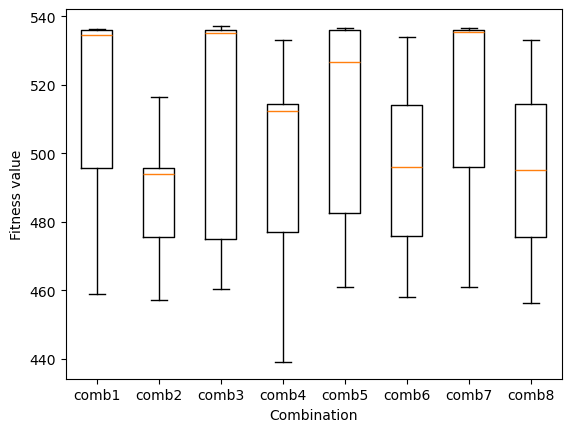

In [33]:
## Box Plot 

box_array = []
for i in combination:
   a = np.array(abf_best[i]).reshape(30,30).T.max(axis = 1)
   box_array.append(a)
plt.boxplot(box_array)
plt.xlabel('Combination')
plt.ylabel('Fitness value')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], combination)


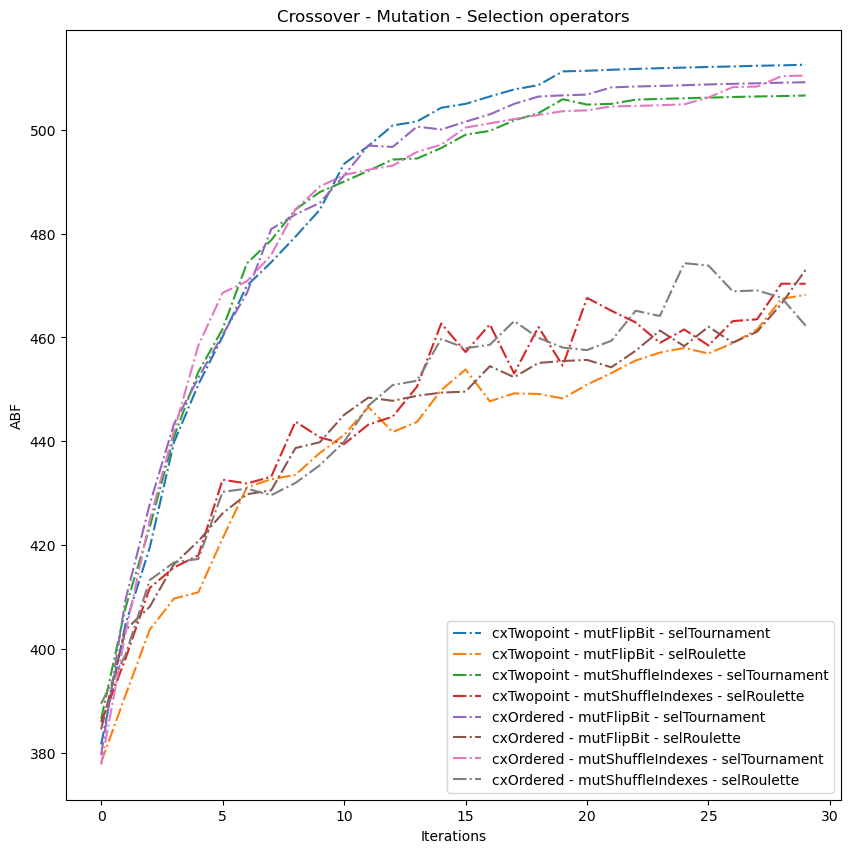

In [10]:
#Plotting the results for every different combination in a summarized manner
plt.figure(figsize=(10,10))
plt.plot(abf_avg_summarized ['comb1'], label = 'cxTwopoint - mutFlipBit - selTournament', linestyle="-.")
plt.plot(abf_avg_summarized ['comb2'], label = 'cxTwopoint - mutFlipBit - selRoulette', linestyle="-.")
plt.plot(abf_avg_summarized ['comb3'], label = 'cxTwopoint - mutShuffleIndexes - selTournament', linestyle="-.")
plt.plot(abf_avg_summarized ['comb4'], label = 'cxTwopoint - mutShuffleIndexes - selRoulette', linestyle="-.")
plt.plot(abf_avg_summarized ['comb5'], label = 'cxOrdered - mutFlipBit - selTournament', linestyle="-.")
plt.plot(abf_avg_summarized ['comb6'], label = 'cxOrdered - mutFlipBit - selRoulette', linestyle="-.")
plt.plot(abf_avg_summarized ['comb7'], label = 'cxOrdered - mutShuffleIndexes - selTournament', linestyle="-.")
plt.plot(abf_avg_summarized ['comb8'], label = 'cxOrdered - mutShuffleIndexes - selRoulette', linestyle="-.")
plt.xlabel("Iterations")
plt.ylabel("ABF")
plt.title("Crossover - Mutation - Selection operators")
plt.legend()
plt.show()

In [ ]:
#Getting the maximum values for the summarization table
abf_avg_summarized.max()

comb1     [527.1766666666666]
comb2     [484.0633333333334]
comb3     [536.9766666666666]
comb4    [489.63000000000005]
comb5     [534.5766666666666]
comb6     [489.0633333333334]
comb7     [531.9933333333335]
comb8    [494.77000000000004]
dtype: object

#### Getting the time taken for all the combinations

In [34]:
# This value may vary based on the system/underlying hardware
time_taken

[187.1708071231842,
 139.04410672187805,
 178.2866816520691,
 140.99729371070862,
 191.7376401424408,
 146.18869018554688,
 190.95755076408386,
 150.03386211395264]

### 3. Analysing impact of mutation and crossover probabilities and determining the best choice of hyper-parameters

#### Select best Crossover, mutation and selection techniques from the analysis made in Q2

In [36]:
# Evaluate a genome by a 'fitness' function 
toolbox.register("evaluate",fitness)

# Twopoint crossover is used (as mentioned)
toolbox.register("mate", tools.cxTwoPoint)

# Multi-Flip Bit mutation is carried out. Probability of flipping a attribute in a genome is 0.05
toolbox.register("mutate", tools.mutShuffleIndexes,indpb=0.05)

# Tournament selection with tournament of size 4
toolbox.register("select",tools.selTournament,tournsize=4 ) 

In [41]:
#Setting up hyper-parameters

NGEN = 30     # Number of generations
MU = 300     # Initial population       
pop = toolbox.population(n=MU)
hof = tools.ParetoFront()

# Compile statistics of the optimization
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0) 
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# Defining the list of hyper-parameters to be tested
mutpb = [0.2, 0.4, 0.6, 0.8]
cxpb = [0.2, 0.4, 0.6, 0.8]

# Define number of runs
RUN = 30

#Initializing a dataframe to store the average abf values for different combinations of CXPB and MUTPB
abf_df = pd.DataFrame()

# Create dictionary to store all maximum fitness values for particular combination
abf_distribution = {}

# iterating through the elements of list
for i in cxpb:
    for j in mutpb:
        abf_distribution[(i,j)] = []

# Creating lists and dictionaries to store values for analysis
max_list = []

# Run the GA for different combinations of CXPB and MUTPB
for i_cxpb in cxpb:
    for i_mutpb in mutpb:
        #Intializing a temporary array to store the preliminary average ABF values
        current_max_values = []
        #Initializing a array to store all the max values of each generation for every iteration
        max_list = []
        
        # Loop to calculate the ABF for 30 iterations
        for i in range(0,30):
            pop = toolbox.population(n=MU)
            hof = tools.ParetoFront()
            pop, log=algorithms.eaSimple(pop, toolbox, i_cxpb, i_mutpb, NGEN, stats,halloffame=hof)
        
            # Maximum fitness values of each generation to lists 
            max_list.append(log.select("max"))
        
        #Calculating the average best fitness value for the current combination
        for i in range(0,RUN):
            sum1 = 0
            for j in range(0,30):
                sum1 += max_list[j][i]
                abf_distribution[(i_cxpb,i_mutpb)].append(max_list[j][i][0])
            sum1 = sum1 / RUN
            current_max_values.append(sum1)

        #Appending ABF of different combinations to the dataframe for plotting
        abf_df[f'{i_cxpb} - {i_mutpb}'] = current_max_values

gen	nevals	avg      	std          	min    	max    
0  	300   	[151.083]	[83.45393826]	[-10.2]	[381.7]
1  	107   	[227.98033333]	[60.91744014]	[48.]  	[381.7]
2  	111   	[281.114]     	[56.47699712]	[68.3] 	[419.9]
3  	101   	[318.116]     	[48.5293912] 	[93.6] 	[419.9]
4  	95    	[346.22066667]	[42.90756079]	[137.1]	[419.9]
5  	112   	[363.72866667]	[53.26721861]	[99.8] 	[420.1]
6  	90    	[384.59566667]	[51.85257963]	[85.6] 	[437.3]
7  	98    	[397.384]     	[58.2241022] 	[86.]  	[457.5]
8  	114   	[396.01833333]	[70.895513]  	[68.3] 	[457.8]
9  	109   	[412.09733333]	[51.6009547] 	[27.8] 	[457.9]
10 	103   	[424.71033333]	[52.27453803]	[162.9]	[457.9]
11 	108   	[436.91933333]	[48.01027278]	[163.4]	[458.] 
12 	105   	[438.004]     	[61.68002959]	[68.]  	[458.3]
13 	114   	[436.93766667]	[63.57943547]	[80.7] 	[458.3]
14 	101   	[443.32033333]	[47.82129532]	[125.8]	[458.5]
15 	100   	[439.77233333]	[55.05710612]	[124.2]	[458.8]
16 	104   	[441.229]     	[52.90304773]	[126.2]	[494.7]
17

In [63]:
max_ABF = abf_df.max()
max_ABF

0.2 - 0.2    [505.93000000000006]
0.2 - 0.4     [511.0400000000001]
0.2 - 0.6     [516.5099999999999]
0.2 - 0.8     [527.9066666666666]
0.4 - 0.2     [512.4966666666667]
0.4 - 0.4     [528.1233333333334]
0.4 - 0.6     [525.1566666666669]
0.4 - 0.8     [526.0033333333333]
0.6 - 0.2                [525.02]
0.6 - 0.4     [520.7500000000001]
0.6 - 0.6     [521.6566666666666]
0.6 - 0.8                [530.48]
0.8 - 0.2     [523.5933333333335]
0.8 - 0.4     [530.9433333333334]
0.8 - 0.6     [531.0500000000001]
0.8 - 0.8     [520.3333333333334]
dtype: object

#### Box plot to show the distribution of best fitness value for different combinations of CXPB and MUTPB

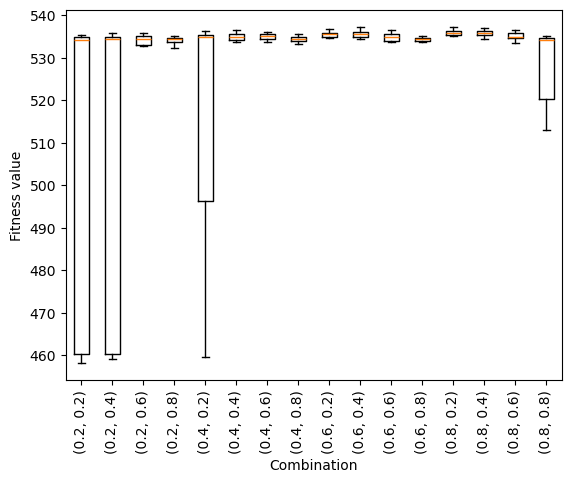

In [86]:
box_array = []
for i in abf_distribution.keys():
   a = np.array(abf_distribution[i]).reshape(30,30).T.max(axis = 1)
   box_array.append(a)
plt.boxplot(box_array, showfliers=False)
plt.xlabel('Combination')
plt.ylabel('Fitness value')
plt.xticks([1,2,3,4,5,6,7,8,9, 10, 11,12,13,14,15,16], abf_distribution.keys(), rotation=90);



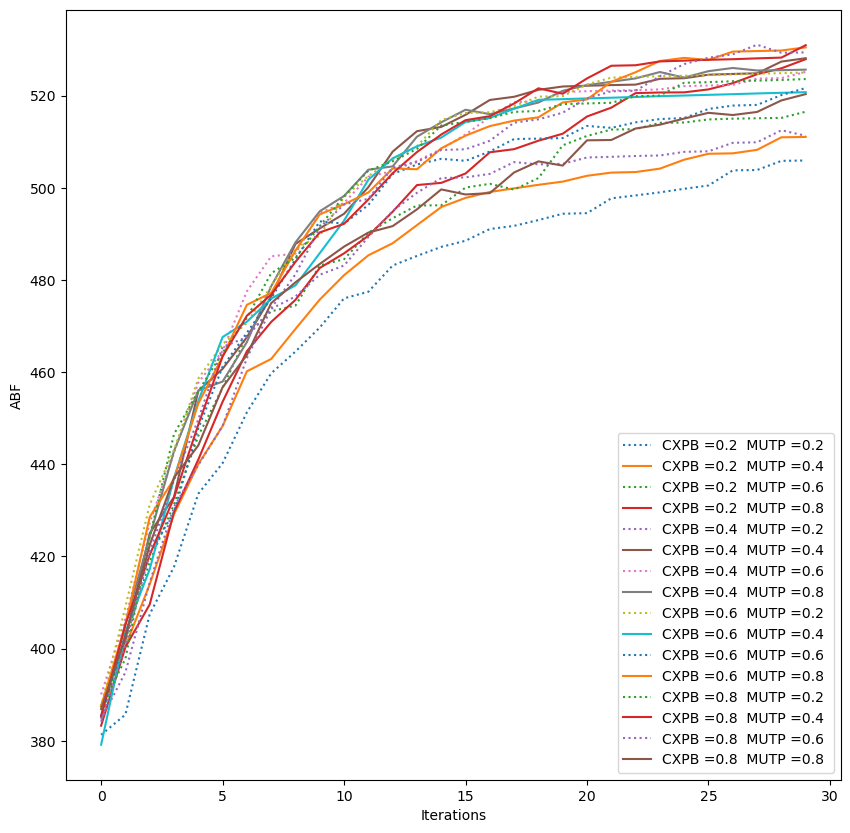

In [64]:
# Plot the ABF values for different values of CXPB and MUTPB

plt.figure(figsize=(10,10))
plt.plot(abf_df['0.2 - 0.2'],label = 'CXPB =0.2  MUTP =0.2 ', linestyle = ':')
plt.plot(abf_df['0.2 - 0.4'],label = 'CXPB =0.2  MUTP =0.4 ')
plt.plot(abf_df['0.2 - 0.6'],label = 'CXPB =0.2  MUTP =0.6 ', linestyle = ':')
plt.plot(abf_df['0.2 - 0.8'],label = 'CXPB =0.2  MUTP =0.8 ')
plt.plot(abf_df['0.4 - 0.2'],label = 'CXPB =0.4  MUTP =0.2 ', linestyle = ':')
plt.plot(abf_df['0.4 - 0.4'],label = 'CXPB =0.4  MUTP =0.4 ')
plt.plot(abf_df['0.4 - 0.6'],label = 'CXPB =0.4  MUTP =0.6 ', linestyle = ':')
plt.plot(abf_df['0.4 - 0.8'],label = 'CXPB =0.4  MUTP =0.8 ')
plt.plot(abf_df['0.6 - 0.2'],label = 'CXPB =0.6  MUTP =0.2 ', linestyle = ':')
plt.plot(abf_df['0.6 - 0.4'],label = 'CXPB =0.6  MUTP =0.4 ')
plt.plot(abf_df['0.6 - 0.6'],label = 'CXPB =0.6  MUTP =0.6 ', linestyle = ':')
plt.plot(abf_df['0.6 - 0.8'],label = 'CXPB =0.6  MUTP =0.8 ')
plt.plot(abf_df['0.8 - 0.2'],label = 'CXPB =0.8  MUTP =0.2 ', linestyle = ':')
plt.plot(abf_df['0.8 - 0.4'],label = 'CXPB =0.8  MUTP =0.4 ')
plt.plot(abf_df['0.8 - 0.6'],label = 'CXPB =0.8  MUTP =0.6 ', linestyle = ':')
plt.plot(abf_df['0.8 - 0.8'],label = 'CXPB =0.8  MUTP =0.8 ')
plt.xlabel("Iterations")
plt.ylabel("ABF")
plt.legend()
plt.show()

### 4. Constraining the Solutions

In [65]:
def fix_columns(offspring):
    """
    Fix the columns of the offspring array by removing excess non-zero values.

    Parameters:
    offspring (list): The offspring array.

    Returns:
    list: The modified offspring array with excess non-zero values removed.
    """
    offspring = np.array(offspring).flatten().reshape(12, 12)
    for i in range(12):
        non_zero_indices = np.where(offspring[:, i] != 0)[0]
        if len(non_zero_indices) > 2:
            random_indices = random.sample(list(non_zero_indices), len(non_zero_indices) - 2)
            for j in random_indices:
                offspring[j, i] = 0
    return creator.Individual(offspring.flatten().tolist())

def constrain():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offsprings= func(*args, **kwargs)  # This calls the crossover/mutation function
            modified_offsprings = [] # This will store the modified offsprings
            for child in offsprings: # For each offspring (2 for crossover, 1 for mutation)
                modified_offsprings.append(fix_columns(child)) # Fix the columns of the offspring
            return modified_offsprings 
        return wrapper
    return decorator

In [85]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 0.2)
toolbox.register("select", tools.selTournament, tournsize = 4)
toolbox.decorate("mate", constrain())
toolbox.decorate("mutate", constrain())

In [72]:
NGEN = 30
MU = 300       #The number of individuals to select for the next generation
CXPB = 0.8
MUTPB = 0.6

maxes = []
hofs = []
for i in range(30):

    pop = toolbox.population(n=MU)
    hof = tools.ParetoFront()

    # The hall of fame contains the best individual that ever lived in the population during the evolution
    # a ParetoFront may be used to retrieve the best non dominated individuals of the evolution
    # a Statistics object is created for compiling four different statistics (avg, std, min, max) over the generations.

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # parameter Statistics 1 function ast- A function to access the values on which to compute the statistics, 
    # ind is argument of function and (ind.fitness.values) is the expression that is evaluated and the result of the expression is returned
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0) #standard deviation,  dispersion of a dataset relative to its mean and
    #is calculated as the square root of the variance.
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    out, log = algorithms.eaSimple(population = pop, toolbox = toolbox, cxpb=CXPB, mutpb=MUTPB,  ngen = NGEN, stats =stats, halloffame=hof)
    max = []
    for gen in log:
        max.append(gen['max'])
    hofs.append(hof[-1])
    maxes.append(max)

gen	nevals	avg           	std          	min   	max    
0  	300   	[144.98033333]	[82.60540487]	[-9.9]	[382.4]
1  	286   	[55.87033333] 	[67.48379475]	[-2.4]	[361.5]
2  	289   	[89.013]      	[60.6520909] 	[-2.4]	[361.5]
3  	270   	[126.96066667]	[62.28247361]	[-2.4]	[299.3]
4  	283   	[160.405]     	[69.76142015]	[-2.4]	[337.4]
5  	276   	[189.432]     	[77.50075726]	[-2.1]	[321.1]
6  	269   	[227.12366667]	[74.64328597]	[-1.9]	[339.] 
7  	268   	[258.61466667]	[65.91136512]	[-1.3]	[339.] 
8  	266   	[281.07633333]	[59.28411372]	[54.4]	[408.1]
9  	278   	[297.768]     	[54.42324788]	[74.4]	[428.3]
10 	278   	[297.43833333]	[63.34890552]	[36.4]	[428.3]
11 	283   	[309.32833333]	[61.57999321]	[74.6]	[428.3]
12 	275   	[328.22866667]	[61.77521006]	[88.8]	[428.4]
13 	279   	[345.978]     	[70.78941952]	[84.4]	[428.5]
14 	278   	[376.178]     	[68.35059558]	[88.6]	[446.1]
15 	278   	[394.76566667]	[62.16584851]	[88.9]	[446.3]
16 	277   	[397.82366667]	[57.9374744] 	[89.] 	[466.] 
17 	271   

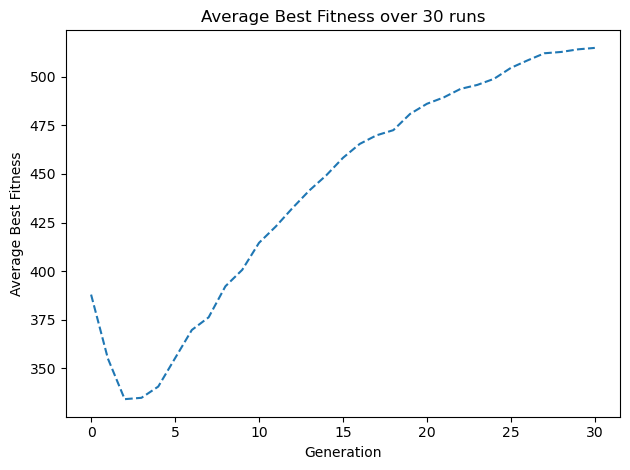

In [73]:
maxes_array = np.array(maxes)
abf = maxes_array.mean(axis = 0).shape

plt.plot(maxes_array.mean(axis = 0), "--", label = 'Mean')
plt.xlabel('Generation')
plt.ylabel('Average Best Fitness')
plt.title('Average Best Fitness over 30 runs')
plt.tight_layout()
plt.savefig('graphs/average_best_fitness.png')

### Getting the best unconstrained solution for visualization

In [78]:
# Evaluate a genome by a 'fitness' function 
toolbox.register("evaluate",fitness)

# Twopoint crossover is used (as mentioned)
toolbox.register("mate", tools.cxTwoPoint)

# Multi-Flip Bit mutation is carried out. Probability of flipping a attribute in a genome is 0.05
toolbox.register("mutate", tools.mutShuffleIndexes,indpb=0.05)

# Tournament selection with tournament of size 4
toolbox.register("select",tools.selTournament,tournsize=4 ) 

NGEN = 30       #Number of generations
MU = 300         #The number of individuals in first generation (initial population)
CXPB = 0.8     #Cross-over probability
MUTPB = 0.6    #Mutation probability

pop = toolbox.population(n=MU)

# Hall of Fame
hof = tools.ParetoFront()

# Statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0) 
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# easimple algorithm is implemented. Population and logbook of statistic results are stored 
pop,log=algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats,halloffame=hof)



gen	nevals	avg           	std         	min    	max    
0  	300   	[153.19566667]	[87.9091949]	[-10.1]	[360.6]
1  	279   	[224.11866667]	[74.7266395]	[28.8] 	[418.] 
2  	273   	[264.151]     	[68.22911572]	[45.2] 	[418.] 
3  	272   	[290.58833333]	[74.02346045]	[8.3]  	[417.7]
4  	277   	[310.071]     	[74.36099331]	[71.5] 	[472.5]
5  	271   	[322.28266667]	[76.87650334]	[80.1] 	[472.7]
6  	275   	[332.36233333]	[87.21765541]	[47.5] 	[512.3]
7  	268   	[341.06766667]	[83.24399951]	[100.3]	[475.2]
8  	273   	[342.58933333]	[89.9654394] 	[67.7] 	[513.1]
9  	277   	[360.11766667]	[90.40675853]	[91.2] 	[513.5]
10 	277   	[381.21666667]	[87.61013139]	[93.8] 	[513.5]
11 	272   	[393.63766667]	[90.51812828]	[100.4]	[513.5]
12 	278   	[398.34433333]	[98.55409987]	[98.5] 	[533.4]
13 	285   	[407.71766667]	[101.70819233]	[80.7] 	[533.4]
14 	274   	[416.839]     	[100.3978601] 	[97.8] 	[533.1]
15 	287   	[412.838]     	[111.40783436]	[79.2] 	[533.6]
16 	280   	[423.72633333]	[109.73810402]	[71.]  

In [81]:
print(f"Best solution:\n {np.array(hof[-1]).reshape(12,12)}.")
print(f"Total value of best solution: {fitness(hof[-1])}")

Best solution:
 [[-1  1 -1 -1  0 -1 -1  1 -1 -1  0  0]
 [-1  0  0  1  0  0  0  0  1 -1 -1  0]
 [-1  0  0  0  1 -1 -1 -1  0  0  1 -1]
 [-1  1 -1  0 -1  1  0 -1  1  0 -1  0]
 [ 0 -1  0  0  1  0  0  0  1  0  0 -1]
 [ 1 -1  0 -1 -1  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  1  1 -1  0  0  0  0]
 [ 0 -1  0  0  0  0  1  0  0 -1 -1  0]
 [ 1 -1  0  0  0  0  1  0  0  1 -1  1]
 [ 1  1  0  0  1  0  0  1  1  0  0 -1]
 [-1  0  0 -1  0  1  0  0  1  0 -1  0]
 [ 1  0  0  1  0  0  0 -1  0  0  0  0]].
Total value of best solution: (536.1,)


In [82]:
matrix_to_graphviz(hof[-1], output_file='graphs/before_decorator.pdf')